## Import Libraries and Models


In [21]:
from collections import defaultdict
import copy
import random
import os
import sys
import shutil
from urllib.request import urlretrieve
#from imutils import paths #Python library that provides a collection of convenience functions for common tasks in computer vision and image processing
#from sklearn.model_selection import train_test_split  #An open-source Python library that provides a wide range of tools and algorithms for machine learning, data mining, and data analysis.
import json
import importlib
import logging
import gc

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np


import albumentations as A
from albumentations.pytorch import ToTensorV2


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn #All neural network modules, nn.linear, nn.conv2d, BatchNorm, Loss functions
import torch.optim as optim #For all optimization algorithms SGD, Adam
import torch.nn.functional as F #All functions that dont have any parameter
from torch.utils.data import Dataset, DataLoader #Pytorch standard dataset and its management
from torchsummary import summary

from tqdm import tqdm

import segmentation_models_pytorch as smp
import DcsNET #deep crack segmentation model
import DcsNET_deep #deep crack segmentation model  with deep supervision module
from UTNet.model.utnet import UTNet
from UTNet.model.resnet_utnet import ResNet_UTNet
from DTrC_Net import CTCNet
import CTCNet

cudnn.benchmark = True



## Check Pytorch Installation

In [2]:
#Check Pytorch Installation
print(torch.version.__version__, torch.cuda.is_available())

2.1.2+cu118 True


## Dataset Loading and Visualization

In [14]:
# Defining a function to visualize the dataset and their labels (masks-binary)
# Function to normalize the mask for better visualization
def normalize_array(array):
    array_min = array.min()
    array_max = array.max()
    normalized_array = (array - array_min) / (array_max - array_min) * 255
    return normalized_array.astype(np.uint8)

# Function to visualize a grid of images with associated masks
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None, font_size=12):
    # Determine the number of columns and adjust figsize accordingly
    cols = 5 if predicted_masks else 3  # More columns if predicted masks are included
    rows = len(images_filenames)
    # Set the figsize dynamically based on the number of columns
    base_figsize_width = 10  # Base width for three columns
    base_figsize_height = 24  # Base height for the given number of rows
    extra_width_per_col = 2  # Additional width for each extra column

    # Calculate the appropriate figsize based on the number of columns
    figsize_width = base_figsize_width + (cols - 3) * extra_width_per_col
    figsize = (figsize_width, base_figsize_height)

    # Create the subplot grid with the dynamic figsize
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    # Loop through the image filenames and display them along with their masks
    for i, image_filename in enumerate(images_filenames):
        # Load the image
        image_path = os.path.join(images_directory, image_filename)
        image = np.array(Image.open(image_path).convert("RGB"))

        # Load the mask and create an overlay
        mask_path = os.path.join(masks_directory, image_filename.replace(".jpg", ".png"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        #print("Unique pixel values in mask:", np.unique(mask))
        mask_color = cv2.applyColorMap(np.uint8(mask * 2), cv2.COLORMAP_JET)
        overlay_mask = cv2.addWeighted(image, 0.6, mask_color, 0.4, 0)

        # Display the original image, mask, and overlay
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 2].imshow(overlay_mask)

        # Set the titles with the specified font size
        ax[i, 0].set_title("Image", fontsize=10)
        ax[i, 1].set_title("Ground Truth Mask", fontsize=10)
        ax[i, 2].set_title("Overlay of Image with GT Mask", fontsize=10)

        # Turn off axes
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

        # If there are predicted masks, add them to the plot
        if predicted_masks:
            # Predicted mask normalization and color mapping
            predicted_mask = normalize_array(predicted_masks[i])  # Normalize for better color mapping
            #predicted_mask = predicted_masks[i]
            #print("Unique pixel values in mask:", np.unique(mask))
            predicted_mask_color = cv2.applyColorMap(np.uint8(predicted_mask * 2), cv2.COLORMAP_JET)
            #predicted_mask_color = cv2.applyColorMap(predicted_mask, cv2.COLORMAP_MAGMA)  # Better color map
            overlay_predicted_mask = cv2.addWeighted(image, 0.6, predicted_mask_color, 0.4, 0)

            # Display the predicted mask and overlay
            ax[i, 3].imshow(predicted_mask, cmap='gray')
            ax[i, 4].imshow(overlay_predicted_mask)

            # Set titles with the specified font size
            ax[i, 3].set_title("Predicted Mask", fontsize=10)
            ax[i, 4].set_title("Overlay of Image with Predicted Mask", fontsize=10)

            # Turn off axes
            ax[i, 3].set_axis_off()
            ax[i, 4].set_axis_off()

    # Adjust layout and display the plot
    plt.tight_layout()  # Adjust spacing to avoid overlaps
    #plt.savefig("/home/ali/Segmentation_Project/Outputs/Figures/Crop_Crack500.png")
    plt.show()

In [15]:
# Loading the images and masks dataset and then visualizing them
train_dataset_root_directory = os.path.join(os.environ["HOME"], "Segmentation_Project/Crack_Datasets/Crack500_cropped/Train") 
valid_dataset_root_directory = os.path.join(os.environ["HOME"], "Segmentation_Project/Crack_Datasets/Crack500_cropped/Valid")

train_images_dataset_path = os.path.join(train_dataset_root_directory, "Images") # provide the train images path
train_masks_dataset_path = os.path.join(train_dataset_root_directory, "Masks")    # provide the train masks path

valid_images_dataset_path = os.path.join(valid_dataset_root_directory, "Images") # provide the valid images path
valid_masks_dataset_path = os.path.join(valid_dataset_root_directory, "Masks")    # provide the valid masks path

train_images_filenames = list(sorted(os.listdir(train_images_dataset_path)))
valid_images_filenames = list(sorted(os.listdir(valid_images_dataset_path)))
#masks_dataset_filenames = list(sorted(os.listdir(masks_dataset_path)))\

print("Training dataset size:", len(train_images_filenames))
print("Validation dataset size:", len(valid_images_filenames))

Training dataset size: 16000
Validation dataset size: 2000


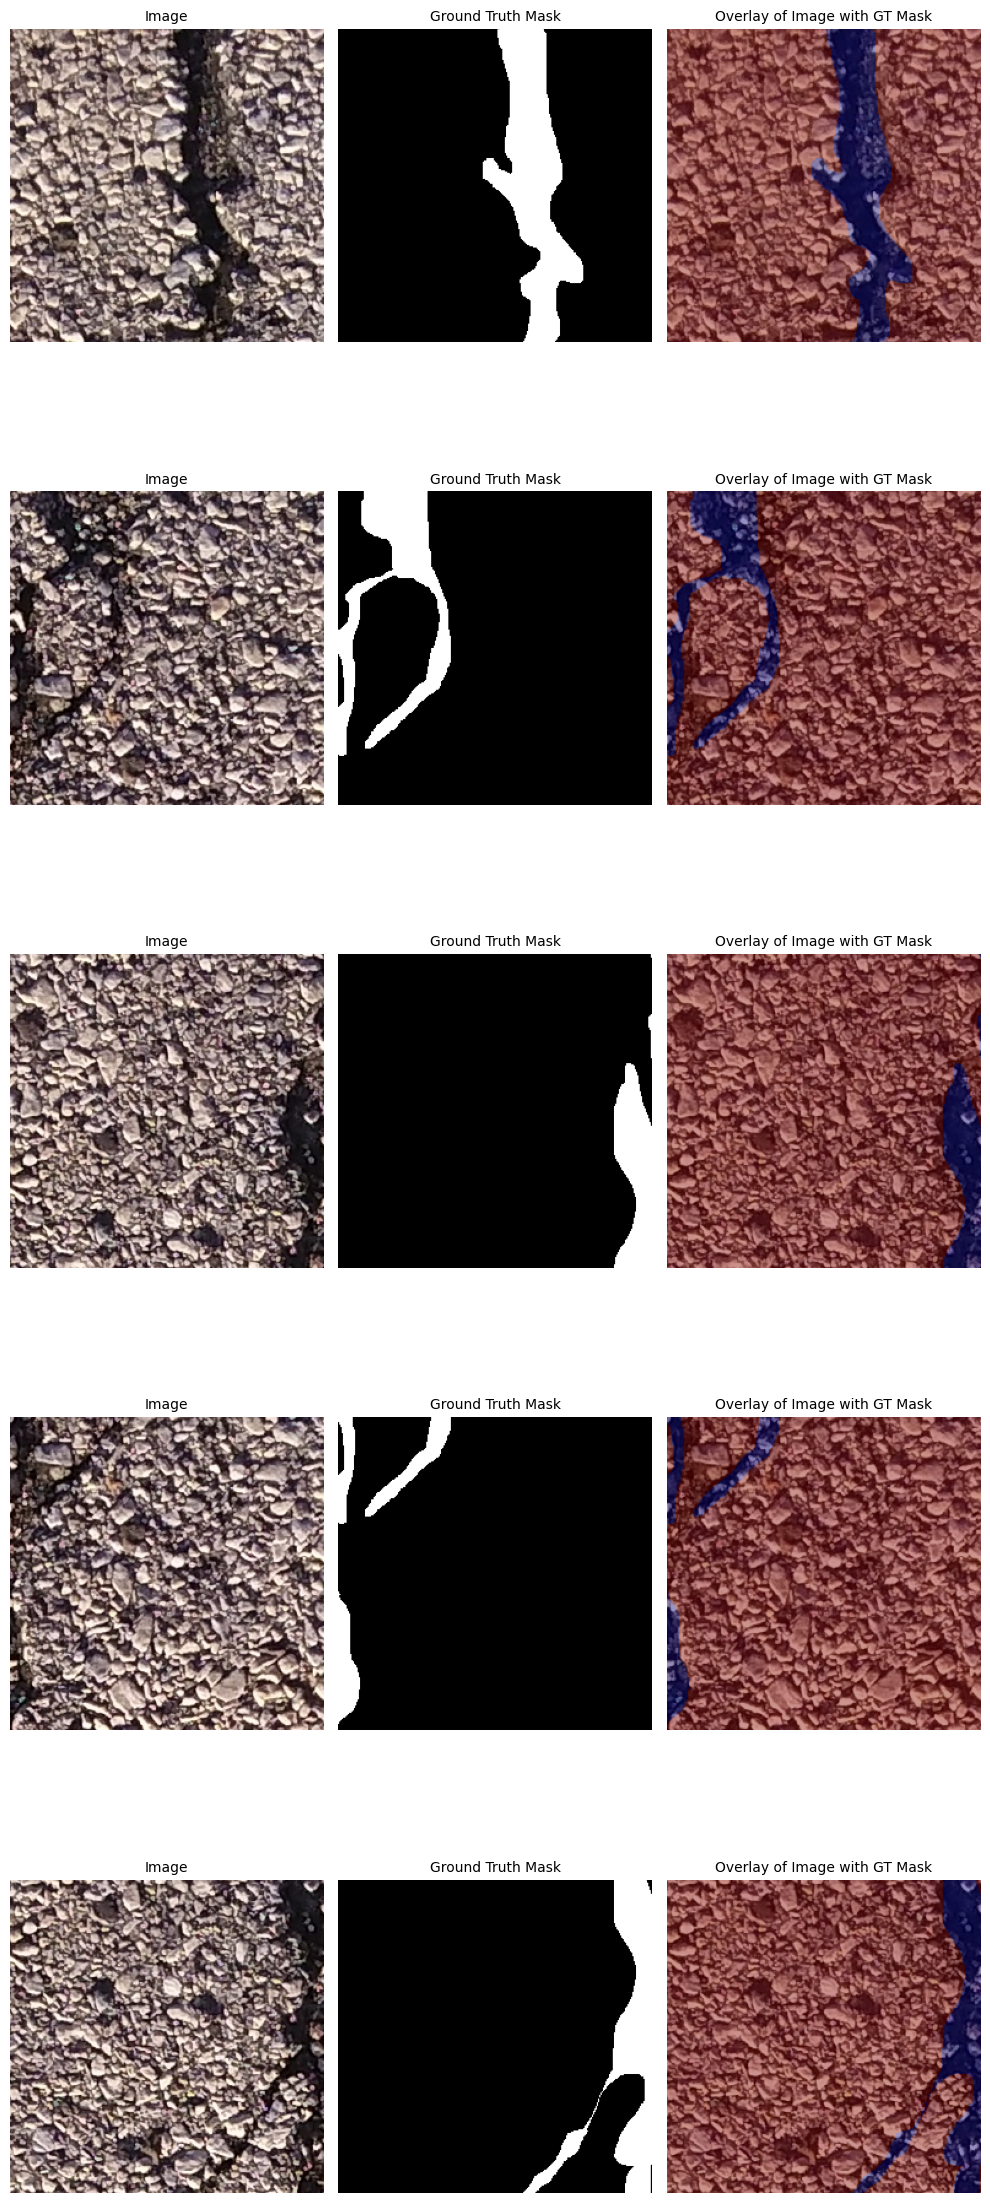

In [16]:
#Training Dataset Visualization:
display_image_grid(train_images_filenames[:5], train_images_dataset_path, train_masks_dataset_path)

In [6]:
#Check the pixel values:
for i, image_filename in enumerate(train_images_filenames[:5]):
        
        train_mask_path = os.path.join(train_masks_dataset_path, image_filename.replace(".jpg", ".png")) #mask path
        train_mask = np.array(Image.open(train_mask_path).convert("L"), dtype=np.float32) #open masks from the mask path specified
        print("Unique pixel values in train mask:", np.unique(train_mask))

Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]
Unique pixel values in train mask: [  0. 255.]


## Define Pytorch Segmentation Dataset


In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, images_filename, images_directory, masks_directory, transform=None):
        # store the images filenames, images path, masks path, augmentations transform
        self.images_filenames = images_filename
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.images_filenames)
        
    
    def __getitem__(self, index):
        image_filename = self.images_filenames[index]
        image_path = os.path.join(self.images_directory, image_filename)  # provide the image path
        mask_path = os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")) # provide the mask  path

        image = np.array(Image.open(image_path).convert("RGB")) #open images from image path provided (PIL format required by Pytorch)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) #open masks from the mask path provided (PIL format required by Pytorch)
        #preprocess mask
        #mask = preprocess_mask(mask)
        mask[mask == 255.0] = 1.0 # for binary segmentation convert 255 pixel values to 1, sigmoid[0-1] as last activation layer

        # check to see if we are applying any transformations
        if self.transform is not None:
           augmentations = self.transform(image=image, mask=mask)
           image = augmentations["image"] # apply the transformations to image
           mask = augmentations["mask"] #apply the transformation to mask

        # return a tuple of images and masks
        return image, mask

## Define the Augmentations (Transformations) applied to training and validation datasets

In [8]:
train_transform = A.Compose(
    [
        #A.PadIfNeeded(min_height=2048, min_width=2048, border_mode=cv2.BORDER_CONSTANT), # Padding if required
        #A.Resize(height = 352, width = 640, interpolation=cv2.INTER_NEAREST), # Resizing if required (maintianing the aspect ratio)
        #A.CenterCrop(height=512, width=512), # Cropping if required
        A.Rotate(limit=45, interpolation=cv2.INTER_NEAREST, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.5, rotate_limit=0, p=0.5),
        #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Sharpen(alpha=(0.2,0.5), lightness=(0.5,1.0), p=0.5),
        #A.Affine(scale=0.3, translate_percent=0.3, rotate=45, shear=45, p=0.5),
        A.Normalize(
            mean = [0.0,0.0,0.0],
            std = [1.0,1.0,1.0],
            max_pixelvalues=255.0 # dividing by 255.0 to get a value between 0.0 and 1.0 (Binary Segementation)
        ),
        ToTensorV2(), #convert input data to Pytorch Tensor
    ]
    
)

valid_transform = A.Compose(
    [
        #A.Resize(height = 352, width = 640, interpolation=cv2.INTER_NEAREST),
        A.Normalize(
            mean = [0.0,0.0,0.0],
            std = [1.0,1.0,1.0],
            max_pixelvalues=255.0 # dividing by 255.0 to get a value between 0.0 and 1.0 (Binary Segementation)
        ),
    ToTensorV2(),
    ]
)

train_dataset = SegmentationDataset(train_images_filenames, train_images_dataset_path, train_masks_dataset_path, transform=train_transform,) # creating the training dataset with defined augmentation/transformations for Pytorch Dataloader
valid_dataset = SegmentationDataset(valid_images_filenames, valid_images_dataset_path, valid_masks_dataset_path, transform=valid_transform,) # creating the validation dataset with defined augmentations/transformations for Pytorch Dataloader

print(len(train_dataset))
print(len(valid_dataset))

16000
2000


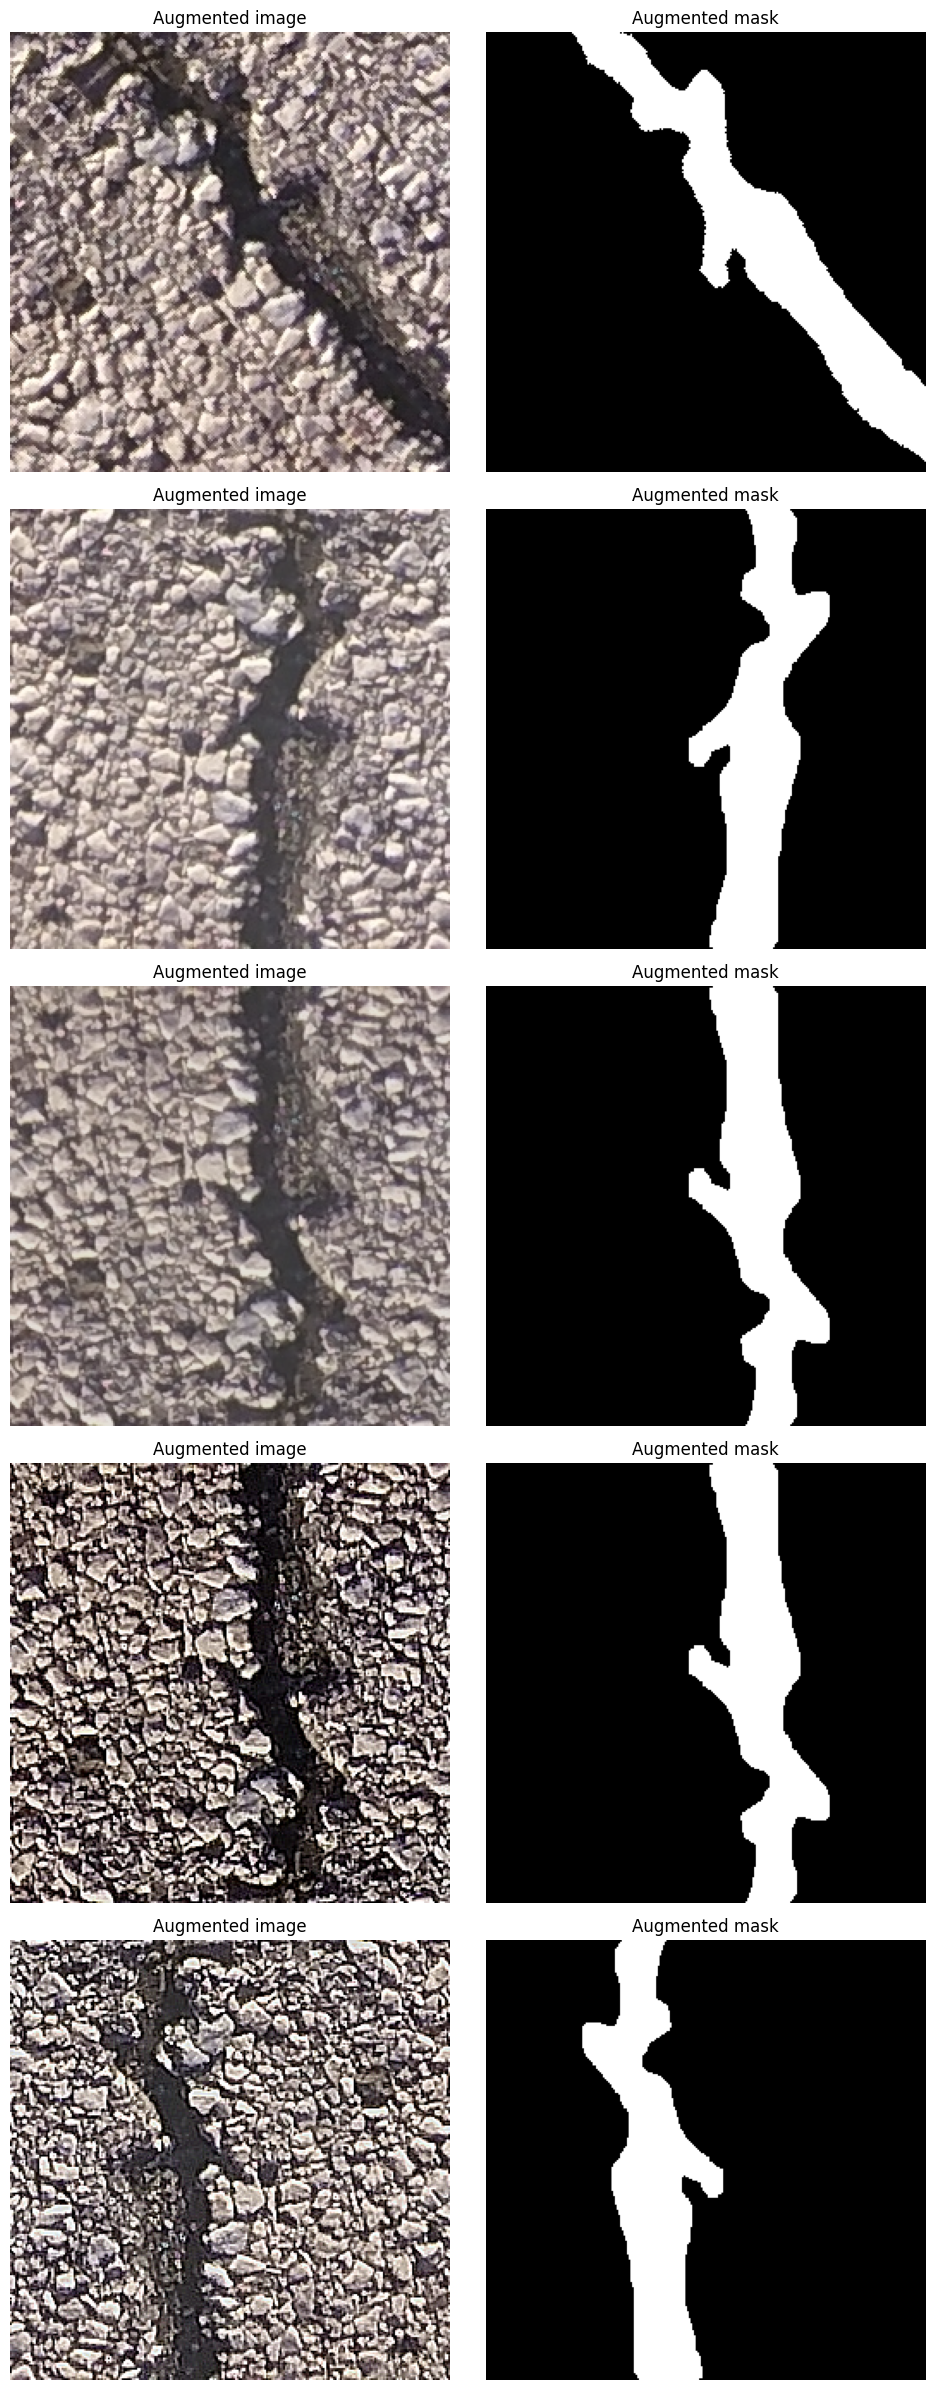

In [13]:
# Visualizing the augmentations (transformations) applied
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset) #so that the original dataset is not affected
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]) #remove the normalize and ToTensor transformations for visualization purpose
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    #plt.savefig("/home/ali/Segmentation_Project/Outputs/Figures/Augmentations.png")
    plt.show()


random.seed(30)
visualize_augmentations(train_dataset, idx=0)

## Define custom training loss functions and validation evaluation metrics

In [17]:
#Trianining Losses:
def dice_loss(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice_loss = 1 - ((2. * intersection + eps) / (union + eps))
    return dice_loss

def soft_jaccard_loss(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    soft_jaccard_loss = torch.log((intersection + eps) / (union - intersection + eps))
    return soft_jaccard_loss


class LossBinary_BCEDICE:
    """
    Loss defined as (0.5BCE + 0.5Dice) --> from literature reference (for imbalanced datasets)
    """

    def __init__(self, BCE_weight=0, DICE_weight=0):
        self.BCE_loss = nn.BCEWithLogitsLoss(reduction='mean') #check documentation:https://pytorch.org/docs/stable/nn.html)
        self.BCE_weight = BCE_weight
        self.DICE_weight = DICE_weight

    def __call__(self, pred, target, threshold):
        BCE_loss = self.BCE_loss(pred, target)
        Dice_loss = dice_loss(torch.sigmoid(pred), target, threshold)
        loss = (self.BCE_weight*BCE_loss + self.DICE_weight*Dice_loss)

        return loss 

class LossBinarySoftJaccard:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard (https://github.com/ternaus/robot-surgery-segmentation/blob/master/loss.py)
    """

    def __init__(self, jaccard_weight=0):
        self.BCE_loss = nn.BCEWithLogitsLoss(reduction='mean') #check documentation:https://pytorch.org/docs/stable/nn.html)
        self.jaccard_weight = jaccard_weight

    def __call__(self, pred, target, threshold):
        loss = (1 - self.jaccard_weight) * self.BCE_loss(pred, target) #calculating the BCE componency
        
        if self.jaccard_weight: # calculating the soft Jacarda loss component
           loss -= self.jaccard_weight * soft_jaccard_loss(torch.sigmoid(pred), target, threshold)
        
        return loss
    
# Evaluation Metrics
def dice_score(pred, target, threshold, eps=1e-15): # --> main metric to monitor for validation (it corresponds to F-1 score)
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice_score = (2. * intersection + eps) / (union + eps)
    return dice_score

def Jaccard_score(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    Jaccard_score = (intersection + eps) / (union + eps)
    return Jaccard_score

def IOU_score(pred, target, threshold):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    tp = ((pred == 1) & (target == 1)).sum() # True Positives (TP): Both pred and target are 1
    fp = ((pred == 1) & (target == 0)).sum() # False Positives (FP): pred is 1, target is 0
    fn = ((pred == 0) & (target == 1)).sum()  # False Negatives (FN): pred is 0, target is 1
    IOU_score = tp / (tp + fp + fn)
    return IOU_score

def accuracy(pred, target, threshold):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    num_correct = (pred == target).sum()
    num_pixels = torch.numel(target)
    accuracy = num_correct/num_pixels
    return accuracy*100

def precision(pred, target, threshold, eps=1e-15):
    pred = (pred > threshold).float() #binarize predictions based on the given threshold
    tp = ((pred == 1) & (target == 1)).sum() # True Positives (TP): Both pred and target are 1
    fp = ((pred == 1) & (target == 0)).sum() # False Positives (FP): pred is 1, target is 0
    precision = (tp + eps) / (tp + fp + eps) # eps (very small) to avoid nan (division by zero as observed for some models)
    return precision


In [30]:
# Defining EarlyStopping class with a start_epoch parameter (meaning after which training epochs the early stopping should start to implement)
class EarlyStopping:
    def __init__(self, patience=3, start_epoch=100, verbose=False):
        self.patience = patience  # Number of epochs to wait for improvement
        self.start_epoch = start_epoch  # Minimum epochs before early stopping starts
        self.verbose = verbose  # Whether to print early stopping messages
        self.counter = 0  # Number of epochs without improvement
        self.best_score = -float("inf")  # Track the best Dice score
        self.early_stop = False  # Flag to indicate early stopping
        self.best_weights = None  # Store the best model state dict

    def __call__(self, val_metric, model, epoch):
        if epoch < self.start_epoch:  # Check if early stopping should start
            return  # Don't consider early stopping before the start_epoch

        if self.best_score < val_metric:  # If current Dice score is better
            self.best_score = val_metric
            self.save_checkpoint(val_metric, model)  # Save the best model
            self.counter = 0  # Reset the counter
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping patience: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True  # Trigger early stopping

    def save_checkpoint(self, val_metric, model):
        """Save the model when validation Dice score improves."""
        if self.verbose:
            print(f"Validation Dice score improved ({self.best_score:.4f} --> {val_metric:.4f}). Saving model...")
        self.best_weights = copy.deepcopy(model.state_dict())  # Save the model's best weights

# Definign Training function:

def train(train_loader, model, optimizer, criterion, scaler, epoch, params):

    train_running_loss = 0 #initialize the training running loss
    model.train() #prepare the model for training
    loop = tqdm(train_loader) #progress bar to track the progress of iteration through the batches of training data

    
    #loop over the training dataset
    for batch_idx, (images, targets) in enumerate(loop, start=1):
        
        images = images.to(params["device"], non_blocking =True) #ensuring the computations on GPU
        targets = targets.float().unsqueeze(1).to(params["device"], non_blocking=True) #padding a channel dimension and ensuring the computations on GPU

        #forward propagation
        with torch.cuda.amp.autocast(enabled=True):

            if params["model"] == "DcsNet_deep":
               predictions, deep_sup_1, deep_sup_2 = model(images) #make predictions on the batch of training images
               #After making predictions calculate the loss as monitoring metric for training and updating of model pararmeters (weights and biases)
               loss = criterion(predictions, targets, params["threshold"])
               loss = loss + 0.4*dice_loss(torch.sigmoid(deep_sup_1), targets, params["threshold"]) + 0.4*dice_loss(torch.sigmoid(deep_sup_2), targets, params["threshold"])
               #loss = loss + 0.4*(criterion(deep_sup_1, targets, params["threshold"])) + 0.4*(criterion(deep_sup_2, targets, params["threshold"]))
            else:
               predictions = model(images) #make predictions on the batch of training images
               #After making predictions calculate the loss as monitoring metric for training and updating of model pararmeters (weights and biases)
               loss = criterion(predictions, targets, params["threshold"])

        #backward propagation
        optimizer.zero_grad(set_to_none=True) # Zero any previously accumulated gradients
        scaler.scale(loss).backward()  # Apply the scaled gradients (loss.backward())
        scaler.step(optimizer)  # Take the optimizer step with scaler (optimizer.step())
        scaler.update()  # Now update the scaler for the next iteration
        
        
        #update training loss
        train_running_loss += loss.item() #Note: .item() method in PyTorch is used to extract the scalar value from a tensor that contains only a single element
        train_loss = train_running_loss / batch_idx #average training loss for each batch (dynamic)

        #update the tqdm loop
        mem = f"{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G"  #memory consumed (GB)
        #loop.set_postfix(loss=loss.item(), train_loss=train_loss)
        loop.set_description("Epoch: {epoch}. Training. Train Loss: {train_loss:.4f}. Memory: {mem}".format(epoch=epoch, train_loss=train_loss, mem=mem))

        #torch.cuda.empty_cache()


    return train_loss


# Defining Validation Function:

def validate(valid_loader, model, epoch, params):

    valid_running_accuracy = 0
    valid_running_precision = 0
    valid_running_dice_score = 0
    valid_running_IOU_score = 0
    
    model.eval() #prepare the evaluation model for validation dataset
    loop = tqdm(valid_loader)


    for batch_idx, (images,targets) in enumerate(loop, start=1):
        images = images.to(params["device"], non_blocking =True) #Ensuring the computations on GPU
        targets = targets.float().unsqueeze(1).to(params["device"], non_blocking=True) #padding a channel dimension and ensuring the computations on GPU

        #forward propagation
        with torch.no_grad():
            
            if params["model"] == "DcsNet_deep":
                predictions, deep_sup_1, deep_sup_2 = model(images)
            else:
                predictions = model(images) #make predictions on the batch of validation images
            
            #After making the predictions calculate the accuracy and dice score as monitoring metric for validation to guide learning of hyperparameters
            accuracy_value = accuracy(torch.sigmoid(predictions), targets, params["threshold"])
            precision_value = precision(torch.sigmoid(predictions), targets, params["threshold"])
            dice_score_value = dice_score(torch.sigmoid(predictions), targets, params["threshold"]) #main metric to monitor for validation as early stopping
            IOU_score_value = IOU_score(torch.sigmoid(predictions), targets, params["threshold"])
            

            #update the acuracy, precision, dice score and IOU score (evaluation metrics)
            valid_running_accuracy += accuracy_value.item()
            valid_accuracy = valid_running_accuracy / batch_idx
            valid_running_precision += precision_value.item()
            valid_precision = valid_running_precision / batch_idx # average validation accuracy for each batch
            valid_running_dice_score += dice_score_value.item()
            valid_dice_score = valid_running_dice_score / batch_idx
            valid_running_IOU_score += IOU_score_value.item()
            valid_IOU_score = valid_running_IOU_score / batch_idx
            

            #update the tqdm loop
            loop.set_description("Epoch: {epoch}.  Validation. Valid Accuracy: {valid_accuracy:.4f}. Valid Precision: {valid_precision:.4f}. Valid Dice Score: {valid_dice_score:.4f}. Valid IOU: {valid_IOU_score:.4f}".format(epoch=epoch, valid_accuracy=valid_accuracy, valid_precision=valid_precision, valid_dice_score=valid_dice_score, valid_IOU_score=valid_IOU_score))

    model.train()

    
    return valid_accuracy, valid_precision, valid_dice_score, valid_IOU_score

# Defining the main training and validation function

def train_and_validate(model, model_name, train_dataset, valid_dataset, params):
    # Create data loaders for training and validation datasets loader
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        num_workers=params["num_workers"],
        shuffle=True,
        pin_memory=True,
    )
    
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=params["batch_size"],
        num_workers=params["num_workers"],
        shuffle=False,
        pin_memory=True,
    )
    
    
    # Define optimizers, learning rate scheduler, training loss, mixed precision gradient scaler
    #optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay = 0.0001)
    optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9, weight_decay=0.0001)
    
    scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=params["epochs"], power=0.9)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    
    criterion = LossBinary_BCEDICE(BCE_weight=0.5, DICE_weight=0.5)
    #criterion = LossBinarySoftJaccard(jaccard_weight=0.75)
    
    scaler = torch.cuda.amp.GradScaler(enabled=True)

    # Initialize early stopping with a start_epoch threshold
    early_stopping = EarlyStopping(
        patience=params["patience"], 
        start_epoch=100,  # Early stopping starts after 100 epochs
        verbose=True  # Print messages when early stopping occurs
    )
    
    # Initialize a dictionary to store training and validation history
    history = {
        "epochs": [],
        "train_loss": [],
        "valid_accuracy": [],
        "valid_precision": [],
        "valid_dice_score": [],
        "valid_IOU_score": [],
        "lr": [],
    }
    
    # Check pretrained model weights
    pretrained = params["weights"].endswith(".pth")
    if pretrained:
        ckpt = torch.load(params['weights'], map_location=params["device"])
        model.load_state_dict(ckpt["model"].float().state_dict())
        logging.info(f"Model ckpt loaded from {params['weights']}")
    model.to(params["device"])

    #  Resume
    if pretrained:
        if ckpt["optimizer"] is not None:
            start_epoch = ckpt["epoch"] + 1
            #last_score = ckpt["last_score"]
            optimizer.load_state_dict(ckpt["optimizer"])
            logging.info(f"Optimizer loaded from {params['weights']}")
            if start_epoch < params["epochs"]:
                logging.info(
                    f"{params['weights']} has been trained for {start_epoch} epochs. Fine-tuning for {params['weights']} epochs"
                )
        if "history" in ckpt:  # Check if history dictionary exists in the checkpoint
            history = ckpt["history"]  # Load the history dictionary
    
        del ckpt
    
    else:
        start_epoch = 1
        
    
    last = f"/home/ali/Segmentation_Project/Outputs/Trained_Weights/{model_name}_last.pth" #path for the pretained saved model    
    # Loop over the number of epochs specified in the parameters    
    for epoch in range(start_epoch, params["epochs"] + 1):
        train_loss = train(train_data_loader, model, optimizer, criterion, scaler, epoch, params)
        valid_accuracy, valid_precision, valid_dice_score, valid_IOU_score = validate(valid_data_loader, model, epoch, params)
        scheduler.step()


        # Print the current learning rate
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Current Learning Rate: {current_lr:.6f}")

        # Apply early stopping (Update early stopping based on validation Dice score after 100 epochs)
        early_stopping(valid_dice_score, model, epoch)

        # Stop training if early stopping is triggered
        if early_stopping.early_stop:
            print("Early stopping triggered. Ending training.")
            break

        
        # Update the training and validation history
        history["epochs"].append(epoch)  # No need for .cpu().detach().numpy()
        history["train_loss"].append(train_loss)  # Assuming train_loss is a float
        history["valid_accuracy"].append(valid_accuracy)  # Assuming valid_accuracy is a float
        history["valid_precision"].append(valid_precision)  # Assuming valid_precision is a float
        history["valid_dice_score"].append(valid_dice_score)  # Assuming valid_dice_score is a float
        history["valid_IOU_score"].append(valid_IOU_score)  # Assuming valid_IOU_score is a float
        history["lr"].append(current_lr)

        ckpt = {
            "epoch": epoch,
            "last_dice_score": valid_dice_score,
            "model": copy.deepcopy(model).half(),
            "optimizer": optimizer.state_dict(),
            "history": history,
        }
        
        torch.save(ckpt, last)

     # Restore the best model weights if early stopping occurred
    if early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)
   

    return model, history

## Function to save the trained models and history after training

In [19]:
# Define the root directory to save models and histories
model_save_root_directory = "/home/ali/Segmentation_Project/Outputs/Trained_Models"
hisotry_save_root_directory = "/home/ali/Segmentation_Project/Outputs/Trained_History"

def save_model_and_history(model, model_name, params, train_dataset, valid_dataset):
    #Train and validation of the model
    model, history = train_and_validate(model, model_name, train_dataset, valid_dataset, params)
    # Save the trained model and training history
    model_savepath = os.path.join(model_save_root_directory, f"{model_name}.pth")
    history_savepath = os.path.join(hisotry_save_root_directory, f"{model_name}.json")

    torch.save(model, model_savepath) #save the complete trained model
    with open(history_savepath, "w") as f: # Open the file in text write mode
        json.dump(history, f) # Dump the dictionary into the filed


## Training and Validation of ResNet-UNet Models

In [15]:
#Define training parameters
params = {"model": "ResNetUNet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

# ResNet18-UNet
model_ResUNet18_M = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_channels=(128, 64, 32, 16, 8), in_channels=3, classes=1)
model_ResUNet18_M = model_ResUNet18_M.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_ResUNet18_M, "ResUNet18_M", params, train_dataset, valid_dataset)

# ResNet34-UNet
#model_ResUNet34_2 = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", decoder_use_batchnorm=True, in_channels=3, classes=1)
#model_ResUNet34_2 = model_ResUNet34_2.to(params["device"])
#pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
#params.update(pretrained_weights)
#save_model_and_history(model_ResUNet34_2, "ResUNet34_2", params, train_dataset, valid_dataset)



Epoch: 1. Training. Train Loss: 0.7199. Memory: 0.877G:  12%|█▎        | 125/1000 [00:02<00:19, 45.99it/s]


KeyboardInterrupt: 

In [30]:
# ResNet34-UNet
model_ResUNet34_M = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_channels=(128, 64, 32, 16, 8), in_channels=3, classes=1)
model_ResUNet34_M = model_ResUNet34_M.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_ResUNet34_M, "ResUNet34_M", params, train_dataset, valid_dataset)

Epoch: 1. Training. Train Loss: 0.6595. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.78it/s]
Epoch: 1.  Validation. Valid Accuracy: 90.6810. Valid Precision: 0.5116. Valid Dice Score: 0.0013. Valid IOU: 0.0007: 100%|██████████| 125/125 [00:01<00:00, 92.29it/s] 


Epoch 1: Current Learning Rate: 0.000995


Epoch: 2. Training. Train Loss: 0.6136. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.56it/s]
Epoch: 2.  Validation. Valid Accuracy: 90.6807. Valid Precision: 0.6527. Valid Dice Score: 0.0001. Valid IOU: 0.0000: 100%|██████████| 125/125 [00:01<00:00, 91.06it/s]


Epoch 2: Current Learning Rate: 0.000991


Epoch: 3. Training. Train Loss: 0.5990. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]
Epoch: 3.  Validation. Valid Accuracy: 90.6807. Valid Precision: 0.6085. Valid Dice Score: 0.0000. Valid IOU: 0.0000: 100%|██████████| 125/125 [00:01<00:00, 92.23it/s] 


Epoch 3: Current Learning Rate: 0.000986


Epoch: 4. Training. Train Loss: 0.5915. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.57it/s]
Epoch: 4.  Validation. Valid Accuracy: 90.6818. Valid Precision: 0.5757. Valid Dice Score: 0.0010. Valid IOU: 0.0005: 100%|██████████| 125/125 [00:01<00:00, 92.58it/s] 


Epoch 4: Current Learning Rate: 0.000982


Epoch: 5. Training. Train Loss: 0.4998. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.32it/s]
Epoch: 5.  Validation. Valid Accuracy: 93.9081. Valid Precision: 0.7298. Valid Dice Score: 0.5945. Valid IOU: 0.4335: 100%|██████████| 125/125 [00:01<00:00, 92.50it/s] 


Epoch 5: Current Learning Rate: 0.000977


Epoch: 6. Training. Train Loss: 0.2445. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.63it/s]
Epoch: 6.  Validation. Valid Accuracy: 94.0774. Valid Precision: 0.7221. Valid Dice Score: 0.6236. Valid IOU: 0.4619: 100%|██████████| 125/125 [00:01<00:00, 89.77it/s]


Epoch 6: Current Learning Rate: 0.000973


Epoch: 7. Training. Train Loss: 0.2300. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.38it/s]
Epoch: 7.  Validation. Valid Accuracy: 94.2380. Valid Precision: 0.7282. Valid Dice Score: 0.6393. Valid IOU: 0.4784: 100%|██████████| 125/125 [00:01<00:00, 90.53it/s]


Epoch 7: Current Learning Rate: 0.000968


Epoch: 8. Training. Train Loss: 0.2230. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.78it/s]
Epoch: 8.  Validation. Valid Accuracy: 94.3506. Valid Precision: 0.7232. Valid Dice Score: 0.6548. Valid IOU: 0.4951: 100%|██████████| 125/125 [00:01<00:00, 92.29it/s] 


Epoch 8: Current Learning Rate: 0.000964


Epoch: 9. Training. Train Loss: 0.2155. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]
Epoch: 9.  Validation. Valid Accuracy: 94.4000. Valid Precision: 0.7254. Valid Dice Score: 0.6589. Valid IOU: 0.4992: 100%|██████████| 125/125 [00:01<00:00, 91.55it/s] 


Epoch 9: Current Learning Rate: 0.000959


Epoch: 10. Training. Train Loss: 0.2105. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.35it/s]
Epoch: 10.  Validation. Valid Accuracy: 94.4885. Valid Precision: 0.7267. Valid Dice Score: 0.6699. Valid IOU: 0.5114: 100%|██████████| 125/125 [00:01<00:00, 93.86it/s] 


Epoch 10: Current Learning Rate: 0.000955


Epoch: 11. Training. Train Loss: 0.2065. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]
Epoch: 11.  Validation. Valid Accuracy: 94.5456. Valid Precision: 0.7250. Valid Dice Score: 0.6761. Valid IOU: 0.5183: 100%|██████████| 125/125 [00:01<00:00, 94.18it/s] 


Epoch 11: Current Learning Rate: 0.000950


Epoch: 12. Training. Train Loss: 0.2024. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.61it/s]
Epoch: 12.  Validation. Valid Accuracy: 94.6307. Valid Precision: 0.7312. Valid Dice Score: 0.6820. Valid IOU: 0.5250: 100%|██████████| 125/125 [00:01<00:00, 92.65it/s] 


Epoch 12: Current Learning Rate: 0.000946


Epoch: 13. Training. Train Loss: 0.2010. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.49it/s]
Epoch: 13.  Validation. Valid Accuracy: 94.7010. Valid Precision: 0.7422. Valid Dice Score: 0.6827. Valid IOU: 0.5259: 100%|██████████| 125/125 [00:01<00:00, 95.36it/s] 


Epoch 13: Current Learning Rate: 0.000941


Epoch: 14. Training. Train Loss: 0.1983. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.76it/s]
Epoch: 14.  Validation. Valid Accuracy: 94.7147. Valid Precision: 0.7525. Valid Dice Score: 0.6780. Valid IOU: 0.5210: 100%|██████████| 125/125 [00:01<00:00, 91.92it/s] 


Epoch 14: Current Learning Rate: 0.000937


Epoch: 15. Training. Train Loss: 0.1945. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.44it/s]
Epoch: 15.  Validation. Valid Accuracy: 94.7639. Valid Precision: 0.7469. Valid Dice Score: 0.6856. Valid IOU: 0.5291: 100%|██████████| 125/125 [00:01<00:00, 92.31it/s] 


Epoch 15: Current Learning Rate: 0.000932


Epoch: 16. Training. Train Loss: 0.1943. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.78it/s]
Epoch: 16.  Validation. Valid Accuracy: 94.7748. Valid Precision: 0.7494. Valid Dice Score: 0.6857. Valid IOU: 0.5295: 100%|██████████| 125/125 [00:01<00:00, 92.46it/s]


Epoch 16: Current Learning Rate: 0.000928


Epoch: 17. Training. Train Loss: 0.1925. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.05it/s]
Epoch: 17.  Validation. Valid Accuracy: 94.8349. Valid Precision: 0.7534. Valid Dice Score: 0.6894. Valid IOU: 0.5338: 100%|██████████| 125/125 [00:01<00:00, 93.89it/s] 


Epoch 17: Current Learning Rate: 0.000923


Epoch: 18. Training. Train Loss: 0.1893. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.16it/s]
Epoch: 18.  Validation. Valid Accuracy: 94.8322. Valid Precision: 0.7391. Valid Dice Score: 0.6976. Valid IOU: 0.5428: 100%|██████████| 125/125 [00:01<00:00, 92.33it/s] 


Epoch 18: Current Learning Rate: 0.000919


Epoch: 19. Training. Train Loss: 0.1884. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.14it/s]
Epoch: 19.  Validation. Valid Accuracy: 94.8825. Valid Precision: 0.7521. Valid Dice Score: 0.6940. Valid IOU: 0.5389: 100%|██████████| 125/125 [00:01<00:00, 91.85it/s] 


Epoch 19: Current Learning Rate: 0.000914


Epoch: 20. Training. Train Loss: 0.1869. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.07it/s]
Epoch: 20.  Validation. Valid Accuracy: 94.9035. Valid Precision: 0.7616. Valid Dice Score: 0.6918. Valid IOU: 0.5365: 100%|██████████| 125/125 [00:01<00:00, 90.90it/s]


Epoch 20: Current Learning Rate: 0.000910


Epoch: 21. Training. Train Loss: 0.1856. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.95it/s]
Epoch: 21.  Validation. Valid Accuracy: 94.9084. Valid Precision: 0.7665. Valid Dice Score: 0.6905. Valid IOU: 0.5350: 100%|██████████| 125/125 [00:01<00:00, 94.43it/s] 


Epoch 21: Current Learning Rate: 0.000905


Epoch: 22. Training. Train Loss: 0.1845. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.18it/s]
Epoch: 22.  Validation. Valid Accuracy: 94.9642. Valid Precision: 0.7584. Valid Dice Score: 0.6993. Valid IOU: 0.5451: 100%|██████████| 125/125 [00:01<00:00, 91.55it/s]


Epoch 22: Current Learning Rate: 0.000900


Epoch: 23. Training. Train Loss: 0.1832. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.90it/s]
Epoch: 23.  Validation. Valid Accuracy: 94.9764. Valid Precision: 0.7505. Valid Dice Score: 0.7056. Valid IOU: 0.5520: 100%|██████████| 125/125 [00:01<00:00, 90.40it/s] 


Epoch 23: Current Learning Rate: 0.000896


Epoch: 24. Training. Train Loss: 0.1813. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.51it/s]
Epoch: 24.  Validation. Valid Accuracy: 94.9533. Valid Precision: 0.7355. Valid Dice Score: 0.7126. Valid IOU: 0.5600: 100%|██████████| 125/125 [00:01<00:00, 93.04it/s] 


Epoch 24: Current Learning Rate: 0.000891


Epoch: 25. Training. Train Loss: 0.1814. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.57it/s]
Epoch: 25.  Validation. Valid Accuracy: 95.0026. Valid Precision: 0.7500. Valid Dice Score: 0.7078. Valid IOU: 0.5546: 100%|██████████| 125/125 [00:01<00:00, 91.27it/s] 


Epoch 25: Current Learning Rate: 0.000887


Epoch: 26. Training. Train Loss: 0.1805. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.85it/s]
Epoch: 26.  Validation. Valid Accuracy: 95.0288. Valid Precision: 0.7467. Valid Dice Score: 0.7124. Valid IOU: 0.5600: 100%|██████████| 125/125 [00:01<00:00, 92.25it/s] 


Epoch 26: Current Learning Rate: 0.000882


Epoch: 27. Training. Train Loss: 0.1792. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.68it/s]
Epoch: 27.  Validation. Valid Accuracy: 95.0423. Valid Precision: 0.7573. Valid Dice Score: 0.7071. Valid IOU: 0.5538: 100%|██████████| 125/125 [00:01<00:00, 91.92it/s] 


Epoch 27: Current Learning Rate: 0.000878


Epoch: 28. Training. Train Loss: 0.1780. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]
Epoch: 28.  Validation. Valid Accuracy: 95.0471. Valid Precision: 0.7698. Valid Dice Score: 0.7017. Valid IOU: 0.5483: 100%|██████████| 125/125 [00:01<00:00, 91.16it/s]


Epoch 28: Current Learning Rate: 0.000873


Epoch: 29. Training. Train Loss: 0.1778. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.87it/s]
Epoch: 29.  Validation. Valid Accuracy: 95.0489. Valid Precision: 0.7748. Valid Dice Score: 0.6995. Valid IOU: 0.5459: 100%|██████████| 125/125 [00:01<00:00, 90.05it/s]


Epoch 29: Current Learning Rate: 0.000868


Epoch: 30. Training. Train Loss: 0.1775. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.72it/s]
Epoch: 30.  Validation. Valid Accuracy: 95.0856. Valid Precision: 0.7566. Valid Dice Score: 0.7119. Valid IOU: 0.5599: 100%|██████████| 125/125 [00:01<00:00, 93.23it/s] 


Epoch 30: Current Learning Rate: 0.000864


Epoch: 31. Training. Train Loss: 0.1768. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.04it/s]
Epoch: 31.  Validation. Valid Accuracy: 95.1060. Valid Precision: 0.7657. Valid Dice Score: 0.7090. Valid IOU: 0.5565: 100%|██████████| 125/125 [00:01<00:00, 92.08it/s] 


Epoch 31: Current Learning Rate: 0.000859


Epoch: 32. Training. Train Loss: 0.1758. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.95it/s]
Epoch: 32.  Validation. Valid Accuracy: 95.0677. Valid Precision: 0.7794. Valid Dice Score: 0.6992. Valid IOU: 0.5452: 100%|██████████| 125/125 [00:01<00:00, 93.98it/s] 


Epoch 32: Current Learning Rate: 0.000855


Epoch: 33. Training. Train Loss: 0.1750. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.96it/s]
Epoch: 33.  Validation. Valid Accuracy: 95.1354. Valid Precision: 0.7598. Valid Dice Score: 0.7141. Valid IOU: 0.5622: 100%|██████████| 125/125 [00:01<00:00, 89.13it/s]


Epoch 33: Current Learning Rate: 0.000850


Epoch: 34. Training. Train Loss: 0.1739. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.60it/s]
Epoch: 34.  Validation. Valid Accuracy: 95.1422. Valid Precision: 0.7606. Valid Dice Score: 0.7153. Valid IOU: 0.5634: 100%|██████████| 125/125 [00:01<00:00, 93.78it/s] 


Epoch 34: Current Learning Rate: 0.000846


Epoch: 35. Training. Train Loss: 0.1734. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.98it/s]
Epoch: 35.  Validation. Valid Accuracy: 95.1399. Valid Precision: 0.7689. Valid Dice Score: 0.7105. Valid IOU: 0.5583: 100%|██████████| 125/125 [00:01<00:00, 92.75it/s] 


Epoch 35: Current Learning Rate: 0.000841


Epoch: 36. Training. Train Loss: 0.1728. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.81it/s]
Epoch: 36.  Validation. Valid Accuracy: 95.1229. Valid Precision: 0.7771. Valid Dice Score: 0.7055. Valid IOU: 0.5526: 100%|██████████| 125/125 [00:01<00:00, 92.10it/s] 


Epoch 36: Current Learning Rate: 0.000836


Epoch: 37. Training. Train Loss: 0.1731. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.86it/s]
Epoch: 37.  Validation. Valid Accuracy: 95.1283. Valid Precision: 0.7439. Valid Dice Score: 0.7229. Valid IOU: 0.5725: 100%|██████████| 125/125 [00:01<00:00, 94.71it/s] 


Epoch 37: Current Learning Rate: 0.000832


Epoch: 38. Training. Train Loss: 0.1718. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.03it/s]
Epoch: 38.  Validation. Valid Accuracy: 95.1774. Valid Precision: 0.7590. Valid Dice Score: 0.7202. Valid IOU: 0.5694: 100%|██████████| 125/125 [00:01<00:00, 92.45it/s] 


Epoch 38: Current Learning Rate: 0.000827


Epoch: 39. Training. Train Loss: 0.1719. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.31it/s]
Epoch: 39.  Validation. Valid Accuracy: 95.1671. Valid Precision: 0.7613. Valid Dice Score: 0.7174. Valid IOU: 0.5664: 100%|██████████| 125/125 [00:01<00:00, 91.33it/s] 


Epoch 39: Current Learning Rate: 0.000823


Epoch: 40. Training. Train Loss: 0.1709. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.30it/s]
Epoch: 40.  Validation. Valid Accuracy: 95.1545. Valid Precision: 0.7630. Valid Dice Score: 0.7155. Valid IOU: 0.5644: 100%|██████████| 125/125 [00:01<00:00, 94.83it/s] 


Epoch 40: Current Learning Rate: 0.000818


Epoch: 41. Training. Train Loss: 0.1712. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.82it/s]
Epoch: 41.  Validation. Valid Accuracy: 95.1306. Valid Precision: 0.7397. Valid Dice Score: 0.7259. Valid IOU: 0.5761: 100%|██████████| 125/125 [00:01<00:00, 91.75it/s] 


Epoch 41: Current Learning Rate: 0.000813


Epoch: 42. Training. Train Loss: 0.1703. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.95it/s]
Epoch: 42.  Validation. Valid Accuracy: 95.1962. Valid Precision: 0.7701. Valid Dice Score: 0.7165. Valid IOU: 0.5653: 100%|██████████| 125/125 [00:01<00:00, 91.64it/s]


Epoch 42: Current Learning Rate: 0.000809


Epoch: 43. Training. Train Loss: 0.1700. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.94it/s]
Epoch: 43.  Validation. Valid Accuracy: 95.2063. Valid Precision: 0.7642. Valid Dice Score: 0.7200. Valid IOU: 0.5693: 100%|██████████| 125/125 [00:01<00:00, 91.14it/s] 


Epoch 43: Current Learning Rate: 0.000804


Epoch: 44. Training. Train Loss: 0.1695. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.16it/s]
Epoch: 44.  Validation. Valid Accuracy: 95.2269. Valid Precision: 0.7678. Valid Dice Score: 0.7202. Valid IOU: 0.5696: 100%|██████████| 125/125 [00:01<00:00, 92.89it/s] 


Epoch 44: Current Learning Rate: 0.000800


Epoch: 45. Training. Train Loss: 0.1689. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.14it/s]
Epoch: 45.  Validation. Valid Accuracy: 95.2042. Valid Precision: 0.7770. Valid Dice Score: 0.7140. Valid IOU: 0.5627: 100%|██████████| 125/125 [00:01<00:00, 90.62it/s]


Epoch 45: Current Learning Rate: 0.000795


Epoch: 46. Training. Train Loss: 0.1683. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.75it/s]
Epoch: 46.  Validation. Valid Accuracy: 95.1953. Valid Precision: 0.7524. Valid Dice Score: 0.7249. Valid IOU: 0.5751: 100%|██████████| 125/125 [00:01<00:00, 91.94it/s]


Epoch 46: Current Learning Rate: 0.000790


Epoch: 47. Training. Train Loss: 0.1680. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.10it/s]
Epoch: 47.  Validation. Valid Accuracy: 95.2260. Valid Precision: 0.7630. Valid Dice Score: 0.7227. Valid IOU: 0.5724: 100%|██████████| 125/125 [00:01<00:00, 93.89it/s] 


Epoch 47: Current Learning Rate: 0.000786


Epoch: 48. Training. Train Loss: 0.1675. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.50it/s]
Epoch: 48.  Validation. Valid Accuracy: 95.2292. Valid Precision: 0.7628. Valid Dice Score: 0.7233. Valid IOU: 0.5732: 100%|██████████| 125/125 [00:01<00:00, 92.99it/s]


Epoch 48: Current Learning Rate: 0.000781


Epoch: 49. Training. Train Loss: 0.1673. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]
Epoch: 49.  Validation. Valid Accuracy: 95.2506. Valid Precision: 0.7655. Valid Dice Score: 0.7230. Valid IOU: 0.5732: 100%|██████████| 125/125 [00:01<00:00, 93.13it/s] 


Epoch 49: Current Learning Rate: 0.000777


Epoch: 50. Training. Train Loss: 0.1661. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.72it/s]
Epoch: 50.  Validation. Valid Accuracy: 95.2390. Valid Precision: 0.7639. Valid Dice Score: 0.7235. Valid IOU: 0.5735: 100%|██████████| 125/125 [00:01<00:00, 94.03it/s] 


Epoch 50: Current Learning Rate: 0.000772


Epoch: 51. Training. Train Loss: 0.1665. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.39it/s]
Epoch: 51.  Validation. Valid Accuracy: 95.2436. Valid Precision: 0.7649. Valid Dice Score: 0.7229. Valid IOU: 0.5729: 100%|██████████| 125/125 [00:01<00:00, 94.93it/s] 


Epoch 51: Current Learning Rate: 0.000767


Epoch: 52. Training. Train Loss: 0.1667. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]
Epoch: 52.  Validation. Valid Accuracy: 95.2567. Valid Precision: 0.7751. Valid Dice Score: 0.7196. Valid IOU: 0.5691: 100%|██████████| 125/125 [00:01<00:00, 90.39it/s]


Epoch 52: Current Learning Rate: 0.000763


Epoch: 53. Training. Train Loss: 0.1660. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]
Epoch: 53.  Validation. Valid Accuracy: 95.2645. Valid Precision: 0.7649. Valid Dice Score: 0.7254. Valid IOU: 0.5759: 100%|██████████| 125/125 [00:01<00:00, 91.58it/s] 


Epoch 53: Current Learning Rate: 0.000758


Epoch: 54. Training. Train Loss: 0.1656. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.97it/s]
Epoch: 54.  Validation. Valid Accuracy: 95.2502. Valid Precision: 0.7660. Valid Dice Score: 0.7239. Valid IOU: 0.5742: 100%|██████████| 125/125 [00:01<00:00, 91.07it/s]


Epoch 54: Current Learning Rate: 0.000753


Epoch: 55. Training. Train Loss: 0.1655. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.50it/s]
Epoch: 55.  Validation. Valid Accuracy: 95.2589. Valid Precision: 0.7650. Valid Dice Score: 0.7247. Valid IOU: 0.5752: 100%|██████████| 125/125 [00:01<00:00, 93.83it/s] 


Epoch 55: Current Learning Rate: 0.000749


Epoch: 56. Training. Train Loss: 0.1648. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.33it/s]
Epoch: 56.  Validation. Valid Accuracy: 95.2660. Valid Precision: 0.7643. Valid Dice Score: 0.7257. Valid IOU: 0.5763: 100%|██████████| 125/125 [00:01<00:00, 95.15it/s] 


Epoch 56: Current Learning Rate: 0.000744


Epoch: 57. Training. Train Loss: 0.1645. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.20it/s]
Epoch: 57.  Validation. Valid Accuracy: 95.2702. Valid Precision: 0.7757. Valid Dice Score: 0.7204. Valid IOU: 0.5702: 100%|██████████| 125/125 [00:01<00:00, 92.50it/s] 


Epoch 57: Current Learning Rate: 0.000739


Epoch: 58. Training. Train Loss: 0.1643. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.90it/s]
Epoch: 58.  Validation. Valid Accuracy: 95.2671. Valid Precision: 0.7674. Valid Dice Score: 0.7236. Valid IOU: 0.5741: 100%|██████████| 125/125 [00:01<00:00, 94.16it/s] 


Epoch 58: Current Learning Rate: 0.000735


Epoch: 59. Training. Train Loss: 0.1634. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]
Epoch: 59.  Validation. Valid Accuracy: 95.2623. Valid Precision: 0.7621. Valid Dice Score: 0.7272. Valid IOU: 0.5781: 100%|██████████| 125/125 [00:01<00:00, 92.17it/s] 


Epoch 59: Current Learning Rate: 0.000730


Epoch: 60. Training. Train Loss: 0.1635. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]
Epoch: 60.  Validation. Valid Accuracy: 95.2885. Valid Precision: 0.7657. Valid Dice Score: 0.7268. Valid IOU: 0.5777: 100%|██████████| 125/125 [00:01<00:00, 94.42it/s] 


Epoch 60: Current Learning Rate: 0.000725


Epoch: 61. Training. Train Loss: 0.1630. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.47it/s]
Epoch: 61.  Validation. Valid Accuracy: 95.2547. Valid Precision: 0.7641. Valid Dice Score: 0.7254. Valid IOU: 0.5762: 100%|██████████| 125/125 [00:01<00:00, 92.65it/s] 


Epoch 61: Current Learning Rate: 0.000721


Epoch: 62. Training. Train Loss: 0.1626. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]
Epoch: 62.  Validation. Valid Accuracy: 95.2847. Valid Precision: 0.7668. Valid Dice Score: 0.7264. Valid IOU: 0.5772: 100%|██████████| 125/125 [00:01<00:00, 94.03it/s] 


Epoch 62: Current Learning Rate: 0.000716


Epoch: 63. Training. Train Loss: 0.1622. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.06it/s]
Epoch: 63.  Validation. Valid Accuracy: 95.2606. Valid Precision: 0.7654. Valid Dice Score: 0.7242. Valid IOU: 0.5749: 100%|██████████| 125/125 [00:01<00:00, 92.59it/s] 


Epoch 63: Current Learning Rate: 0.000711


Epoch: 64. Training. Train Loss: 0.1625. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.89it/s]
Epoch: 64.  Validation. Valid Accuracy: 95.2879. Valid Precision: 0.7652. Valid Dice Score: 0.7274. Valid IOU: 0.5784: 100%|██████████| 125/125 [00:01<00:00, 90.97it/s]


Epoch 64: Current Learning Rate: 0.000707


Epoch: 65. Training. Train Loss: 0.1620. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.99it/s]
Epoch: 65.  Validation. Valid Accuracy: 95.2921. Valid Precision: 0.7692. Valid Dice Score: 0.7258. Valid IOU: 0.5765: 100%|██████████| 125/125 [00:01<00:00, 91.61it/s] 


Epoch 65: Current Learning Rate: 0.000702


Epoch: 66. Training. Train Loss: 0.1612. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.93it/s]
Epoch: 66.  Validation. Valid Accuracy: 95.2490. Valid Precision: 0.7506. Valid Dice Score: 0.7312. Valid IOU: 0.5826: 100%|██████████| 125/125 [00:01<00:00, 90.96it/s]


Epoch 66: Current Learning Rate: 0.000697


Epoch: 67. Training. Train Loss: 0.1610. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]
Epoch: 67.  Validation. Valid Accuracy: 95.2861. Valid Precision: 0.7840. Valid Dice Score: 0.7187. Valid IOU: 0.5684: 100%|██████████| 125/125 [00:01<00:00, 92.03it/s] 


Epoch 67: Current Learning Rate: 0.000693


Epoch: 68. Training. Train Loss: 0.1617. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.07it/s]
Epoch: 68.  Validation. Valid Accuracy: 95.3140. Valid Precision: 0.7617. Valid Dice Score: 0.7309. Valid IOU: 0.5825: 100%|██████████| 125/125 [00:01<00:00, 91.06it/s]


Epoch 68: Current Learning Rate: 0.000688


Epoch: 69. Training. Train Loss: 0.1612. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.81it/s]
Epoch: 69.  Validation. Valid Accuracy: 95.2990. Valid Precision: 0.7630. Valid Dice Score: 0.7288. Valid IOU: 0.5798: 100%|██████████| 125/125 [00:01<00:00, 91.88it/s] 


Epoch 69: Current Learning Rate: 0.000683


Epoch: 70. Training. Train Loss: 0.1603. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.68it/s]
Epoch: 70.  Validation. Valid Accuracy: 95.2996. Valid Precision: 0.7789. Valid Dice Score: 0.7216. Valid IOU: 0.5718: 100%|██████████| 125/125 [00:01<00:00, 90.53it/s] 


Epoch 70: Current Learning Rate: 0.000679


Epoch: 71. Training. Train Loss: 0.1607. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]
Epoch: 71.  Validation. Valid Accuracy: 95.3124. Valid Precision: 0.7726. Valid Dice Score: 0.7263. Valid IOU: 0.5774: 100%|██████████| 125/125 [00:01<00:00, 93.89it/s] 


Epoch 71: Current Learning Rate: 0.000674


Epoch: 72. Training. Train Loss: 0.1605. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.88it/s]
Epoch: 72.  Validation. Valid Accuracy: 95.2965. Valid Precision: 0.7830. Valid Dice Score: 0.7196. Valid IOU: 0.5697: 100%|██████████| 125/125 [00:01<00:00, 92.32it/s] 


Epoch 72: Current Learning Rate: 0.000669


Epoch: 73. Training. Train Loss: 0.1609. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]
Epoch: 73.  Validation. Valid Accuracy: 95.3284. Valid Precision: 0.7739. Valid Dice Score: 0.7271. Valid IOU: 0.5781: 100%|██████████| 125/125 [00:01<00:00, 92.04it/s] 


Epoch 73: Current Learning Rate: 0.000665


Epoch: 74. Training. Train Loss: 0.1598. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.41it/s]
Epoch: 74.  Validation. Valid Accuracy: 95.3184. Valid Precision: 0.7613. Valid Dice Score: 0.7317. Valid IOU: 0.5834: 100%|██████████| 125/125 [00:01<00:00, 92.88it/s] 


Epoch 74: Current Learning Rate: 0.000660


Epoch: 75. Training. Train Loss: 0.1602. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.73it/s]
Epoch: 75.  Validation. Valid Accuracy: 95.3331. Valid Precision: 0.7685. Valid Dice Score: 0.7295. Valid IOU: 0.5809: 100%|██████████| 125/125 [00:01<00:00, 93.32it/s] 


Epoch 75: Current Learning Rate: 0.000655


Epoch: 76. Training. Train Loss: 0.1596. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.66it/s]
Epoch: 76.  Validation. Valid Accuracy: 95.3178. Valid Precision: 0.7791. Valid Dice Score: 0.7237. Valid IOU: 0.5745: 100%|██████████| 125/125 [00:01<00:00, 92.85it/s] 


Epoch 76: Current Learning Rate: 0.000650


Epoch: 77. Training. Train Loss: 0.1594. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]
Epoch: 77.  Validation. Valid Accuracy: 95.3122. Valid Precision: 0.7765. Valid Dice Score: 0.7241. Valid IOU: 0.5748: 100%|██████████| 125/125 [00:01<00:00, 94.94it/s] 


Epoch 77: Current Learning Rate: 0.000646


Epoch: 78. Training. Train Loss: 0.1590. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]
Epoch: 78.  Validation. Valid Accuracy: 95.3285. Valid Precision: 0.7670. Valid Dice Score: 0.7297. Valid IOU: 0.5812: 100%|██████████| 125/125 [00:01<00:00, 91.66it/s]


Epoch 78: Current Learning Rate: 0.000641


Epoch: 79. Training. Train Loss: 0.1587. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.45it/s]
Epoch: 79.  Validation. Valid Accuracy: 95.3088. Valid Precision: 0.7844. Valid Dice Score: 0.7207. Valid IOU: 0.5711: 100%|██████████| 125/125 [00:01<00:00, 91.24it/s] 


Epoch 79: Current Learning Rate: 0.000636


Epoch: 80. Training. Train Loss: 0.1585. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.77it/s]
Epoch: 80.  Validation. Valid Accuracy: 95.2867. Valid Precision: 0.7934. Valid Dice Score: 0.7150. Valid IOU: 0.5644: 100%|██████████| 125/125 [00:01<00:00, 91.44it/s]


Epoch 80: Current Learning Rate: 0.000631


Epoch: 81. Training. Train Loss: 0.1585. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.55it/s]
Epoch: 81.  Validation. Valid Accuracy: 95.3247. Valid Precision: 0.7595. Valid Dice Score: 0.7334. Valid IOU: 0.5854: 100%|██████████| 125/125 [00:01<00:00, 94.87it/s] 


Epoch 81: Current Learning Rate: 0.000627


Epoch: 82. Training. Train Loss: 0.1583. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]
Epoch: 82.  Validation. Valid Accuracy: 95.3163. Valid Precision: 0.7697. Valid Dice Score: 0.7274. Valid IOU: 0.5787: 100%|██████████| 125/125 [00:01<00:00, 92.10it/s] 


Epoch 82: Current Learning Rate: 0.000622


Epoch: 83. Training. Train Loss: 0.1573. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.50it/s]
Epoch: 83.  Validation. Valid Accuracy: 95.3393. Valid Precision: 0.7726. Valid Dice Score: 0.7275. Valid IOU: 0.5787: 100%|██████████| 125/125 [00:01<00:00, 95.63it/s] 


Epoch 83: Current Learning Rate: 0.000617


Epoch: 84. Training. Train Loss: 0.1571. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.61it/s]
Epoch: 84.  Validation. Valid Accuracy: 95.3421. Valid Precision: 0.7637. Valid Dice Score: 0.7322. Valid IOU: 0.5839: 100%|██████████| 125/125 [00:01<00:00, 92.12it/s] 


Epoch 84: Current Learning Rate: 0.000612


Epoch: 85. Training. Train Loss: 0.1575. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]
Epoch: 85.  Validation. Valid Accuracy: 95.3363. Valid Precision: 0.7748. Valid Dice Score: 0.7268. Valid IOU: 0.5780: 100%|██████████| 125/125 [00:01<00:00, 92.16it/s] 


Epoch 85: Current Learning Rate: 0.000608


Epoch: 86. Training. Train Loss: 0.1567. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.11it/s]
Epoch: 86.  Validation. Valid Accuracy: 95.3572. Valid Precision: 0.7731. Valid Dice Score: 0.7289. Valid IOU: 0.5803: 100%|██████████| 125/125 [00:01<00:00, 94.66it/s] 


Epoch 86: Current Learning Rate: 0.000603


Epoch: 87. Training. Train Loss: 0.1570. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.56it/s]
Epoch: 87.  Validation. Valid Accuracy: 95.3483. Valid Precision: 0.7734. Valid Dice Score: 0.7281. Valid IOU: 0.5797: 100%|██████████| 125/125 [00:01<00:00, 91.66it/s]


Epoch 87: Current Learning Rate: 0.000598


Epoch: 88. Training. Train Loss: 0.1566. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.86it/s]
Epoch: 88.  Validation. Valid Accuracy: 95.3360. Valid Precision: 0.7558. Valid Dice Score: 0.7355. Valid IOU: 0.5879: 100%|██████████| 125/125 [00:01<00:00, 92.20it/s] 


Epoch 88: Current Learning Rate: 0.000593


Epoch: 89. Training. Train Loss: 0.1564. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.90it/s]
Epoch: 89.  Validation. Valid Accuracy: 95.3378. Valid Precision: 0.7736. Valid Dice Score: 0.7273. Valid IOU: 0.5784: 100%|██████████| 125/125 [00:01<00:00, 94.55it/s] 


Epoch 89: Current Learning Rate: 0.000589


Epoch: 90. Training. Train Loss: 0.1563. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.88it/s]
Epoch: 90.  Validation. Valid Accuracy: 95.3498. Valid Precision: 0.7733. Valid Dice Score: 0.7285. Valid IOU: 0.5800: 100%|██████████| 125/125 [00:01<00:00, 91.53it/s]


Epoch 90: Current Learning Rate: 0.000584


Epoch: 91. Training. Train Loss: 0.1559. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.93it/s]
Epoch: 91.  Validation. Valid Accuracy: 95.3346. Valid Precision: 0.7779. Valid Dice Score: 0.7251. Valid IOU: 0.5759: 100%|██████████| 125/125 [00:01<00:00, 92.04it/s] 


Epoch 91: Current Learning Rate: 0.000579


Epoch: 92. Training. Train Loss: 0.1559. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.94it/s]
Epoch: 92.  Validation. Valid Accuracy: 95.3472. Valid Precision: 0.7761. Valid Dice Score: 0.7266. Valid IOU: 0.5779: 100%|██████████| 125/125 [00:01<00:00, 92.08it/s]


Epoch 92: Current Learning Rate: 0.000574


Epoch: 93. Training. Train Loss: 0.1556. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.17it/s]
Epoch: 93.  Validation. Valid Accuracy: 95.3660. Valid Precision: 0.7749. Valid Dice Score: 0.7287. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:01<00:00, 92.29it/s]


Epoch 93: Current Learning Rate: 0.000570


Epoch: 94. Training. Train Loss: 0.1559. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.81it/s]
Epoch: 94.  Validation. Valid Accuracy: 95.3446. Valid Precision: 0.7623. Valid Dice Score: 0.7327. Valid IOU: 0.5849: 100%|██████████| 125/125 [00:01<00:00, 92.48it/s] 


Epoch 94: Current Learning Rate: 0.000565


Epoch: 95. Training. Train Loss: 0.1553. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.85it/s]
Epoch: 95.  Validation. Valid Accuracy: 95.3620. Valid Precision: 0.7742. Valid Dice Score: 0.7289. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:01<00:00, 92.42it/s] 


Epoch 95: Current Learning Rate: 0.000560


Epoch: 96. Training. Train Loss: 0.1552. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]
Epoch: 96.  Validation. Valid Accuracy: 95.3657. Valid Precision: 0.7833. Valid Dice Score: 0.7253. Valid IOU: 0.5765: 100%|██████████| 125/125 [00:01<00:00, 90.77it/s]


Epoch 96: Current Learning Rate: 0.000555


Epoch: 97. Training. Train Loss: 0.1555. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]
Epoch: 97.  Validation. Valid Accuracy: 95.3409. Valid Precision: 0.7853. Valid Dice Score: 0.7217. Valid IOU: 0.5725: 100%|██████████| 125/125 [00:01<00:00, 93.23it/s] 


Epoch 97: Current Learning Rate: 0.000550


Epoch: 98. Training. Train Loss: 0.1551. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.66it/s]
Epoch: 98.  Validation. Valid Accuracy: 95.3692. Valid Precision: 0.7738. Valid Dice Score: 0.7299. Valid IOU: 0.5816: 100%|██████████| 125/125 [00:01<00:00, 94.98it/s] 


Epoch 98: Current Learning Rate: 0.000546


Epoch: 99. Training. Train Loss: 0.1547. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.83it/s]
Epoch: 99.  Validation. Valid Accuracy: 95.3675. Valid Precision: 0.7829. Valid Dice Score: 0.7254. Valid IOU: 0.5766: 100%|██████████| 125/125 [00:01<00:00, 93.55it/s] 


Epoch 99: Current Learning Rate: 0.000541


Epoch: 100. Training. Train Loss: 0.1550. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.62it/s]
Epoch: 100.  Validation. Valid Accuracy: 95.3497. Valid Precision: 0.7875. Valid Dice Score: 0.7220. Valid IOU: 0.5726: 100%|██████████| 125/125 [00:01<00:00, 93.47it/s] 


Epoch 100: Current Learning Rate: 0.000536
Validation Dice score improved (0.7220 --> 0.7220). Saving model...


Epoch: 101. Training. Train Loss: 0.1541. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.61it/s]
Epoch: 101.  Validation. Valid Accuracy: 95.3717. Valid Precision: 0.7733. Valid Dice Score: 0.7300. Valid IOU: 0.5821: 100%|██████████| 125/125 [00:01<00:00, 93.19it/s] 


Epoch 101: Current Learning Rate: 0.000531
Validation Dice score improved (0.7300 --> 0.7300). Saving model...


Epoch: 102. Training. Train Loss: 0.1537. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.61it/s]
Epoch: 102.  Validation. Valid Accuracy: 95.3794. Valid Precision: 0.7790. Valid Dice Score: 0.7276. Valid IOU: 0.5790: 100%|██████████| 125/125 [00:01<00:00, 91.23it/s]


Epoch 102: Current Learning Rate: 0.000526
EarlyStopping patience: 1 out of 20


Epoch: 103. Training. Train Loss: 0.1539. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.45it/s]
Epoch: 103.  Validation. Valid Accuracy: 95.3861. Valid Precision: 0.7708. Valid Dice Score: 0.7325. Valid IOU: 0.5844: 100%|██████████| 125/125 [00:01<00:00, 90.93it/s]


Epoch 103: Current Learning Rate: 0.000521
Validation Dice score improved (0.7325 --> 0.7325). Saving model...


Epoch: 104. Training. Train Loss: 0.1535. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.26it/s]
Epoch: 104.  Validation. Valid Accuracy: 95.3662. Valid Precision: 0.7714. Valid Dice Score: 0.7302. Valid IOU: 0.5821: 100%|██████████| 125/125 [00:01<00:00, 90.37it/s] 


Epoch 104: Current Learning Rate: 0.000517
EarlyStopping patience: 1 out of 20


Epoch: 105. Training. Train Loss: 0.1538. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]
Epoch: 105.  Validation. Valid Accuracy: 95.3653. Valid Precision: 0.7776. Valid Dice Score: 0.7275. Valid IOU: 0.5792: 100%|██████████| 125/125 [00:01<00:00, 92.73it/s] 


Epoch 105: Current Learning Rate: 0.000512
EarlyStopping patience: 2 out of 20


Epoch: 106. Training. Train Loss: 0.1533. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]
Epoch: 106.  Validation. Valid Accuracy: 95.3837. Valid Precision: 0.7754. Valid Dice Score: 0.7306. Valid IOU: 0.5825: 100%|██████████| 125/125 [00:01<00:00, 92.83it/s] 


Epoch 106: Current Learning Rate: 0.000507
EarlyStopping patience: 3 out of 20


Epoch: 107. Training. Train Loss: 0.1532. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.51it/s]
Epoch: 107.  Validation. Valid Accuracy: 95.3654. Valid Precision: 0.7772. Valid Dice Score: 0.7278. Valid IOU: 0.5795: 100%|██████████| 125/125 [00:01<00:00, 91.78it/s] 


Epoch 107: Current Learning Rate: 0.000502
EarlyStopping patience: 4 out of 20


Epoch: 108. Training. Train Loss: 0.1530. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.41it/s]
Epoch: 108.  Validation. Valid Accuracy: 95.3958. Valid Precision: 0.7741. Valid Dice Score: 0.7313. Valid IOU: 0.5834: 100%|██████████| 125/125 [00:01<00:00, 95.08it/s] 


Epoch 108: Current Learning Rate: 0.000497
EarlyStopping patience: 5 out of 20


Epoch: 109. Training. Train Loss: 0.1529. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]
Epoch: 109.  Validation. Valid Accuracy: 95.3708. Valid Precision: 0.7858. Valid Dice Score: 0.7248. Valid IOU: 0.5757: 100%|██████████| 125/125 [00:01<00:00, 92.12it/s]


Epoch 109: Current Learning Rate: 0.000492
EarlyStopping patience: 6 out of 20


Epoch: 110. Training. Train Loss: 0.1531. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]
Epoch: 110.  Validation. Valid Accuracy: 95.3605. Valid Precision: 0.7854. Valid Dice Score: 0.7238. Valid IOU: 0.5748: 100%|██████████| 125/125 [00:01<00:00, 92.30it/s]


Epoch 110: Current Learning Rate: 0.000487
EarlyStopping patience: 7 out of 20


Epoch: 111. Training. Train Loss: 0.1530. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.74it/s]
Epoch: 111.  Validation. Valid Accuracy: 95.3750. Valid Precision: 0.7843. Valid Dice Score: 0.7260. Valid IOU: 0.5774: 100%|██████████| 125/125 [00:01<00:00, 93.70it/s] 


Epoch 111: Current Learning Rate: 0.000483
EarlyStopping patience: 8 out of 20


Epoch: 112. Training. Train Loss: 0.1530. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.58it/s]
Epoch: 112.  Validation. Valid Accuracy: 95.3826. Valid Precision: 0.7762. Valid Dice Score: 0.7298. Valid IOU: 0.5822: 100%|██████████| 125/125 [00:01<00:00, 95.10it/s] 


Epoch 112: Current Learning Rate: 0.000478
EarlyStopping patience: 9 out of 20


Epoch: 113. Training. Train Loss: 0.1528. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.48it/s]
Epoch: 113.  Validation. Valid Accuracy: 95.3836. Valid Precision: 0.7789. Valid Dice Score: 0.7286. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:01<00:00, 94.46it/s] 


Epoch 113: Current Learning Rate: 0.000473
EarlyStopping patience: 10 out of 20


Epoch: 114. Training. Train Loss: 0.1524. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.90it/s]
Epoch: 114.  Validation. Valid Accuracy: 95.3664. Valid Precision: 0.7850. Valid Dice Score: 0.7243. Valid IOU: 0.5754: 100%|██████████| 125/125 [00:01<00:00, 95.54it/s] 


Epoch 114: Current Learning Rate: 0.000468
EarlyStopping patience: 11 out of 20


Epoch: 115. Training. Train Loss: 0.1529. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.76it/s]
Epoch: 115.  Validation. Valid Accuracy: 95.3958. Valid Precision: 0.7789. Valid Dice Score: 0.7292. Valid IOU: 0.5809: 100%|██████████| 125/125 [00:01<00:00, 91.34it/s] 


Epoch 115: Current Learning Rate: 0.000463
EarlyStopping patience: 12 out of 20


Epoch: 116. Training. Train Loss: 0.1515. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.01it/s]
Epoch: 116.  Validation. Valid Accuracy: 95.3902. Valid Precision: 0.7741. Valid Dice Score: 0.7317. Valid IOU: 0.5838: 100%|██████████| 125/125 [00:01<00:00, 94.77it/s] 


Epoch 116: Current Learning Rate: 0.000458
EarlyStopping patience: 13 out of 20


Epoch: 117. Training. Train Loss: 0.1524. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.85it/s]
Epoch: 117.  Validation. Valid Accuracy: 95.3865. Valid Precision: 0.7793. Valid Dice Score: 0.7285. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:01<00:00, 92.53it/s]


Epoch 117: Current Learning Rate: 0.000453
EarlyStopping patience: 14 out of 20


Epoch: 118. Training. Train Loss: 0.1518. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]
Epoch: 118.  Validation. Valid Accuracy: 95.3943. Valid Precision: 0.7742. Valid Dice Score: 0.7313. Valid IOU: 0.5832: 100%|██████████| 125/125 [00:01<00:00, 95.08it/s] 


Epoch 118: Current Learning Rate: 0.000448
EarlyStopping patience: 15 out of 20


Epoch: 119. Training. Train Loss: 0.1518. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]
Epoch: 119.  Validation. Valid Accuracy: 95.3935. Valid Precision: 0.7757. Valid Dice Score: 0.7308. Valid IOU: 0.5829: 100%|██████████| 125/125 [00:01<00:00, 94.19it/s] 


Epoch 119: Current Learning Rate: 0.000443
EarlyStopping patience: 16 out of 20


Epoch: 120. Training. Train Loss: 0.1521. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.54it/s]
Epoch: 120.  Validation. Valid Accuracy: 95.4005. Valid Precision: 0.7798. Valid Dice Score: 0.7296. Valid IOU: 0.5814: 100%|██████████| 125/125 [00:01<00:00, 92.83it/s] 


Epoch 120: Current Learning Rate: 0.000438
EarlyStopping patience: 17 out of 20


Epoch: 121. Training. Train Loss: 0.1512. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.75it/s]
Epoch: 121.  Validation. Valid Accuracy: 95.4114. Valid Precision: 0.7670. Valid Dice Score: 0.7361. Valid IOU: 0.5889: 100%|██████████| 125/125 [00:01<00:00, 91.74it/s] 


Epoch 121: Current Learning Rate: 0.000433
Validation Dice score improved (0.7361 --> 0.7361). Saving model...


Epoch: 122. Training. Train Loss: 0.1514. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.63it/s]
Epoch: 122.  Validation. Valid Accuracy: 95.4126. Valid Precision: 0.7814. Valid Dice Score: 0.7292. Valid IOU: 0.5812: 100%|██████████| 125/125 [00:01<00:00, 90.81it/s]


Epoch 122: Current Learning Rate: 0.000429
EarlyStopping patience: 1 out of 20


Epoch: 123. Training. Train Loss: 0.1514. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.68it/s]
Epoch: 123.  Validation. Valid Accuracy: 95.3790. Valid Precision: 0.7888. Valid Dice Score: 0.7230. Valid IOU: 0.5740: 100%|██████████| 125/125 [00:01<00:00, 91.16it/s] 


Epoch 123: Current Learning Rate: 0.000424
EarlyStopping patience: 2 out of 20


Epoch: 124. Training. Train Loss: 0.1513. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.43it/s]
Epoch: 124.  Validation. Valid Accuracy: 95.3967. Valid Precision: 0.7703. Valid Dice Score: 0.7330. Valid IOU: 0.5856: 100%|██████████| 125/125 [00:01<00:00, 91.60it/s]


Epoch 124: Current Learning Rate: 0.000419
EarlyStopping patience: 3 out of 20


Epoch: 125. Training. Train Loss: 0.1516. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.49it/s]
Epoch: 125.  Validation. Valid Accuracy: 95.4142. Valid Precision: 0.7718. Valid Dice Score: 0.7338. Valid IOU: 0.5864: 100%|██████████| 125/125 [00:01<00:00, 92.30it/s] 


Epoch 125: Current Learning Rate: 0.000414
EarlyStopping patience: 4 out of 20


Epoch: 126. Training. Train Loss: 0.1511. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.63it/s]
Epoch: 126.  Validation. Valid Accuracy: 95.3900. Valid Precision: 0.7810. Valid Dice Score: 0.7275. Valid IOU: 0.5791: 100%|██████████| 125/125 [00:01<00:00, 92.62it/s] 


Epoch 126: Current Learning Rate: 0.000409
EarlyStopping patience: 5 out of 20


Epoch: 127. Training. Train Loss: 0.1511. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.45it/s]
Epoch: 127.  Validation. Valid Accuracy: 95.4096. Valid Precision: 0.7795. Valid Dice Score: 0.7307. Valid IOU: 0.5830: 100%|██████████| 125/125 [00:01<00:00, 92.17it/s] 


Epoch 127: Current Learning Rate: 0.000404
EarlyStopping patience: 6 out of 20


Epoch: 128. Training. Train Loss: 0.1508. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.36it/s]
Epoch: 128.  Validation. Valid Accuracy: 95.4148. Valid Precision: 0.7710. Valid Dice Score: 0.7344. Valid IOU: 0.5871: 100%|██████████| 125/125 [00:01<00:00, 94.93it/s] 


Epoch 128: Current Learning Rate: 0.000399
EarlyStopping patience: 7 out of 20


Epoch: 129. Training. Train Loss: 0.1507. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]
Epoch: 129.  Validation. Valid Accuracy: 95.4059. Valid Precision: 0.7718. Valid Dice Score: 0.7334. Valid IOU: 0.5858: 100%|██████████| 125/125 [00:01<00:00, 91.56it/s] 


Epoch 129: Current Learning Rate: 0.000394
EarlyStopping patience: 8 out of 20


Epoch: 130. Training. Train Loss: 0.1508. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.64it/s]
Epoch: 130.  Validation. Valid Accuracy: 95.3784. Valid Precision: 0.7957. Valid Dice Score: 0.7208. Valid IOU: 0.5718: 100%|██████████| 125/125 [00:01<00:00, 96.05it/s] 


Epoch 130: Current Learning Rate: 0.000389
EarlyStopping patience: 9 out of 20


Epoch: 131. Training. Train Loss: 0.1509. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.78it/s]
Epoch: 131.  Validation. Valid Accuracy: 95.4301. Valid Precision: 0.7772. Valid Dice Score: 0.7325. Valid IOU: 0.5848: 100%|██████████| 125/125 [00:01<00:00, 93.76it/s] 


Epoch 131: Current Learning Rate: 0.000384
EarlyStopping patience: 10 out of 20


Epoch: 132. Training. Train Loss: 0.1504. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.39it/s]
Epoch: 132.  Validation. Valid Accuracy: 95.4023. Valid Precision: 0.7791. Valid Dice Score: 0.7292. Valid IOU: 0.5811: 100%|██████████| 125/125 [00:01<00:00, 95.75it/s] 


Epoch 132: Current Learning Rate: 0.000379
EarlyStopping patience: 11 out of 20


Epoch: 133. Training. Train Loss: 0.1502. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.93it/s]
Epoch: 133.  Validation. Valid Accuracy: 95.4170. Valid Precision: 0.7735. Valid Dice Score: 0.7336. Valid IOU: 0.5863: 100%|██████████| 125/125 [00:01<00:00, 93.78it/s] 


Epoch 133: Current Learning Rate: 0.000374
EarlyStopping patience: 12 out of 20


Epoch: 134. Training. Train Loss: 0.1503. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.76it/s]
Epoch: 134.  Validation. Valid Accuracy: 95.4136. Valid Precision: 0.7730. Valid Dice Score: 0.7335. Valid IOU: 0.5862: 100%|██████████| 125/125 [00:01<00:00, 91.43it/s]


Epoch 134: Current Learning Rate: 0.000369
EarlyStopping patience: 13 out of 20


Epoch: 135. Training. Train Loss: 0.1504. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.03it/s]
Epoch: 135.  Validation. Valid Accuracy: 95.4139. Valid Precision: 0.7792. Valid Dice Score: 0.7309. Valid IOU: 0.5829: 100%|██████████| 125/125 [00:01<00:00, 93.24it/s] 


Epoch 135: Current Learning Rate: 0.000364
EarlyStopping patience: 14 out of 20


Epoch: 136. Training. Train Loss: 0.1505. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.87it/s]
Epoch: 136.  Validation. Valid Accuracy: 95.4072. Valid Precision: 0.7883. Valid Dice Score: 0.7262. Valid IOU: 0.5776: 100%|██████████| 125/125 [00:01<00:00, 91.94it/s]


Epoch 136: Current Learning Rate: 0.000359
EarlyStopping patience: 15 out of 20


Epoch: 137. Training. Train Loss: 0.1504. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 53.24it/s]
Epoch: 137.  Validation. Valid Accuracy: 95.4050. Valid Precision: 0.7712. Valid Dice Score: 0.7334. Valid IOU: 0.5861: 100%|██████████| 125/125 [00:01<00:00, 91.90it/s]


Epoch 137: Current Learning Rate: 0.000354
EarlyStopping patience: 16 out of 20


Epoch: 138. Training. Train Loss: 0.1500. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.50it/s]
Epoch: 138.  Validation. Valid Accuracy: 95.4007. Valid Precision: 0.7670. Valid Dice Score: 0.7347. Valid IOU: 0.5878: 100%|██████████| 125/125 [00:01<00:00, 92.98it/s]


Epoch 138: Current Learning Rate: 0.000349
EarlyStopping patience: 17 out of 20


Epoch: 139. Training. Train Loss: 0.1502. Memory: 2.64G: 100%|██████████| 1000/1000 [00:19<00:00, 52.18it/s]
Epoch: 139.  Validation. Valid Accuracy: 95.4055. Valid Precision: 0.7829. Valid Dice Score: 0.7289. Valid IOU: 0.5811: 100%|██████████| 125/125 [00:01<00:00, 92.68it/s] 


Epoch 139: Current Learning Rate: 0.000343
EarlyStopping patience: 18 out of 20


Epoch: 140. Training. Train Loss: 0.1496. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.72it/s]
Epoch: 140.  Validation. Valid Accuracy: 95.4092. Valid Precision: 0.7845. Valid Dice Score: 0.7280. Valid IOU: 0.5800: 100%|██████████| 125/125 [00:01<00:00, 90.88it/s] 


Epoch 140: Current Learning Rate: 0.000338
EarlyStopping patience: 19 out of 20


Epoch: 141. Training. Train Loss: 0.1501. Memory: 2.64G: 100%|██████████| 1000/1000 [00:18<00:00, 52.81it/s]
Epoch: 141.  Validation. Valid Accuracy: 95.4161. Valid Precision: 0.7752. Valid Dice Score: 0.7328. Valid IOU: 0.5853: 100%|██████████| 125/125 [00:01<00:00, 90.56it/s] 


Epoch 141: Current Learning Rate: 0.000333
EarlyStopping patience: 20 out of 20
Early stopping triggered. Ending training.


## Training and Validation of ResNet-UNet Models with Attention Module (SCSE https://arxiv.org/abs/1808.08127) in decoder

In [22]:
#Define training parameters
params = {"model": "ResNetUNet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

#ResNet18-UNet with Attention Module (scse) in the decoder
#model_ResUNet18_AM = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_attention_type="scse", in_channels=3, classes=1)
#model_ResUNet18_AM = model_ResUNet18_AM.to(params["device"])
#pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
#params.update(pretrained_weights)
#save_model_and_history(model_ResUNet18_AM, "ResUNet18_AM", params, train_dataset, valid_dataset)

#ResNet34-UNet with Attention Module (scse) in the decoder
model_ResUNet34_AM = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_attention_type="scse", in_channels=3, classes=1)
model_ResUNet34_AM = model_ResUNet34_AM.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_ResUNet34_AM, "ResUNet34_AM", params, train_dataset, valid_dataset)

Epoch: 1. Training. Train Loss: 0.6238. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.46it/s]
Epoch: 1.  Validation. Valid Accuracy: 92.2669. Valid Precision: 0.7275. Valid Dice Score: 0.3467. Valid IOU: 0.2236: 100%|██████████| 125/125 [00:01<00:00, 78.58it/s]


Epoch 1: Current Learning Rate: 0.000995


Epoch: 2. Training. Train Loss: 0.2949. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.14it/s]
Epoch: 2.  Validation. Valid Accuracy: 93.3510. Valid Precision: 0.6613. Valid Dice Score: 0.6109. Valid IOU: 0.4489: 100%|██████████| 125/125 [00:01<00:00, 83.09it/s]


Epoch 2: Current Learning Rate: 0.000991


Epoch: 3. Training. Train Loss: 0.2454. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 38.39it/s]
Epoch: 3.  Validation. Valid Accuracy: 93.8795. Valid Precision: 0.7037. Valid Dice Score: 0.6296. Valid IOU: 0.4684: 100%|██████████| 125/125 [00:01<00:00, 83.85it/s]


Epoch 3: Current Learning Rate: 0.000986


Epoch: 4. Training. Train Loss: 0.2266. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.70it/s]
Epoch: 4.  Validation. Valid Accuracy: 94.1389. Valid Precision: 0.7164. Valid Dice Score: 0.6479. Valid IOU: 0.4872: 100%|██████████| 125/125 [00:01<00:00, 82.93it/s]


Epoch 4: Current Learning Rate: 0.000982


Epoch: 5. Training. Train Loss: 0.2162. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.52it/s]
Epoch: 5.  Validation. Valid Accuracy: 94.2675. Valid Precision: 0.7276. Valid Dice Score: 0.6528. Valid IOU: 0.4934: 100%|██████████| 125/125 [00:01<00:00, 82.37it/s]


Epoch 5: Current Learning Rate: 0.000977


Epoch: 6. Training. Train Loss: 0.2096. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.82it/s]
Epoch: 6.  Validation. Valid Accuracy: 94.3454. Valid Precision: 0.7352. Valid Dice Score: 0.6561. Valid IOU: 0.4969: 100%|██████████| 125/125 [00:01<00:00, 81.99it/s]


Epoch 6: Current Learning Rate: 0.000973


Epoch: 7. Training. Train Loss: 0.2048. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.92it/s]
Epoch: 7.  Validation. Valid Accuracy: 94.4882. Valid Precision: 0.7335. Valid Dice Score: 0.6704. Valid IOU: 0.5122: 100%|██████████| 125/125 [00:01<00:00, 82.22it/s]


Epoch 7: Current Learning Rate: 0.000968


Epoch: 8. Training. Train Loss: 0.2003. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.78it/s]
Epoch: 8.  Validation. Valid Accuracy: 94.5202. Valid Precision: 0.7588. Valid Dice Score: 0.6553. Valid IOU: 0.4974: 100%|██████████| 125/125 [00:01<00:00, 82.96it/s]


Epoch 8: Current Learning Rate: 0.000964


Epoch: 9. Training. Train Loss: 0.1967. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.67it/s]
Epoch: 9.  Validation. Valid Accuracy: 94.6086. Valid Precision: 0.7506. Valid Dice Score: 0.6711. Valid IOU: 0.5140: 100%|██████████| 125/125 [00:01<00:00, 82.04it/s]


Epoch 9: Current Learning Rate: 0.000959


Epoch: 10. Training. Train Loss: 0.1940. Memory: 2.07G: 100%|██████████| 1000/1000 [00:26<00:00, 37.42it/s]
Epoch: 10.  Validation. Valid Accuracy: 94.6892. Valid Precision: 0.7530. Valid Dice Score: 0.6775. Valid IOU: 0.5213: 100%|██████████| 125/125 [00:01<00:00, 82.40it/s]


Epoch 10: Current Learning Rate: 0.000955


Epoch: 11. Training. Train Loss: 0.1918. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.07it/s]
Epoch: 11.  Validation. Valid Accuracy: 94.7060. Valid Precision: 0.7572. Valid Dice Score: 0.6773. Valid IOU: 0.5209: 100%|██████████| 125/125 [00:01<00:00, 77.03it/s]


Epoch 11: Current Learning Rate: 0.000950


Epoch: 12. Training. Train Loss: 0.1894. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]
Epoch: 12.  Validation. Valid Accuracy: 94.7462. Valid Precision: 0.7729. Valid Dice Score: 0.6715. Valid IOU: 0.5148: 100%|██████████| 125/125 [00:01<00:00, 77.20it/s]


Epoch 12: Current Learning Rate: 0.000946


Epoch: 13. Training. Train Loss: 0.1866. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.53it/s]
Epoch: 13.  Validation. Valid Accuracy: 94.7702. Valid Precision: 0.7582. Valid Dice Score: 0.6829. Valid IOU: 0.5277: 100%|██████████| 125/125 [00:01<00:00, 77.71it/s]


Epoch 13: Current Learning Rate: 0.000941


Epoch: 14. Training. Train Loss: 0.1845. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.47it/s]
Epoch: 14.  Validation. Valid Accuracy: 94.8296. Valid Precision: 0.7681. Valid Dice Score: 0.6834. Valid IOU: 0.5280: 100%|██████████| 125/125 [00:01<00:00, 77.47it/s]


Epoch 14: Current Learning Rate: 0.000937


Epoch: 15. Training. Train Loss: 0.1832. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.61it/s]
Epoch: 15.  Validation. Valid Accuracy: 94.8364. Valid Precision: 0.7446. Valid Dice Score: 0.6988. Valid IOU: 0.5452: 100%|██████████| 125/125 [00:01<00:00, 78.61it/s]


Epoch 15: Current Learning Rate: 0.000932


Epoch: 16. Training. Train Loss: 0.1814. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.69it/s]
Epoch: 16.  Validation. Valid Accuracy: 94.8439. Valid Precision: 0.7745. Valid Dice Score: 0.6811. Valid IOU: 0.5256: 100%|██████████| 125/125 [00:01<00:00, 77.97it/s]


Epoch 16: Current Learning Rate: 0.000928


Epoch: 17. Training. Train Loss: 0.1801. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.21it/s]
Epoch: 17.  Validation. Valid Accuracy: 94.9178. Valid Precision: 0.7625. Valid Dice Score: 0.6958. Valid IOU: 0.5415: 100%|██████████| 125/125 [00:01<00:00, 76.75it/s]


Epoch 17: Current Learning Rate: 0.000923


Epoch: 18. Training. Train Loss: 0.1782. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.36it/s]
Epoch: 18.  Validation. Valid Accuracy: 94.9066. Valid Precision: 0.7640. Valid Dice Score: 0.6937. Valid IOU: 0.5396: 100%|██████████| 125/125 [00:01<00:00, 78.44it/s]


Epoch 18: Current Learning Rate: 0.000919


Epoch: 19. Training. Train Loss: 0.1780. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.66it/s]
Epoch: 19.  Validation. Valid Accuracy: 94.8943. Valid Precision: 0.7901. Valid Dice Score: 0.6779. Valid IOU: 0.5226: 100%|██████████| 125/125 [00:01<00:00, 76.56it/s]


Epoch 19: Current Learning Rate: 0.000914


Epoch: 20. Training. Train Loss: 0.1767. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.07it/s]
Epoch: 20.  Validation. Valid Accuracy: 94.9694. Valid Precision: 0.7670. Valid Dice Score: 0.6979. Valid IOU: 0.5444: 100%|██████████| 125/125 [00:01<00:00, 77.39it/s]


Epoch 20: Current Learning Rate: 0.000910


Epoch: 21. Training. Train Loss: 0.1749. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.69it/s]
Epoch: 21.  Validation. Valid Accuracy: 94.9832. Valid Precision: 0.7523. Valid Dice Score: 0.7069. Valid IOU: 0.5544: 100%|██████████| 125/125 [00:01<00:00, 77.95it/s]


Epoch 21: Current Learning Rate: 0.000905


Epoch: 22. Training. Train Loss: 0.1741. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]
Epoch: 22.  Validation. Valid Accuracy: 95.0101. Valid Precision: 0.7542. Valid Dice Score: 0.7084. Valid IOU: 0.5560: 100%|██████████| 125/125 [00:01<00:00, 77.53it/s]


Epoch 22: Current Learning Rate: 0.000900


Epoch: 23. Training. Train Loss: 0.1732. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.69it/s]
Epoch: 23.  Validation. Valid Accuracy: 94.9974. Valid Precision: 0.7767. Valid Dice Score: 0.6957. Valid IOU: 0.5423: 100%|██████████| 125/125 [00:01<00:00, 77.86it/s]


Epoch 23: Current Learning Rate: 0.000896


Epoch: 24. Training. Train Loss: 0.1728. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.48it/s]
Epoch: 24.  Validation. Valid Accuracy: 95.0298. Valid Precision: 0.7675. Valid Dice Score: 0.7034. Valid IOU: 0.5511: 100%|██████████| 125/125 [00:01<00:00, 77.97it/s]


Epoch 24: Current Learning Rate: 0.000891


Epoch: 25. Training. Train Loss: 0.1716. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.77it/s]
Epoch: 25.  Validation. Valid Accuracy: 95.0631. Valid Precision: 0.7733. Valid Dice Score: 0.7026. Valid IOU: 0.5503: 100%|██████████| 125/125 [00:01<00:00, 78.22it/s]


Epoch 25: Current Learning Rate: 0.000887


Epoch: 26. Training. Train Loss: 0.1711. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.63it/s]
Epoch: 26.  Validation. Valid Accuracy: 95.0569. Valid Precision: 0.7811. Valid Dice Score: 0.6986. Valid IOU: 0.5459: 100%|██████████| 125/125 [00:01<00:00, 78.09it/s]


Epoch 26: Current Learning Rate: 0.000882


Epoch: 27. Training. Train Loss: 0.1703. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.59it/s]
Epoch: 27.  Validation. Valid Accuracy: 95.0704. Valid Precision: 0.7746. Valid Dice Score: 0.7031. Valid IOU: 0.5506: 100%|██████████| 125/125 [00:01<00:00, 78.08it/s]


Epoch 27: Current Learning Rate: 0.000878


Epoch: 28. Training. Train Loss: 0.1694. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.44it/s]
Epoch: 28.  Validation. Valid Accuracy: 95.0742. Valid Precision: 0.7844. Valid Dice Score: 0.6978. Valid IOU: 0.5450: 100%|██████████| 125/125 [00:01<00:00, 77.83it/s]


Epoch 28: Current Learning Rate: 0.000873


Epoch: 29. Training. Train Loss: 0.1690. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]
Epoch: 29.  Validation. Valid Accuracy: 95.0597. Valid Precision: 0.7547. Valid Dice Score: 0.7134. Valid IOU: 0.5620: 100%|██████████| 125/125 [00:01<00:00, 77.74it/s]


Epoch 29: Current Learning Rate: 0.000868


Epoch: 30. Training. Train Loss: 0.1681. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.67it/s]
Epoch: 30.  Validation. Valid Accuracy: 95.0889. Valid Precision: 0.7733. Valid Dice Score: 0.7053. Valid IOU: 0.5533: 100%|██████████| 125/125 [00:01<00:00, 77.69it/s]


Epoch 30: Current Learning Rate: 0.000864


Epoch: 31. Training. Train Loss: 0.1678. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.55it/s]
Epoch: 31.  Validation. Valid Accuracy: 95.1126. Valid Precision: 0.7721. Valid Dice Score: 0.7086. Valid IOU: 0.5568: 100%|██████████| 125/125 [00:01<00:00, 78.41it/s]


Epoch 31: Current Learning Rate: 0.000859


Epoch: 32. Training. Train Loss: 0.1668. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.56it/s]
Epoch: 32.  Validation. Valid Accuracy: 95.1372. Valid Precision: 0.7719. Valid Dice Score: 0.7103. Valid IOU: 0.5585: 100%|██████████| 125/125 [00:01<00:00, 77.76it/s]


Epoch 32: Current Learning Rate: 0.000855


Epoch: 33. Training. Train Loss: 0.1666. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.54it/s]
Epoch: 33.  Validation. Valid Accuracy: 95.1221. Valid Precision: 0.7788. Valid Dice Score: 0.7057. Valid IOU: 0.5534: 100%|██████████| 125/125 [00:01<00:00, 77.19it/s]


Epoch 33: Current Learning Rate: 0.000850


Epoch: 34. Training. Train Loss: 0.1653. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]
Epoch: 34.  Validation. Valid Accuracy: 95.1608. Valid Precision: 0.7722. Valid Dice Score: 0.7128. Valid IOU: 0.5614: 100%|██████████| 125/125 [00:01<00:00, 77.74it/s]


Epoch 34: Current Learning Rate: 0.000846


Epoch: 35. Training. Train Loss: 0.1650. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s]
Epoch: 35.  Validation. Valid Accuracy: 95.1570. Valid Precision: 0.7840. Valid Dice Score: 0.7070. Valid IOU: 0.5546: 100%|██████████| 125/125 [00:01<00:00, 77.52it/s]


Epoch 35: Current Learning Rate: 0.000841


Epoch: 36. Training. Train Loss: 0.1653. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.69it/s]
Epoch: 36.  Validation. Valid Accuracy: 95.1702. Valid Precision: 0.7737. Valid Dice Score: 0.7127. Valid IOU: 0.5618: 100%|██████████| 125/125 [00:01<00:00, 77.75it/s]


Epoch 36: Current Learning Rate: 0.000836


Epoch: 37. Training. Train Loss: 0.1648. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.85it/s]
Epoch: 37.  Validation. Valid Accuracy: 95.1868. Valid Precision: 0.7753. Valid Dice Score: 0.7134. Valid IOU: 0.5627: 100%|██████████| 125/125 [00:01<00:00, 78.26it/s]


Epoch 37: Current Learning Rate: 0.000832


Epoch: 38. Training. Train Loss: 0.1636. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.93it/s]
Epoch: 38.  Validation. Valid Accuracy: 95.2103. Valid Precision: 0.7757. Valid Dice Score: 0.7146. Valid IOU: 0.5636: 100%|██████████| 125/125 [00:01<00:00, 79.03it/s]


Epoch 38: Current Learning Rate: 0.000827


Epoch: 39. Training. Train Loss: 0.1634. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.06it/s]
Epoch: 39.  Validation. Valid Accuracy: 95.2136. Valid Precision: 0.7751. Valid Dice Score: 0.7156. Valid IOU: 0.5649: 100%|██████████| 125/125 [00:01<00:00, 78.88it/s]


Epoch 39: Current Learning Rate: 0.000823


Epoch: 40. Training. Train Loss: 0.1627. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.12it/s]
Epoch: 40.  Validation. Valid Accuracy: 95.1933. Valid Precision: 0.7820. Valid Dice Score: 0.7115. Valid IOU: 0.5603: 100%|██████████| 125/125 [00:01<00:00, 77.68it/s]


Epoch 40: Current Learning Rate: 0.000818


Epoch: 41. Training. Train Loss: 0.1625. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.01it/s]
Epoch: 41.  Validation. Valid Accuracy: 95.1734. Valid Precision: 0.7671. Valid Dice Score: 0.7176. Valid IOU: 0.5671: 100%|██████████| 125/125 [00:01<00:00, 79.59it/s]


Epoch 41: Current Learning Rate: 0.000813


Epoch: 42. Training. Train Loss: 0.1619. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.91it/s]
Epoch: 42.  Validation. Valid Accuracy: 95.2025. Valid Precision: 0.7783. Valid Dice Score: 0.7149. Valid IOU: 0.5643: 100%|██████████| 125/125 [00:01<00:00, 79.41it/s]


Epoch 42: Current Learning Rate: 0.000809


Epoch: 43. Training. Train Loss: 0.1614. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]
Epoch: 43.  Validation. Valid Accuracy: 95.2162. Valid Precision: 0.7771. Valid Dice Score: 0.7150. Valid IOU: 0.5643: 100%|██████████| 125/125 [00:01<00:00, 78.39it/s]


Epoch 43: Current Learning Rate: 0.000804


Epoch: 44. Training. Train Loss: 0.1607. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]
Epoch: 44.  Validation. Valid Accuracy: 95.2120. Valid Precision: 0.7795. Valid Dice Score: 0.7150. Valid IOU: 0.5644: 100%|██████████| 125/125 [00:01<00:00, 78.32it/s]


Epoch 44: Current Learning Rate: 0.000800


Epoch: 45. Training. Train Loss: 0.1615. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]
Epoch: 45.  Validation. Valid Accuracy: 95.2200. Valid Precision: 0.7809. Valid Dice Score: 0.7150. Valid IOU: 0.5646: 100%|██████████| 125/125 [00:01<00:00, 79.11it/s]


Epoch 45: Current Learning Rate: 0.000795


Epoch: 46. Training. Train Loss: 0.1599. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.87it/s]
Epoch: 46.  Validation. Valid Accuracy: 95.2439. Valid Precision: 0.7730. Valid Dice Score: 0.7203. Valid IOU: 0.5704: 100%|██████████| 125/125 [00:01<00:00, 78.77it/s]


Epoch 46: Current Learning Rate: 0.000790


Epoch: 47. Training. Train Loss: 0.1594. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.83it/s]
Epoch: 47.  Validation. Valid Accuracy: 95.2566. Valid Precision: 0.7697. Valid Dice Score: 0.7224. Valid IOU: 0.5728: 100%|██████████| 125/125 [00:01<00:00, 78.08it/s]


Epoch 47: Current Learning Rate: 0.000786


Epoch: 48. Training. Train Loss: 0.1604. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.73it/s]
Epoch: 48.  Validation. Valid Accuracy: 95.2385. Valid Precision: 0.7872. Valid Dice Score: 0.7127. Valid IOU: 0.5621: 100%|██████████| 125/125 [00:01<00:00, 79.00it/s]


Epoch 48: Current Learning Rate: 0.000781


Epoch: 49. Training. Train Loss: 0.1597. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.75it/s]
Epoch: 49.  Validation. Valid Accuracy: 95.2258. Valid Precision: 0.7942. Valid Dice Score: 0.7091. Valid IOU: 0.5577: 100%|██████████| 125/125 [00:01<00:00, 79.32it/s]


Epoch 49: Current Learning Rate: 0.000777


Epoch: 50. Training. Train Loss: 0.1596. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.84it/s]
Epoch: 50.  Validation. Valid Accuracy: 95.2706. Valid Precision: 0.7780. Valid Dice Score: 0.7197. Valid IOU: 0.5698: 100%|██████████| 125/125 [00:01<00:00, 79.76it/s]


Epoch 50: Current Learning Rate: 0.000772


Epoch: 51. Training. Train Loss: 0.1587. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s]
Epoch: 51.  Validation. Valid Accuracy: 95.2615. Valid Precision: 0.7771. Valid Dice Score: 0.7199. Valid IOU: 0.5702: 100%|██████████| 125/125 [00:01<00:00, 79.28it/s]


Epoch 51: Current Learning Rate: 0.000767


Epoch: 52. Training. Train Loss: 0.1586. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.99it/s]
Epoch: 52.  Validation. Valid Accuracy: 95.2523. Valid Precision: 0.7872. Valid Dice Score: 0.7144. Valid IOU: 0.5636: 100%|██████████| 125/125 [00:01<00:00, 78.25it/s]


Epoch 52: Current Learning Rate: 0.000763


Epoch: 53. Training. Train Loss: 0.1585. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.11it/s]
Epoch: 53.  Validation. Valid Accuracy: 95.2570. Valid Precision: 0.7830. Valid Dice Score: 0.7166. Valid IOU: 0.5665: 100%|██████████| 125/125 [00:01<00:00, 78.61it/s]


Epoch 53: Current Learning Rate: 0.000758


Epoch: 54. Training. Train Loss: 0.1578. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.13it/s]
Epoch: 54.  Validation. Valid Accuracy: 95.2774. Valid Precision: 0.7807. Valid Dice Score: 0.7195. Valid IOU: 0.5695: 100%|██████████| 125/125 [00:01<00:00, 79.05it/s]


Epoch 54: Current Learning Rate: 0.000753


Epoch: 55. Training. Train Loss: 0.1576. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.00it/s]
Epoch: 55.  Validation. Valid Accuracy: 95.2415. Valid Precision: 0.7879. Valid Dice Score: 0.7130. Valid IOU: 0.5627: 100%|██████████| 125/125 [00:01<00:00, 79.74it/s]


Epoch 55: Current Learning Rate: 0.000749


Epoch: 56. Training. Train Loss: 0.1573. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.09it/s]
Epoch: 56.  Validation. Valid Accuracy: 95.2758. Valid Precision: 0.7762. Valid Dice Score: 0.7207. Valid IOU: 0.5714: 100%|██████████| 125/125 [00:01<00:00, 79.24it/s]


Epoch 56: Current Learning Rate: 0.000744


Epoch: 57. Training. Train Loss: 0.1573. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.01it/s]
Epoch: 57.  Validation. Valid Accuracy: 95.2821. Valid Precision: 0.7738. Valid Dice Score: 0.7227. Valid IOU: 0.5734: 100%|██████████| 125/125 [00:01<00:00, 77.06it/s]


Epoch 57: Current Learning Rate: 0.000739


Epoch: 58. Training. Train Loss: 0.1567. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.84it/s]
Epoch: 58.  Validation. Valid Accuracy: 95.2736. Valid Precision: 0.7869. Valid Dice Score: 0.7148. Valid IOU: 0.5647: 100%|██████████| 125/125 [00:01<00:00, 78.53it/s]


Epoch 58: Current Learning Rate: 0.000735


Epoch: 59. Training. Train Loss: 0.1564. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]
Epoch: 59.  Validation. Valid Accuracy: 95.2835. Valid Precision: 0.7844. Valid Dice Score: 0.7183. Valid IOU: 0.5685: 100%|██████████| 125/125 [00:01<00:00, 78.03it/s]


Epoch 59: Current Learning Rate: 0.000730


Epoch: 60. Training. Train Loss: 0.1562. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.59it/s]
Epoch: 60.  Validation. Valid Accuracy: 95.3015. Valid Precision: 0.7696. Valid Dice Score: 0.7269. Valid IOU: 0.5780: 100%|██████████| 125/125 [00:01<00:00, 77.14it/s]


Epoch 60: Current Learning Rate: 0.000725


Epoch: 61. Training. Train Loss: 0.1556. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.73it/s]
Epoch: 61.  Validation. Valid Accuracy: 95.2900. Valid Precision: 0.7742. Valid Dice Score: 0.7228. Valid IOU: 0.5737: 100%|██████████| 125/125 [00:01<00:00, 77.56it/s]


Epoch 61: Current Learning Rate: 0.000721


Epoch: 62. Training. Train Loss: 0.1562. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.67it/s]
Epoch: 62.  Validation. Valid Accuracy: 95.2817. Valid Precision: 0.7899. Valid Dice Score: 0.7153. Valid IOU: 0.5650: 100%|██████████| 125/125 [00:01<00:00, 78.13it/s]


Epoch 62: Current Learning Rate: 0.000716


Epoch: 63. Training. Train Loss: 0.1553. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.39it/s]
Epoch: 63.  Validation. Valid Accuracy: 95.2804. Valid Precision: 0.7946. Valid Dice Score: 0.7135. Valid IOU: 0.5630: 100%|██████████| 125/125 [00:01<00:00, 78.17it/s]


Epoch 63: Current Learning Rate: 0.000711


Epoch: 64. Training. Train Loss: 0.1551. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.69it/s]
Epoch: 64.  Validation. Valid Accuracy: 95.3017. Valid Precision: 0.7823. Valid Dice Score: 0.7200. Valid IOU: 0.5707: 100%|██████████| 125/125 [00:01<00:00, 77.97it/s]


Epoch 64: Current Learning Rate: 0.000707


Epoch: 65. Training. Train Loss: 0.1555. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.53it/s]
Epoch: 65.  Validation. Valid Accuracy: 95.3138. Valid Precision: 0.7851. Valid Dice Score: 0.7203. Valid IOU: 0.5709: 100%|██████████| 125/125 [00:01<00:00, 78.43it/s]


Epoch 65: Current Learning Rate: 0.000702


Epoch: 66. Training. Train Loss: 0.1547. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]
Epoch: 66.  Validation. Valid Accuracy: 95.2833. Valid Precision: 0.7948. Valid Dice Score: 0.7133. Valid IOU: 0.5629: 100%|██████████| 125/125 [00:01<00:00, 78.14it/s]


Epoch 66: Current Learning Rate: 0.000697


Epoch: 67. Training. Train Loss: 0.1545. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.59it/s]
Epoch: 67.  Validation. Valid Accuracy: 95.3170. Valid Precision: 0.7831. Valid Dice Score: 0.7215. Valid IOU: 0.5721: 100%|██████████| 125/125 [00:01<00:00, 77.52it/s]


Epoch 67: Current Learning Rate: 0.000693


Epoch: 68. Training. Train Loss: 0.1546. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]
Epoch: 68.  Validation. Valid Accuracy: 95.3089. Valid Precision: 0.7840. Valid Dice Score: 0.7210. Valid IOU: 0.5716: 100%|██████████| 125/125 [00:01<00:00, 77.02it/s]


Epoch 68: Current Learning Rate: 0.000688


Epoch: 69. Training. Train Loss: 0.1539. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]
Epoch: 69.  Validation. Valid Accuracy: 95.3076. Valid Precision: 0.7929. Valid Dice Score: 0.7161. Valid IOU: 0.5660: 100%|██████████| 125/125 [00:01<00:00, 77.13it/s]


Epoch 69: Current Learning Rate: 0.000683


Epoch: 70. Training. Train Loss: 0.1542. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.80it/s]
Epoch: 70.  Validation. Valid Accuracy: 95.3156. Valid Precision: 0.7808. Valid Dice Score: 0.7227. Valid IOU: 0.5736: 100%|██████████| 125/125 [00:01<00:00, 78.32it/s]


Epoch 70: Current Learning Rate: 0.000679


Epoch: 71. Training. Train Loss: 0.1542. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.84it/s]
Epoch: 71.  Validation. Valid Accuracy: 95.3280. Valid Precision: 0.7851. Valid Dice Score: 0.7218. Valid IOU: 0.5726: 100%|██████████| 125/125 [00:01<00:00, 77.72it/s]


Epoch 71: Current Learning Rate: 0.000674


Epoch: 72. Training. Train Loss: 0.1529. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.96it/s]
Epoch: 72.  Validation. Valid Accuracy: 95.3276. Valid Precision: 0.7836. Valid Dice Score: 0.7226. Valid IOU: 0.5735: 100%|██████████| 125/125 [00:01<00:00, 77.74it/s]


Epoch 72: Current Learning Rate: 0.000669


Epoch: 73. Training. Train Loss: 0.1533. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.09it/s]
Epoch: 73.  Validation. Valid Accuracy: 95.3352. Valid Precision: 0.7746. Valid Dice Score: 0.7264. Valid IOU: 0.5784: 100%|██████████| 125/125 [00:01<00:00, 78.30it/s]


Epoch 73: Current Learning Rate: 0.000665


Epoch: 74. Training. Train Loss: 0.1532. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.90it/s]
Epoch: 74.  Validation. Valid Accuracy: 95.3285. Valid Precision: 0.7837. Valid Dice Score: 0.7221. Valid IOU: 0.5734: 100%|██████████| 125/125 [00:01<00:00, 78.01it/s]


Epoch 74: Current Learning Rate: 0.000660


Epoch: 75. Training. Train Loss: 0.1531. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.84it/s]
Epoch: 75.  Validation. Valid Accuracy: 95.3474. Valid Precision: 0.7816. Valid Dice Score: 0.7249. Valid IOU: 0.5764: 100%|██████████| 125/125 [00:01<00:00, 78.93it/s]


Epoch 75: Current Learning Rate: 0.000655


Epoch: 76. Training. Train Loss: 0.1527. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.97it/s]
Epoch: 76.  Validation. Valid Accuracy: 95.3456. Valid Precision: 0.7779. Valid Dice Score: 0.7255. Valid IOU: 0.5769: 100%|██████████| 125/125 [00:01<00:00, 78.33it/s]


Epoch 76: Current Learning Rate: 0.000650


Epoch: 77. Training. Train Loss: 0.1529. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.83it/s]
Epoch: 77.  Validation. Valid Accuracy: 95.3426. Valid Precision: 0.7767. Valid Dice Score: 0.7266. Valid IOU: 0.5785: 100%|██████████| 125/125 [00:01<00:00, 78.25it/s]


Epoch 77: Current Learning Rate: 0.000646


Epoch: 78. Training. Train Loss: 0.1526. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.68it/s]
Epoch: 78.  Validation. Valid Accuracy: 95.3318. Valid Precision: 0.7883. Valid Dice Score: 0.7200. Valid IOU: 0.5708: 100%|██████████| 125/125 [00:01<00:00, 78.01it/s]


Epoch 78: Current Learning Rate: 0.000641


Epoch: 79. Training. Train Loss: 0.1523. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]
Epoch: 79.  Validation. Valid Accuracy: 95.3294. Valid Precision: 0.7757. Valid Dice Score: 0.7253. Valid IOU: 0.5771: 100%|██████████| 125/125 [00:01<00:00, 78.02it/s]


Epoch 79: Current Learning Rate: 0.000636


Epoch: 80. Training. Train Loss: 0.1517. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.77it/s]
Epoch: 80.  Validation. Valid Accuracy: 95.3263. Valid Precision: 0.7887. Valid Dice Score: 0.7191. Valid IOU: 0.5700: 100%|██████████| 125/125 [00:01<00:00, 77.62it/s]


Epoch 80: Current Learning Rate: 0.000631


Epoch: 81. Training. Train Loss: 0.1520. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.67it/s]
Epoch: 81.  Validation. Valid Accuracy: 95.3474. Valid Precision: 0.7769. Valid Dice Score: 0.7274. Valid IOU: 0.5792: 100%|██████████| 125/125 [00:01<00:00, 77.57it/s]


Epoch 81: Current Learning Rate: 0.000627


Epoch: 82. Training. Train Loss: 0.1515. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]
Epoch: 82.  Validation. Valid Accuracy: 95.3301. Valid Precision: 0.7929. Valid Dice Score: 0.7181. Valid IOU: 0.5689: 100%|██████████| 125/125 [00:01<00:00, 77.44it/s]


Epoch 82: Current Learning Rate: 0.000622


Epoch: 83. Training. Train Loss: 0.1514. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.60it/s]
Epoch: 83.  Validation. Valid Accuracy: 95.3587. Valid Precision: 0.7806. Valid Dice Score: 0.7251. Valid IOU: 0.5768: 100%|██████████| 125/125 [00:01<00:00, 77.53it/s]


Epoch 83: Current Learning Rate: 0.000617


Epoch: 84. Training. Train Loss: 0.1512. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.59it/s]
Epoch: 84.  Validation. Valid Accuracy: 95.3476. Valid Precision: 0.7758. Valid Dice Score: 0.7262. Valid IOU: 0.5783: 100%|██████████| 125/125 [00:01<00:00, 76.90it/s]


Epoch 84: Current Learning Rate: 0.000612


Epoch: 85. Training. Train Loss: 0.1517. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]
Epoch: 85.  Validation. Valid Accuracy: 95.3390. Valid Precision: 0.7915. Valid Dice Score: 0.7189. Valid IOU: 0.5697: 100%|██████████| 125/125 [00:01<00:00, 78.08it/s]


Epoch 85: Current Learning Rate: 0.000608


Epoch: 86. Training. Train Loss: 0.1509. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.54it/s]
Epoch: 86.  Validation. Valid Accuracy: 95.3465. Valid Precision: 0.7851. Valid Dice Score: 0.7223. Valid IOU: 0.5739: 100%|██████████| 125/125 [00:01<00:00, 77.29it/s]


Epoch 86: Current Learning Rate: 0.000603


Epoch: 87. Training. Train Loss: 0.1509. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.59it/s]
Epoch: 87.  Validation. Valid Accuracy: 95.3345. Valid Precision: 0.7890. Valid Dice Score: 0.7196. Valid IOU: 0.5707: 100%|██████████| 125/125 [00:01<00:00, 78.11it/s]


Epoch 87: Current Learning Rate: 0.000598


Epoch: 88. Training. Train Loss: 0.1508. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]
Epoch: 88.  Validation. Valid Accuracy: 95.3509. Valid Precision: 0.7778. Valid Dice Score: 0.7264. Valid IOU: 0.5785: 100%|██████████| 125/125 [00:01<00:00, 77.24it/s]


Epoch 88: Current Learning Rate: 0.000593


Epoch: 89. Training. Train Loss: 0.1506. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.49it/s]
Epoch: 89.  Validation. Valid Accuracy: 95.3447. Valid Precision: 0.7785. Valid Dice Score: 0.7253. Valid IOU: 0.5774: 100%|██████████| 125/125 [00:01<00:00, 77.14it/s]


Epoch 89: Current Learning Rate: 0.000589


Epoch: 90. Training. Train Loss: 0.1503. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.53it/s]
Epoch: 90.  Validation. Valid Accuracy: 95.3297. Valid Precision: 0.7876. Valid Dice Score: 0.7195. Valid IOU: 0.5705: 100%|██████████| 125/125 [00:01<00:00, 77.73it/s]


Epoch 90: Current Learning Rate: 0.000584


Epoch: 91. Training. Train Loss: 0.1504. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.66it/s]
Epoch: 91.  Validation. Valid Accuracy: 95.3324. Valid Precision: 0.7964. Valid Dice Score: 0.7159. Valid IOU: 0.5665: 100%|██████████| 125/125 [00:01<00:00, 77.63it/s]


Epoch 91: Current Learning Rate: 0.000579


Epoch: 92. Training. Train Loss: 0.1498. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.74it/s]
Epoch: 92.  Validation. Valid Accuracy: 95.3474. Valid Precision: 0.7735. Valid Dice Score: 0.7277. Valid IOU: 0.5801: 100%|██████████| 125/125 [00:01<00:00, 78.37it/s]


Epoch 92: Current Learning Rate: 0.000574


Epoch: 93. Training. Train Loss: 0.1501. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.79it/s]
Epoch: 93.  Validation. Valid Accuracy: 95.3546. Valid Precision: 0.7775. Valid Dice Score: 0.7265. Valid IOU: 0.5785: 100%|██████████| 125/125 [00:01<00:00, 78.20it/s]


Epoch 93: Current Learning Rate: 0.000570


Epoch: 94. Training. Train Loss: 0.1496. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.80it/s]
Epoch: 94.  Validation. Valid Accuracy: 95.3557. Valid Precision: 0.7916. Valid Dice Score: 0.7194. Valid IOU: 0.5705: 100%|██████████| 125/125 [00:01<00:00, 78.36it/s]


Epoch 94: Current Learning Rate: 0.000565


Epoch: 95. Training. Train Loss: 0.1495. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.94it/s]
Epoch: 95.  Validation. Valid Accuracy: 95.3457. Valid Precision: 0.7796. Valid Dice Score: 0.7248. Valid IOU: 0.5768: 100%|██████████| 125/125 [00:01<00:00, 79.09it/s]


Epoch 95: Current Learning Rate: 0.000560


Epoch: 96. Training. Train Loss: 0.1496. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 36.02it/s]
Epoch: 96.  Validation. Valid Accuracy: 95.3325. Valid Precision: 0.7973. Valid Dice Score: 0.7157. Valid IOU: 0.5664: 100%|██████████| 125/125 [00:01<00:00, 79.00it/s]


Epoch 96: Current Learning Rate: 0.000555


Epoch: 97. Training. Train Loss: 0.1495. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.77it/s]
Epoch: 97.  Validation. Valid Accuracy: 95.3736. Valid Precision: 0.7838. Valid Dice Score: 0.7255. Valid IOU: 0.5772: 100%|██████████| 125/125 [00:01<00:00, 77.96it/s]


Epoch 97: Current Learning Rate: 0.000550


Epoch: 98. Training. Train Loss: 0.1499. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.92it/s]
Epoch: 98.  Validation. Valid Accuracy: 95.3293. Valid Precision: 0.7940. Valid Dice Score: 0.7174. Valid IOU: 0.5686: 100%|██████████| 125/125 [00:01<00:00, 77.62it/s]


Epoch 98: Current Learning Rate: 0.000546


Epoch: 99. Training. Train Loss: 0.1495. Memory: 2.07G: 100%|██████████| 1000/1000 [00:27<00:00, 35.87it/s]
Epoch: 99.  Validation. Valid Accuracy: 95.3769. Valid Precision: 0.7846. Valid Dice Score: 0.7257. Valid IOU: 0.5776: 100%|██████████| 125/125 [00:01<00:00, 77.24it/s]


Epoch 99: Current Learning Rate: 0.000541


Epoch: 100. Training. Train Loss: 0.1491. Memory: 2.07G: 100%|██████████| 1000/1000 [00:28<00:00, 35.66it/s]
Epoch: 100.  Validation. Valid Accuracy: 95.3543. Valid Precision: 0.7902. Valid Dice Score: 0.7208. Valid IOU: 0.5723: 100%|██████████| 125/125 [00:01<00:00, 77.80it/s]


Epoch 100: Current Learning Rate: 0.000536
Validation Dice score improved (0.7208 --> 0.7208). Saving model...


Epoch: 101. Training. Train Loss: 0.1487. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.65it/s]
Epoch: 101.  Validation. Valid Accuracy: 95.3588. Valid Precision: 0.7905. Valid Dice Score: 0.7211. Valid IOU: 0.5723: 100%|██████████| 125/125 [00:01<00:00, 78.11it/s]


Epoch 101: Current Learning Rate: 0.000531
Validation Dice score improved (0.7211 --> 0.7211). Saving model...


Epoch: 102. Training. Train Loss: 0.1485. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.49it/s]
Epoch: 102.  Validation. Valid Accuracy: 95.3744. Valid Precision: 0.7765. Valid Dice Score: 0.7284. Valid IOU: 0.5807: 100%|██████████| 125/125 [00:01<00:00, 77.57it/s]


Epoch 102: Current Learning Rate: 0.000526
Validation Dice score improved (0.7284 --> 0.7284). Saving model...


Epoch: 103. Training. Train Loss: 0.1483. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.47it/s]
Epoch: 103.  Validation. Valid Accuracy: 95.3532. Valid Precision: 0.7968. Valid Dice Score: 0.7187. Valid IOU: 0.5693: 100%|██████████| 125/125 [00:01<00:00, 77.70it/s]


Epoch 103: Current Learning Rate: 0.000521
EarlyStopping patience: 1 out of 20


Epoch: 104. Training. Train Loss: 0.1483. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.53it/s]
Epoch: 104.  Validation. Valid Accuracy: 95.3650. Valid Precision: 0.7827. Valid Dice Score: 0.7247. Valid IOU: 0.5769: 100%|██████████| 125/125 [00:01<00:00, 77.70it/s]


Epoch 104: Current Learning Rate: 0.000517
EarlyStopping patience: 2 out of 20


Epoch: 105. Training. Train Loss: 0.1489. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.46it/s]
Epoch: 105.  Validation. Valid Accuracy: 95.3665. Valid Precision: 0.7843. Valid Dice Score: 0.7239. Valid IOU: 0.5760: 100%|██████████| 125/125 [00:01<00:00, 77.52it/s]


Epoch 105: Current Learning Rate: 0.000512
EarlyStopping patience: 3 out of 20


Epoch: 106. Training. Train Loss: 0.1483. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.60it/s]
Epoch: 106.  Validation. Valid Accuracy: 95.3551. Valid Precision: 0.7930. Valid Dice Score: 0.7198. Valid IOU: 0.5710: 100%|██████████| 125/125 [00:01<00:00, 77.95it/s]


Epoch 106: Current Learning Rate: 0.000507
EarlyStopping patience: 4 out of 20


Epoch: 107. Training. Train Loss: 0.1483. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]
Epoch: 107.  Validation. Valid Accuracy: 95.3671. Valid Precision: 0.7849. Valid Dice Score: 0.7251. Valid IOU: 0.5769: 100%|██████████| 125/125 [00:01<00:00, 77.52it/s]


Epoch 107: Current Learning Rate: 0.000502
EarlyStopping patience: 5 out of 20


Epoch: 108. Training. Train Loss: 0.1479. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.44it/s]
Epoch: 108.  Validation. Valid Accuracy: 95.3520. Valid Precision: 0.7912. Valid Dice Score: 0.7202. Valid IOU: 0.5715: 100%|██████████| 125/125 [00:01<00:00, 77.73it/s]


Epoch 108: Current Learning Rate: 0.000497
EarlyStopping patience: 6 out of 20


Epoch: 109. Training. Train Loss: 0.1476. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.39it/s]
Epoch: 109.  Validation. Valid Accuracy: 95.3812. Valid Precision: 0.7920. Valid Dice Score: 0.7224. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 77.54it/s]


Epoch 109: Current Learning Rate: 0.000492
EarlyStopping patience: 7 out of 20


Epoch: 110. Training. Train Loss: 0.1475. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.41it/s]
Epoch: 110.  Validation. Valid Accuracy: 95.3718. Valid Precision: 0.7841. Valid Dice Score: 0.7251. Valid IOU: 0.5770: 100%|██████████| 125/125 [00:01<00:00, 77.72it/s]


Epoch 110: Current Learning Rate: 0.000487
EarlyStopping patience: 8 out of 20


Epoch: 111. Training. Train Loss: 0.1475. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.64it/s]
Epoch: 111.  Validation. Valid Accuracy: 95.3590. Valid Precision: 0.7872. Valid Dice Score: 0.7224. Valid IOU: 0.5743: 100%|██████████| 125/125 [00:01<00:00, 78.40it/s]


Epoch 111: Current Learning Rate: 0.000483
EarlyStopping patience: 9 out of 20


Epoch: 112. Training. Train Loss: 0.1472. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]
Epoch: 112.  Validation. Valid Accuracy: 95.3726. Valid Precision: 0.7870. Valid Dice Score: 0.7237. Valid IOU: 0.5753: 100%|██████████| 125/125 [00:01<00:00, 77.49it/s]


Epoch 112: Current Learning Rate: 0.000478
EarlyStopping patience: 10 out of 20


Epoch: 113. Training. Train Loss: 0.1473. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.65it/s]
Epoch: 113.  Validation. Valid Accuracy: 95.3559. Valid Precision: 0.7916. Valid Dice Score: 0.7209. Valid IOU: 0.5719: 100%|██████████| 125/125 [00:01<00:00, 78.34it/s]


Epoch 113: Current Learning Rate: 0.000473
EarlyStopping patience: 11 out of 20


Epoch: 114. Training. Train Loss: 0.1467. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.85it/s]
Epoch: 114.  Validation. Valid Accuracy: 95.3601. Valid Precision: 0.7944. Valid Dice Score: 0.7199. Valid IOU: 0.5709: 100%|██████████| 125/125 [00:01<00:00, 78.39it/s]


Epoch 114: Current Learning Rate: 0.000468
EarlyStopping patience: 12 out of 20


Epoch: 115. Training. Train Loss: 0.1473. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.89it/s]
Epoch: 115.  Validation. Valid Accuracy: 95.3962. Valid Precision: 0.7799. Valid Dice Score: 0.7292. Valid IOU: 0.5819: 100%|██████████| 125/125 [00:01<00:00, 77.78it/s]


Epoch 115: Current Learning Rate: 0.000463
Validation Dice score improved (0.7292 --> 0.7292). Saving model...


Epoch: 116. Training. Train Loss: 0.1466. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.89it/s]
Epoch: 116.  Validation. Valid Accuracy: 95.3502. Valid Precision: 0.7961. Valid Dice Score: 0.7182. Valid IOU: 0.5694: 100%|██████████| 125/125 [00:01<00:00, 78.74it/s]


Epoch 116: Current Learning Rate: 0.000458
EarlyStopping patience: 1 out of 20


Epoch: 117. Training. Train Loss: 0.1470. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.78it/s]
Epoch: 117.  Validation. Valid Accuracy: 95.3739. Valid Precision: 0.7868. Valid Dice Score: 0.7236. Valid IOU: 0.5756: 100%|██████████| 125/125 [00:01<00:00, 78.19it/s]


Epoch 117: Current Learning Rate: 0.000453
EarlyStopping patience: 2 out of 20


Epoch: 118. Training. Train Loss: 0.1471. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.85it/s]
Epoch: 118.  Validation. Valid Accuracy: 95.3614. Valid Precision: 0.7920. Valid Dice Score: 0.7207. Valid IOU: 0.5724: 100%|██████████| 125/125 [00:01<00:00, 77.88it/s]


Epoch 118: Current Learning Rate: 0.000448
EarlyStopping patience: 3 out of 20


Epoch: 119. Training. Train Loss: 0.1464. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]
Epoch: 119.  Validation. Valid Accuracy: 95.3861. Valid Precision: 0.7773. Valid Dice Score: 0.7291. Valid IOU: 0.5816: 100%|██████████| 125/125 [00:01<00:00, 78.39it/s]


Epoch 119: Current Learning Rate: 0.000443
EarlyStopping patience: 4 out of 20


Epoch: 120. Training. Train Loss: 0.1463. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]
Epoch: 120.  Validation. Valid Accuracy: 95.3899. Valid Precision: 0.7844. Valid Dice Score: 0.7264. Valid IOU: 0.5783: 100%|██████████| 125/125 [00:01<00:00, 78.23it/s]


Epoch 120: Current Learning Rate: 0.000438
EarlyStopping patience: 5 out of 20


Epoch: 121. Training. Train Loss: 0.1464. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]
Epoch: 121.  Validation. Valid Accuracy: 95.3498. Valid Precision: 0.7958. Valid Dice Score: 0.7177. Valid IOU: 0.5685: 100%|██████████| 125/125 [00:01<00:00, 77.84it/s]


Epoch 121: Current Learning Rate: 0.000433
EarlyStopping patience: 6 out of 20


Epoch: 122. Training. Train Loss: 0.1466. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]
Epoch: 122.  Validation. Valid Accuracy: 95.3887. Valid Precision: 0.7793. Valid Dice Score: 0.7288. Valid IOU: 0.5811: 100%|██████████| 125/125 [00:01<00:00, 78.06it/s]


Epoch 122: Current Learning Rate: 0.000429
EarlyStopping patience: 7 out of 20


Epoch: 123. Training. Train Loss: 0.1462. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]
Epoch: 123.  Validation. Valid Accuracy: 95.3878. Valid Precision: 0.7810. Valid Dice Score: 0.7272. Valid IOU: 0.5796: 100%|██████████| 125/125 [00:01<00:00, 77.46it/s]


Epoch 123: Current Learning Rate: 0.000424
EarlyStopping patience: 8 out of 20


Epoch: 124. Training. Train Loss: 0.1464. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.43it/s]
Epoch: 124.  Validation. Valid Accuracy: 95.3820. Valid Precision: 0.7885. Valid Dice Score: 0.7237. Valid IOU: 0.5757: 100%|██████████| 125/125 [00:01<00:00, 78.50it/s]


Epoch 124: Current Learning Rate: 0.000419
EarlyStopping patience: 9 out of 20


Epoch: 125. Training. Train Loss: 0.1465. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]
Epoch: 125.  Validation. Valid Accuracy: 95.3769. Valid Precision: 0.7864. Valid Dice Score: 0.7245. Valid IOU: 0.5766: 100%|██████████| 125/125 [00:01<00:00, 78.34it/s]


Epoch 125: Current Learning Rate: 0.000414
EarlyStopping patience: 10 out of 20


Epoch: 126. Training. Train Loss: 0.1463. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.53it/s]
Epoch: 126.  Validation. Valid Accuracy: 95.3909. Valid Precision: 0.7889. Valid Dice Score: 0.7252. Valid IOU: 0.5772: 100%|██████████| 125/125 [00:01<00:00, 77.32it/s]


Epoch 126: Current Learning Rate: 0.000409
EarlyStopping patience: 11 out of 20


Epoch: 127. Training. Train Loss: 0.1455. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.55it/s]
Epoch: 127.  Validation. Valid Accuracy: 95.3768. Valid Precision: 0.7901. Valid Dice Score: 0.7227. Valid IOU: 0.5748: 100%|██████████| 125/125 [00:01<00:00, 76.92it/s]


Epoch 127: Current Learning Rate: 0.000404
EarlyStopping patience: 12 out of 20


Epoch: 128. Training. Train Loss: 0.1454. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]
Epoch: 128.  Validation. Valid Accuracy: 95.3801. Valid Precision: 0.7809. Valid Dice Score: 0.7265. Valid IOU: 0.5790: 100%|██████████| 125/125 [00:01<00:00, 77.23it/s]


Epoch 128: Current Learning Rate: 0.000399
EarlyStopping patience: 13 out of 20


Epoch: 129. Training. Train Loss: 0.1456. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]
Epoch: 129.  Validation. Valid Accuracy: 95.3901. Valid Precision: 0.7755. Valid Dice Score: 0.7303. Valid IOU: 0.5835: 100%|██████████| 125/125 [00:01<00:00, 77.49it/s]


Epoch 129: Current Learning Rate: 0.000394
Validation Dice score improved (0.7303 --> 0.7303). Saving model...


Epoch: 130. Training. Train Loss: 0.1459. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.56it/s]
Epoch: 130.  Validation. Valid Accuracy: 95.3866. Valid Precision: 0.7775. Valid Dice Score: 0.7290. Valid IOU: 0.5817: 100%|██████████| 125/125 [00:01<00:00, 77.56it/s]


Epoch 130: Current Learning Rate: 0.000389
EarlyStopping patience: 1 out of 20


Epoch: 131. Training. Train Loss: 0.1460. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.72it/s]
Epoch: 131.  Validation. Valid Accuracy: 95.3748. Valid Precision: 0.7916. Valid Dice Score: 0.7221. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 77.19it/s]


Epoch 131: Current Learning Rate: 0.000384
EarlyStopping patience: 2 out of 20


Epoch: 132. Training. Train Loss: 0.1459. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.81it/s]
Epoch: 132.  Validation. Valid Accuracy: 95.3707. Valid Precision: 0.7857. Valid Dice Score: 0.7234. Valid IOU: 0.5755: 100%|██████████| 125/125 [00:01<00:00, 78.29it/s]


Epoch 132: Current Learning Rate: 0.000379
EarlyStopping patience: 3 out of 20


Epoch: 133. Training. Train Loss: 0.1452. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.80it/s]
Epoch: 133.  Validation. Valid Accuracy: 95.3825. Valid Precision: 0.7883. Valid Dice Score: 0.7237. Valid IOU: 0.5758: 100%|██████████| 125/125 [00:01<00:00, 78.79it/s]


Epoch 133: Current Learning Rate: 0.000374
EarlyStopping patience: 4 out of 20


Epoch: 134. Training. Train Loss: 0.1455. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.99it/s]
Epoch: 134.  Validation. Valid Accuracy: 95.3795. Valid Precision: 0.7871. Valid Dice Score: 0.7234. Valid IOU: 0.5755: 100%|██████████| 125/125 [00:01<00:00, 78.50it/s]


Epoch 134: Current Learning Rate: 0.000369
EarlyStopping patience: 5 out of 20


Epoch: 135. Training. Train Loss: 0.1453. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.79it/s]
Epoch: 135.  Validation. Valid Accuracy: 95.3850. Valid Precision: 0.7860. Valid Dice Score: 0.7247. Valid IOU: 0.5768: 100%|██████████| 125/125 [00:01<00:00, 78.24it/s]


Epoch 135: Current Learning Rate: 0.000364
EarlyStopping patience: 6 out of 20


Epoch: 136. Training. Train Loss: 0.1452. Memory: 2.22G: 100%|██████████| 1000/1000 [00:27<00:00, 35.83it/s]
Epoch: 136.  Validation. Valid Accuracy: 95.3646. Valid Precision: 0.7934. Valid Dice Score: 0.7197. Valid IOU: 0.5712: 100%|██████████| 125/125 [00:01<00:00, 77.95it/s]


Epoch 136: Current Learning Rate: 0.000359
EarlyStopping patience: 7 out of 20


Epoch: 137. Training. Train Loss: 0.1449. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.69it/s]
Epoch: 137.  Validation. Valid Accuracy: 95.3814. Valid Precision: 0.7875. Valid Dice Score: 0.7230. Valid IOU: 0.5752: 100%|██████████| 125/125 [00:01<00:00, 77.67it/s]


Epoch 137: Current Learning Rate: 0.000354
EarlyStopping patience: 8 out of 20


Epoch: 138. Training. Train Loss: 0.1450. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]
Epoch: 138.  Validation. Valid Accuracy: 95.3851. Valid Precision: 0.7950. Valid Dice Score: 0.7213. Valid IOU: 0.5730: 100%|██████████| 125/125 [00:01<00:00, 77.99it/s]


Epoch 138: Current Learning Rate: 0.000349
EarlyStopping patience: 9 out of 20


Epoch: 139. Training. Train Loss: 0.1452. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.47it/s]
Epoch: 139.  Validation. Valid Accuracy: 95.3800. Valid Precision: 0.7851. Valid Dice Score: 0.7250. Valid IOU: 0.5777: 100%|██████████| 125/125 [00:01<00:00, 77.86it/s]


Epoch 139: Current Learning Rate: 0.000343
EarlyStopping patience: 10 out of 20


Epoch: 140. Training. Train Loss: 0.1447. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.47it/s]
Epoch: 140.  Validation. Valid Accuracy: 95.3761. Valid Precision: 0.7759. Valid Dice Score: 0.7282. Valid IOU: 0.5812: 100%|██████████| 125/125 [00:01<00:00, 77.64it/s]


Epoch 140: Current Learning Rate: 0.000338
EarlyStopping patience: 11 out of 20


Epoch: 141. Training. Train Loss: 0.1449. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.41it/s]
Epoch: 141.  Validation. Valid Accuracy: 95.3671. Valid Precision: 0.7841. Valid Dice Score: 0.7236. Valid IOU: 0.5761: 100%|██████████| 125/125 [00:01<00:00, 77.23it/s]


Epoch 141: Current Learning Rate: 0.000333
EarlyStopping patience: 12 out of 20


Epoch: 142. Training. Train Loss: 0.1450. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]
Epoch: 142.  Validation. Valid Accuracy: 95.3836. Valid Precision: 0.7894. Valid Dice Score: 0.7231. Valid IOU: 0.5752: 100%|██████████| 125/125 [00:01<00:00, 78.46it/s]


Epoch 142: Current Learning Rate: 0.000328
EarlyStopping patience: 13 out of 20


Epoch: 143. Training. Train Loss: 0.1444. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]
Epoch: 143.  Validation. Valid Accuracy: 95.3628. Valid Precision: 0.7947. Valid Dice Score: 0.7192. Valid IOU: 0.5708: 100%|██████████| 125/125 [00:01<00:00, 77.88it/s]


Epoch 143: Current Learning Rate: 0.000323
EarlyStopping patience: 14 out of 20


Epoch: 144. Training. Train Loss: 0.1449. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]
Epoch: 144.  Validation. Valid Accuracy: 95.4003. Valid Precision: 0.7836. Valid Dice Score: 0.7273. Valid IOU: 0.5800: 100%|██████████| 125/125 [00:01<00:00, 77.19it/s]


Epoch 144: Current Learning Rate: 0.000318
EarlyStopping patience: 15 out of 20


Epoch: 145. Training. Train Loss: 0.1447. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.54it/s]
Epoch: 145.  Validation. Valid Accuracy: 95.3763. Valid Precision: 0.7819. Valid Dice Score: 0.7254. Valid IOU: 0.5781: 100%|██████████| 125/125 [00:01<00:00, 77.87it/s]


Epoch 145: Current Learning Rate: 0.000313
EarlyStopping patience: 16 out of 20


Epoch: 146. Training. Train Loss: 0.1446. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.42it/s]
Epoch: 146.  Validation. Valid Accuracy: 95.4005. Valid Precision: 0.7846. Valid Dice Score: 0.7270. Valid IOU: 0.5794: 100%|██████████| 125/125 [00:01<00:00, 77.65it/s]


Epoch 146: Current Learning Rate: 0.000308
EarlyStopping patience: 17 out of 20


Epoch: 147. Training. Train Loss: 0.1442. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]
Epoch: 147.  Validation. Valid Accuracy: 95.3849. Valid Precision: 0.7876. Valid Dice Score: 0.7239. Valid IOU: 0.5755: 100%|██████████| 125/125 [00:01<00:00, 77.57it/s]


Epoch 147: Current Learning Rate: 0.000303
EarlyStopping patience: 18 out of 20


Epoch: 148. Training. Train Loss: 0.1446. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.41it/s]
Epoch: 148.  Validation. Valid Accuracy: 95.3845. Valid Precision: 0.7832. Valid Dice Score: 0.7263. Valid IOU: 0.5786: 100%|██████████| 125/125 [00:01<00:00, 78.14it/s]


Epoch 148: Current Learning Rate: 0.000297
EarlyStopping patience: 19 out of 20


Epoch: 149. Training. Train Loss: 0.1440. Memory: 2.22G: 100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]
Epoch: 149.  Validation. Valid Accuracy: 95.3787. Valid Precision: 0.7922. Valid Dice Score: 0.7213. Valid IOU: 0.5731: 100%|██████████| 125/125 [00:01<00:00, 78.00it/s]


Epoch 149: Current Learning Rate: 0.000292
EarlyStopping patience: 20 out of 20
Early stopping triggered. Ending training.


## Training and Validation of EfficientNet-UNet Models

In [20]:
params = {
    "model": "EfficientNetUNet",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 2,
    "epochs": 200,
    "threshold": 0.5,
    "patience": 20,
}

model_EffNetUNetB5_AM = smp.Unet(encoder_name="efficientnet-b5", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_attention_type="scse", in_channels=3, classes=1)
model_EffNetUNetB5_AM = model_EffNetUNetB5_AM.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_EffNetUNetB5_AM, "EffNetUNetB5_AM", params, train_dataset, valid_dataset)
#Empty cuda memory before next model training
#torch.cuda.empty_cache()
#gc.collect()

KeyError: 'weights'

## Training and Validation of ResNet-MANet Models

In [23]:
#Define training parameters
params = {"model": "ResNetMANet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

#ResNet18-MANet Model (Multiscale Attention Network)
#model_ResMANet18_M = smp.MAnet(encoder_name="resnet18", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_channels=(128, 64, 32, 16, 8), decoder_pab_channels=64, in_channels=3, classes=1)
#model_ResMANet18_M = model_ResMANet18_M.to(params["device"])
#pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
#params.update(pretrained_weights)
#save_model_and_history(model_ResMANet18_M, "ResMANet18_M", params, train_dataset, valid_dataset)

#ResNet34-MANet Model (Multiscale Attention Network)
model_ResMANet34_2 = smp.MAnet(encoder_name="resnet34", encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_pab_channels=64, in_channels=3, classes=1)
model_ResMANet34_2 = model_ResMANet34_2.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_ResMANet34_2, "ResMANet34_2", params, train_dataset, valid_dataset)

Epoch: 1. Training. Train Loss: 0.6103. Memory: 2.32G: 100%|██████████| 1000/1000 [00:25<00:00, 39.15it/s]
Epoch: 1.  Validation. Valid Accuracy: 91.4568. Valid Precision: 0.6216. Valid Dice Score: 0.2732. Valid IOU: 0.1656: 100%|██████████| 125/125 [00:01<00:00, 93.64it/s] 


Epoch 1: Current Learning Rate: 0.000995


Epoch: 2. Training. Train Loss: 0.3488. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.86it/s]
Epoch: 2.  Validation. Valid Accuracy: 93.1652. Valid Precision: 0.6884. Valid Dice Score: 0.5344. Valid IOU: 0.3785: 100%|██████████| 125/125 [00:01<00:00, 88.80it/s]


Epoch 2: Current Learning Rate: 0.000991


Epoch: 3. Training. Train Loss: 0.2672. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.17it/s]
Epoch: 3.  Validation. Valid Accuracy: 93.4702. Valid Precision: 0.6877. Valid Dice Score: 0.5885. Valid IOU: 0.4284: 100%|██████████| 125/125 [00:01<00:00, 87.82it/s]


Epoch 3: Current Learning Rate: 0.000986


Epoch: 4. Training. Train Loss: 0.2413. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.18it/s]
Epoch: 4.  Validation. Valid Accuracy: 93.8124. Valid Precision: 0.7114. Valid Dice Score: 0.6065. Valid IOU: 0.4468: 100%|██████████| 125/125 [00:01<00:00, 92.59it/s] 


Epoch 4: Current Learning Rate: 0.000982


Epoch: 5. Training. Train Loss: 0.2294. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.31it/s]
Epoch: 5.  Validation. Valid Accuracy: 94.0020. Valid Precision: 0.7170. Valid Dice Score: 0.6263. Valid IOU: 0.4662: 100%|██████████| 125/125 [00:01<00:00, 89.69it/s]


Epoch 5: Current Learning Rate: 0.000977


Epoch: 6. Training. Train Loss: 0.2216. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.37it/s]
Epoch: 6.  Validation. Valid Accuracy: 94.1225. Valid Precision: 0.7275. Valid Dice Score: 0.6288. Valid IOU: 0.4694: 100%|██████████| 125/125 [00:01<00:00, 89.41it/s] 


Epoch 6: Current Learning Rate: 0.000973


Epoch: 7. Training. Train Loss: 0.2155. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 40.06it/s]
Epoch: 7.  Validation. Valid Accuracy: 94.1809. Valid Precision: 0.7202. Valid Dice Score: 0.6418. Valid IOU: 0.4824: 100%|██████████| 125/125 [00:01<00:00, 91.42it/s]


Epoch 7: Current Learning Rate: 0.000968


Epoch: 8. Training. Train Loss: 0.2103. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.29it/s]
Epoch: 8.  Validation. Valid Accuracy: 94.2475. Valid Precision: 0.7324. Valid Dice Score: 0.6413. Valid IOU: 0.4824: 100%|██████████| 125/125 [00:01<00:00, 91.60it/s] 


Epoch 8: Current Learning Rate: 0.000964


Epoch: 9. Training. Train Loss: 0.2065. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.77it/s]
Epoch: 9.  Validation. Valid Accuracy: 94.3571. Valid Precision: 0.7400. Valid Dice Score: 0.6466. Valid IOU: 0.4883: 100%|██████████| 125/125 [00:01<00:00, 84.82it/s]


Epoch 9: Current Learning Rate: 0.000959


Epoch: 10. Training. Train Loss: 0.2043. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.51it/s]
Epoch: 10.  Validation. Valid Accuracy: 94.3735. Valid Precision: 0.7176. Valid Dice Score: 0.6675. Valid IOU: 0.5093: 100%|██████████| 125/125 [00:01<00:00, 90.84it/s]


Epoch 10: Current Learning Rate: 0.000955


Epoch: 11. Training. Train Loss: 0.2013. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.91it/s]
Epoch: 11.  Validation. Valid Accuracy: 94.4589. Valid Precision: 0.7632. Valid Dice Score: 0.6410. Valid IOU: 0.4831: 100%|██████████| 125/125 [00:01<00:00, 91.72it/s] 


Epoch 11: Current Learning Rate: 0.000950


Epoch: 12. Training. Train Loss: 0.1988. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.91it/s]
Epoch: 12.  Validation. Valid Accuracy: 94.5039. Valid Precision: 0.7661. Valid Dice Score: 0.6461. Valid IOU: 0.4880: 100%|██████████| 125/125 [00:01<00:00, 92.73it/s] 


Epoch 12: Current Learning Rate: 0.000946


Epoch: 13. Training. Train Loss: 0.1957. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.95it/s]
Epoch: 13.  Validation. Valid Accuracy: 94.5734. Valid Precision: 0.7463. Valid Dice Score: 0.6663. Valid IOU: 0.5087: 100%|██████████| 125/125 [00:01<00:00, 93.87it/s] 


Epoch 13: Current Learning Rate: 0.000941


Epoch: 14. Training. Train Loss: 0.1941. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.21it/s]
Epoch: 14.  Validation. Valid Accuracy: 94.6366. Valid Precision: 0.7691. Valid Dice Score: 0.6587. Valid IOU: 0.5012: 100%|██████████| 125/125 [00:01<00:00, 93.50it/s] 


Epoch 14: Current Learning Rate: 0.000937


Epoch: 15. Training. Train Loss: 0.1921. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 40.19it/s]
Epoch: 15.  Validation. Valid Accuracy: 94.6633. Valid Precision: 0.7477. Valid Dice Score: 0.6748. Valid IOU: 0.5181: 100%|██████████| 125/125 [00:01<00:00, 91.03it/s] 


Epoch 15: Current Learning Rate: 0.000932


Epoch: 16. Training. Train Loss: 0.1913. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.23it/s]
Epoch: 16.  Validation. Valid Accuracy: 94.6961. Valid Precision: 0.7653. Valid Dice Score: 0.6680. Valid IOU: 0.5111: 100%|██████████| 125/125 [00:01<00:00, 91.59it/s] 


Epoch 16: Current Learning Rate: 0.000928


Epoch: 17. Training. Train Loss: 0.1893. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.51it/s]
Epoch: 17.  Validation. Valid Accuracy: 94.7648. Valid Precision: 0.7481. Valid Dice Score: 0.6849. Valid IOU: 0.5291: 100%|██████████| 125/125 [00:01<00:00, 91.61it/s] 


Epoch 17: Current Learning Rate: 0.000923


Epoch: 18. Training. Train Loss: 0.1877. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.30it/s]
Epoch: 18.  Validation. Valid Accuracy: 94.7755. Valid Precision: 0.7589. Valid Dice Score: 0.6784. Valid IOU: 0.5226: 100%|██████████| 125/125 [00:01<00:00, 91.26it/s] 


Epoch 18: Current Learning Rate: 0.000919


Epoch: 19. Training. Train Loss: 0.1860. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.87it/s]
Epoch: 19.  Validation. Valid Accuracy: 94.7725. Valid Precision: 0.7499. Valid Dice Score: 0.6837. Valid IOU: 0.5283: 100%|██████████| 125/125 [00:01<00:00, 90.06it/s] 


Epoch 19: Current Learning Rate: 0.000914


Epoch: 20. Training. Train Loss: 0.1843. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.84it/s]
Epoch: 20.  Validation. Valid Accuracy: 94.8317. Valid Precision: 0.7468. Valid Dice Score: 0.6935. Valid IOU: 0.5389: 100%|██████████| 125/125 [00:01<00:00, 95.06it/s] 


Epoch 20: Current Learning Rate: 0.000910


Epoch: 21. Training. Train Loss: 0.1830. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.89it/s]
Epoch: 21.  Validation. Valid Accuracy: 94.8431. Valid Precision: 0.7527. Valid Dice Score: 0.6910. Valid IOU: 0.5363: 100%|██████████| 125/125 [00:01<00:00, 90.87it/s] 


Epoch 21: Current Learning Rate: 0.000905


Epoch: 22. Training. Train Loss: 0.1816. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.11it/s]
Epoch: 22.  Validation. Valid Accuracy: 94.8957. Valid Precision: 0.7546. Valid Dice Score: 0.6933. Valid IOU: 0.5390: 100%|██████████| 125/125 [00:01<00:00, 91.55it/s] 


Epoch 22: Current Learning Rate: 0.000900


Epoch: 23. Training. Train Loss: 0.1810. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.14it/s]
Epoch: 23.  Validation. Valid Accuracy: 94.8827. Valid Precision: 0.7617. Valid Dice Score: 0.6898. Valid IOU: 0.5350: 100%|██████████| 125/125 [00:01<00:00, 94.69it/s] 


Epoch 23: Current Learning Rate: 0.000896


Epoch: 24. Training. Train Loss: 0.1802. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.00it/s]
Epoch: 24.  Validation. Valid Accuracy: 94.9383. Valid Precision: 0.7579. Valid Dice Score: 0.6969. Valid IOU: 0.5430: 100%|██████████| 125/125 [00:01<00:00, 91.87it/s] 


Epoch 24: Current Learning Rate: 0.000891


Epoch: 25. Training. Train Loss: 0.1795. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.98it/s]
Epoch: 25.  Validation. Valid Accuracy: 94.9400. Valid Precision: 0.7589. Valid Dice Score: 0.6971. Valid IOU: 0.5431: 100%|██████████| 125/125 [00:01<00:00, 93.31it/s] 


Epoch 25: Current Learning Rate: 0.000887


Epoch: 26. Training. Train Loss: 0.1793. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.29it/s]
Epoch: 26.  Validation. Valid Accuracy: 94.9281. Valid Precision: 0.7434. Valid Dice Score: 0.7047. Valid IOU: 0.5515: 100%|██████████| 125/125 [00:01<00:00, 94.97it/s] 


Epoch 26: Current Learning Rate: 0.000882


Epoch: 27. Training. Train Loss: 0.1780. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.22it/s]
Epoch: 27.  Validation. Valid Accuracy: 94.9821. Valid Precision: 0.7644. Valid Dice Score: 0.6969. Valid IOU: 0.5431: 100%|██████████| 125/125 [00:01<00:00, 94.36it/s] 


Epoch 27: Current Learning Rate: 0.000878


Epoch: 28. Training. Train Loss: 0.1765. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.05it/s]
Epoch: 28.  Validation. Valid Accuracy: 95.0155. Valid Precision: 0.7597. Valid Dice Score: 0.7039. Valid IOU: 0.5505: 100%|██████████| 125/125 [00:01<00:00, 92.46it/s] 


Epoch 28: Current Learning Rate: 0.000873


Epoch: 29. Training. Train Loss: 0.1752. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.03it/s]
Epoch: 29.  Validation. Valid Accuracy: 94.9889. Valid Precision: 0.7813. Valid Dice Score: 0.6887. Valid IOU: 0.5339: 100%|██████████| 125/125 [00:01<00:00, 91.13it/s] 


Epoch 29: Current Learning Rate: 0.000868


Epoch: 30. Training. Train Loss: 0.1752. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.28it/s]
Epoch: 30.  Validation. Valid Accuracy: 95.0246. Valid Precision: 0.7769. Valid Dice Score: 0.6934. Valid IOU: 0.5397: 100%|██████████| 125/125 [00:01<00:00, 96.02it/s] 


Epoch 30: Current Learning Rate: 0.000864


Epoch: 31. Training. Train Loss: 0.1744. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.03it/s]
Epoch: 31.  Validation. Valid Accuracy: 95.0352. Valid Precision: 0.7607. Valid Dice Score: 0.7049. Valid IOU: 0.5521: 100%|██████████| 125/125 [00:01<00:00, 96.01it/s] 


Epoch 31: Current Learning Rate: 0.000859


Epoch: 32. Training. Train Loss: 0.1739. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.20it/s]
Epoch: 32.  Validation. Valid Accuracy: 95.0530. Valid Precision: 0.7676. Valid Dice Score: 0.7026. Valid IOU: 0.5495: 100%|██████████| 125/125 [00:01<00:00, 91.58it/s]


Epoch 32: Current Learning Rate: 0.000855


Epoch: 33. Training. Train Loss: 0.1734. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.12it/s]
Epoch: 33.  Validation. Valid Accuracy: 95.0622. Valid Precision: 0.7679. Valid Dice Score: 0.7042. Valid IOU: 0.5511: 100%|██████████| 125/125 [00:01<00:00, 92.20it/s] 


Epoch 33: Current Learning Rate: 0.000850


Epoch: 34. Training. Train Loss: 0.1730. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.22it/s]
Epoch: 34.  Validation. Valid Accuracy: 95.0407. Valid Precision: 0.7522. Valid Dice Score: 0.7106. Valid IOU: 0.5584: 100%|██████████| 125/125 [00:01<00:00, 91.98it/s] 


Epoch 34: Current Learning Rate: 0.000846


Epoch: 35. Training. Train Loss: 0.1716. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.08it/s]
Epoch: 35.  Validation. Valid Accuracy: 95.0845. Valid Precision: 0.7596. Valid Dice Score: 0.7107. Valid IOU: 0.5586: 100%|██████████| 125/125 [00:01<00:00, 92.01it/s] 


Epoch 35: Current Learning Rate: 0.000841


Epoch: 36. Training. Train Loss: 0.1712. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.15it/s]
Epoch: 36.  Validation. Valid Accuracy: 95.0666. Valid Precision: 0.7617. Valid Dice Score: 0.7070. Valid IOU: 0.5547: 100%|██████████| 125/125 [00:01<00:00, 96.71it/s] 


Epoch 36: Current Learning Rate: 0.000836


Epoch: 37. Training. Train Loss: 0.1712. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.16it/s]
Epoch: 37.  Validation. Valid Accuracy: 95.1051. Valid Precision: 0.7592. Valid Dice Score: 0.7128. Valid IOU: 0.5613: 100%|██████████| 125/125 [00:01<00:00, 91.37it/s] 


Epoch 37: Current Learning Rate: 0.000832


Epoch: 38. Training. Train Loss: 0.1703. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.07it/s]
Epoch: 38.  Validation. Valid Accuracy: 95.1066. Valid Precision: 0.7547. Valid Dice Score: 0.7148. Valid IOU: 0.5635: 100%|██████████| 125/125 [00:01<00:00, 90.02it/s]


Epoch 38: Current Learning Rate: 0.000827


Epoch: 39. Training. Train Loss: 0.1699. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.13it/s]
Epoch: 39.  Validation. Valid Accuracy: 95.1475. Valid Precision: 0.7574. Valid Dice Score: 0.7180. Valid IOU: 0.5669: 100%|██████████| 125/125 [00:01<00:00, 91.10it/s] 


Epoch 39: Current Learning Rate: 0.000823


Epoch: 40. Training. Train Loss: 0.1694. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.18it/s]
Epoch: 40.  Validation. Valid Accuracy: 95.1063. Valid Precision: 0.7839. Valid Dice Score: 0.7015. Valid IOU: 0.5482: 100%|██████████| 125/125 [00:01<00:00, 92.68it/s] 


Epoch 40: Current Learning Rate: 0.000818


Epoch: 41. Training. Train Loss: 0.1694. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.14it/s]
Epoch: 41.  Validation. Valid Accuracy: 95.1583. Valid Precision: 0.7814. Valid Dice Score: 0.7071. Valid IOU: 0.5550: 100%|██████████| 125/125 [00:01<00:00, 91.03it/s] 


Epoch 41: Current Learning Rate: 0.000813


Epoch: 42. Training. Train Loss: 0.1681. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.22it/s]
Epoch: 42.  Validation. Valid Accuracy: 95.1417. Valid Precision: 0.7603. Valid Dice Score: 0.7147. Valid IOU: 0.5632: 100%|██████████| 125/125 [00:01<00:00, 91.87it/s] 


Epoch 42: Current Learning Rate: 0.000809


Epoch: 43. Training. Train Loss: 0.1684. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.16it/s]
Epoch: 43.  Validation. Valid Accuracy: 95.1419. Valid Precision: 0.7574. Valid Dice Score: 0.7172. Valid IOU: 0.5664: 100%|██████████| 125/125 [00:01<00:00, 91.54it/s] 


Epoch 43: Current Learning Rate: 0.000804


Epoch: 44. Training. Train Loss: 0.1668. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.06it/s]
Epoch: 44.  Validation. Valid Accuracy: 95.1704. Valid Precision: 0.7836. Valid Dice Score: 0.7071. Valid IOU: 0.5548: 100%|██████████| 125/125 [00:01<00:00, 90.25it/s]


Epoch 44: Current Learning Rate: 0.000800


Epoch: 45. Training. Train Loss: 0.1673. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.25it/s]
Epoch: 45.  Validation. Valid Accuracy: 95.1851. Valid Precision: 0.7688. Valid Dice Score: 0.7153. Valid IOU: 0.5641: 100%|██████████| 125/125 [00:01<00:00, 95.93it/s] 


Epoch 45: Current Learning Rate: 0.000795


Epoch: 46. Training. Train Loss: 0.1672. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.11it/s]
Epoch: 46.  Validation. Valid Accuracy: 95.1514. Valid Precision: 0.7850. Valid Dice Score: 0.7051. Valid IOU: 0.5529: 100%|██████████| 125/125 [00:01<00:00, 92.99it/s] 


Epoch 46: Current Learning Rate: 0.000790


Epoch: 47. Training. Train Loss: 0.1671. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.13it/s]
Epoch: 47.  Validation. Valid Accuracy: 95.1573. Valid Precision: 0.7878. Valid Dice Score: 0.7036. Valid IOU: 0.5514: 100%|██████████| 125/125 [00:01<00:00, 91.68it/s] 


Epoch 47: Current Learning Rate: 0.000786


Epoch: 48. Training. Train Loss: 0.1661. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.07it/s]
Epoch: 48.  Validation. Valid Accuracy: 95.1708. Valid Precision: 0.7720. Valid Dice Score: 0.7127. Valid IOU: 0.5613: 100%|██████████| 125/125 [00:01<00:00, 91.95it/s] 


Epoch 48: Current Learning Rate: 0.000781


Epoch: 49. Training. Train Loss: 0.1654. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.03it/s]
Epoch: 49.  Validation. Valid Accuracy: 95.2043. Valid Precision: 0.7695. Valid Dice Score: 0.7166. Valid IOU: 0.5657: 100%|██████████| 125/125 [00:01<00:00, 95.79it/s] 


Epoch 49: Current Learning Rate: 0.000777


Epoch: 50. Training. Train Loss: 0.1655. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.66it/s]
Epoch: 50.  Validation. Valid Accuracy: 95.1922. Valid Precision: 0.7807. Valid Dice Score: 0.7100. Valid IOU: 0.5586: 100%|██████████| 125/125 [00:01<00:00, 92.18it/s] 


Epoch 50: Current Learning Rate: 0.000772


Epoch: 51. Training. Train Loss: 0.1650. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.69it/s]
Epoch: 51.  Validation. Valid Accuracy: 95.1978. Valid Precision: 0.7554. Valid Dice Score: 0.7237. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 90.80it/s] 


Epoch 51: Current Learning Rate: 0.000767


Epoch: 52. Training. Train Loss: 0.1650. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.83it/s]
Epoch: 52.  Validation. Valid Accuracy: 95.2094. Valid Precision: 0.7691. Valid Dice Score: 0.7171. Valid IOU: 0.5665: 100%|██████████| 125/125 [00:01<00:00, 93.27it/s] 


Epoch 52: Current Learning Rate: 0.000763


Epoch: 53. Training. Train Loss: 0.1641. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 40.02it/s]
Epoch: 53.  Validation. Valid Accuracy: 95.1916. Valid Precision: 0.7843. Valid Dice Score: 0.7086. Valid IOU: 0.5568: 100%|██████████| 125/125 [00:01<00:00, 93.76it/s] 


Epoch 53: Current Learning Rate: 0.000758


Epoch: 54. Training. Train Loss: 0.1643. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 40.63it/s]
Epoch: 54.  Validation. Valid Accuracy: 95.2343. Valid Precision: 0.7711. Valid Dice Score: 0.7177. Valid IOU: 0.5670: 100%|██████████| 125/125 [00:01<00:00, 92.39it/s] 


Epoch 54: Current Learning Rate: 0.000753


Epoch: 55. Training. Train Loss: 0.1642. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.83it/s]
Epoch: 55.  Validation. Valid Accuracy: 95.2335. Valid Precision: 0.7609. Valid Dice Score: 0.7242. Valid IOU: 0.5744: 100%|██████████| 125/125 [00:01<00:00, 92.05it/s] 


Epoch 55: Current Learning Rate: 0.000749


Epoch: 56. Training. Train Loss: 0.1642. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.59it/s]
Epoch: 56.  Validation. Valid Accuracy: 95.2231. Valid Precision: 0.7749. Valid Dice Score: 0.7157. Valid IOU: 0.5648: 100%|██████████| 125/125 [00:01<00:00, 92.00it/s] 


Epoch 56: Current Learning Rate: 0.000744


Epoch: 57. Training. Train Loss: 0.1640. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.25it/s]
Epoch: 57.  Validation. Valid Accuracy: 95.2532. Valid Precision: 0.7766. Valid Dice Score: 0.7182. Valid IOU: 0.5675: 100%|██████████| 125/125 [00:01<00:00, 93.70it/s] 


Epoch 57: Current Learning Rate: 0.000739


Epoch: 58. Training. Train Loss: 0.1627. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.77it/s]
Epoch: 58.  Validation. Valid Accuracy: 95.2506. Valid Precision: 0.7768. Valid Dice Score: 0.7178. Valid IOU: 0.5671: 100%|██████████| 125/125 [00:01<00:00, 92.48it/s] 


Epoch 58: Current Learning Rate: 0.000735


Epoch: 59. Training. Train Loss: 0.1630. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 42.03it/s]
Epoch: 59.  Validation. Valid Accuracy: 95.2509. Valid Precision: 0.7800. Valid Dice Score: 0.7157. Valid IOU: 0.5649: 100%|██████████| 125/125 [00:01<00:00, 89.70it/s] 


Epoch 59: Current Learning Rate: 0.000730


Epoch: 60. Training. Train Loss: 0.1629. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.61it/s]
Epoch: 60.  Validation. Valid Accuracy: 95.2768. Valid Precision: 0.7796. Valid Dice Score: 0.7194. Valid IOU: 0.5691: 100%|██████████| 125/125 [00:01<00:00, 92.91it/s] 


Epoch 60: Current Learning Rate: 0.000725


Epoch: 61. Training. Train Loss: 0.1617. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.72it/s]
Epoch: 61.  Validation. Valid Accuracy: 95.2650. Valid Precision: 0.7728. Valid Dice Score: 0.7200. Valid IOU: 0.5697: 100%|██████████| 125/125 [00:01<00:00, 95.32it/s] 


Epoch 61: Current Learning Rate: 0.000721


Epoch: 62. Training. Train Loss: 0.1621. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.65it/s]
Epoch: 62.  Validation. Valid Accuracy: 95.2813. Valid Precision: 0.7788. Valid Dice Score: 0.7193. Valid IOU: 0.5689: 100%|██████████| 125/125 [00:01<00:00, 92.94it/s] 


Epoch 62: Current Learning Rate: 0.000716


Epoch: 63. Training. Train Loss: 0.1618. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.14it/s]
Epoch: 63.  Validation. Valid Accuracy: 95.2950. Valid Precision: 0.7731. Valid Dice Score: 0.7227. Valid IOU: 0.5729: 100%|██████████| 125/125 [00:01<00:00, 89.71it/s]


Epoch 63: Current Learning Rate: 0.000711


Epoch: 64. Training. Train Loss: 0.1608. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.85it/s]
Epoch: 64.  Validation. Valid Accuracy: 95.2528. Valid Precision: 0.7666. Valid Dice Score: 0.7225. Valid IOU: 0.5728: 100%|██████████| 125/125 [00:01<00:00, 91.39it/s] 


Epoch 64: Current Learning Rate: 0.000707


Epoch: 65. Training. Train Loss: 0.1614. Memory: 2.33G: 100%|██████████| 1000/1000 [00:23<00:00, 41.96it/s]
Epoch: 65.  Validation. Valid Accuracy: 95.2894. Valid Precision: 0.7824. Valid Dice Score: 0.7185. Valid IOU: 0.5679: 100%|██████████| 125/125 [00:01<00:00, 91.71it/s] 


Epoch 65: Current Learning Rate: 0.000702


Epoch: 66. Training. Train Loss: 0.1612. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.45it/s]
Epoch: 66.  Validation. Valid Accuracy: 95.2678. Valid Precision: 0.7768. Valid Dice Score: 0.7187. Valid IOU: 0.5686: 100%|██████████| 125/125 [00:01<00:00, 92.66it/s] 


Epoch 66: Current Learning Rate: 0.000697


Epoch: 67. Training. Train Loss: 0.1611. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]
Epoch: 67.  Validation. Valid Accuracy: 95.2731. Valid Precision: 0.7854. Valid Dice Score: 0.7150. Valid IOU: 0.5641: 100%|██████████| 125/125 [00:01<00:00, 94.94it/s] 


Epoch 67: Current Learning Rate: 0.000693


Epoch: 68. Training. Train Loss: 0.1600. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.06it/s]
Epoch: 68.  Validation. Valid Accuracy: 95.2925. Valid Precision: 0.7682. Valid Dice Score: 0.7258. Valid IOU: 0.5767: 100%|██████████| 125/125 [00:01<00:00, 89.25it/s]


Epoch 68: Current Learning Rate: 0.000688


Epoch: 69. Training. Train Loss: 0.1608. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.44it/s]
Epoch: 69.  Validation. Valid Accuracy: 95.2672. Valid Precision: 0.7659. Valid Dice Score: 0.7236. Valid IOU: 0.5739: 100%|██████████| 125/125 [00:01<00:00, 91.45it/s]


Epoch 69: Current Learning Rate: 0.000683


Epoch: 70. Training. Train Loss: 0.1592. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.52it/s]
Epoch: 70.  Validation. Valid Accuracy: 95.2984. Valid Precision: 0.7723. Valid Dice Score: 0.7235. Valid IOU: 0.5740: 100%|██████████| 125/125 [00:01<00:00, 92.85it/s] 


Epoch 70: Current Learning Rate: 0.000679


Epoch: 71. Training. Train Loss: 0.1606. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]
Epoch: 71.  Validation. Valid Accuracy: 95.2876. Valid Precision: 0.7894. Valid Dice Score: 0.7149. Valid IOU: 0.5643: 100%|██████████| 125/125 [00:01<00:00, 86.83it/s]


Epoch 71: Current Learning Rate: 0.000674


Epoch: 72. Training. Train Loss: 0.1589. Memory: 2.33G: 100%|██████████| 1000/1000 [00:26<00:00, 38.21it/s]
Epoch: 72.  Validation. Valid Accuracy: 95.2998. Valid Precision: 0.7819. Valid Dice Score: 0.7193. Valid IOU: 0.5692: 100%|██████████| 125/125 [00:01<00:00, 90.09it/s]


Epoch 72: Current Learning Rate: 0.000669


Epoch: 73. Training. Train Loss: 0.1596. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.44it/s]
Epoch: 73.  Validation. Valid Accuracy: 95.2935. Valid Precision: 0.7718. Valid Dice Score: 0.7226. Valid IOU: 0.5729: 100%|██████████| 125/125 [00:01<00:00, 90.03it/s]


Epoch 73: Current Learning Rate: 0.000665


Epoch: 74. Training. Train Loss: 0.1593. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.71it/s]
Epoch: 74.  Validation. Valid Accuracy: 95.2977. Valid Precision: 0.7864. Valid Dice Score: 0.7182. Valid IOU: 0.5676: 100%|██████████| 125/125 [00:01<00:00, 88.17it/s]


Epoch 74: Current Learning Rate: 0.000660


Epoch: 75. Training. Train Loss: 0.1593. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.29it/s]
Epoch: 75.  Validation. Valid Accuracy: 95.3182. Valid Precision: 0.7833. Valid Dice Score: 0.7198. Valid IOU: 0.5697: 100%|██████████| 125/125 [00:01<00:00, 88.61it/s]


Epoch 75: Current Learning Rate: 0.000655


Epoch: 76. Training. Train Loss: 0.1586. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.24it/s]
Epoch: 76.  Validation. Valid Accuracy: 95.3127. Valid Precision: 0.7587. Valid Dice Score: 0.7316. Valid IOU: 0.5833: 100%|██████████| 125/125 [00:01<00:00, 91.67it/s] 


Epoch 76: Current Learning Rate: 0.000650


Epoch: 77. Training. Train Loss: 0.1586. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.17it/s]
Epoch: 77.  Validation. Valid Accuracy: 95.3236. Valid Precision: 0.7770. Valid Dice Score: 0.7239. Valid IOU: 0.5746: 100%|██████████| 125/125 [00:01<00:00, 88.36it/s]


Epoch 77: Current Learning Rate: 0.000646


Epoch: 78. Training. Train Loss: 0.1578. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 40.51it/s]
Epoch: 78.  Validation. Valid Accuracy: 95.3311. Valid Precision: 0.7725. Valid Dice Score: 0.7262. Valid IOU: 0.5771: 100%|██████████| 125/125 [00:01<00:00, 91.90it/s] 


Epoch 78: Current Learning Rate: 0.000641


Epoch: 79. Training. Train Loss: 0.1575. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.05it/s]
Epoch: 79.  Validation. Valid Accuracy: 95.2945. Valid Precision: 0.7960. Valid Dice Score: 0.7127. Valid IOU: 0.5617: 100%|██████████| 125/125 [00:01<00:00, 90.30it/s]


Epoch 79: Current Learning Rate: 0.000636


Epoch: 80. Training. Train Loss: 0.1567. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 38.99it/s]
Epoch: 80.  Validation. Valid Accuracy: 95.3399. Valid Precision: 0.7765. Valid Dice Score: 0.7247. Valid IOU: 0.5754: 100%|██████████| 125/125 [00:01<00:00, 89.61it/s]


Epoch 80: Current Learning Rate: 0.000631


Epoch: 81. Training. Train Loss: 0.1577. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.06it/s]
Epoch: 81.  Validation. Valid Accuracy: 95.3331. Valid Precision: 0.7893. Valid Dice Score: 0.7194. Valid IOU: 0.5691: 100%|██████████| 125/125 [00:01<00:00, 86.30it/s]


Epoch 81: Current Learning Rate: 0.000627


Epoch: 82. Training. Train Loss: 0.1565. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.06it/s]
Epoch: 82.  Validation. Valid Accuracy: 95.3217. Valid Precision: 0.7761. Valid Dice Score: 0.7244. Valid IOU: 0.5750: 100%|██████████| 125/125 [00:01<00:00, 91.44it/s] 


Epoch 82: Current Learning Rate: 0.000622


Epoch: 83. Training. Train Loss: 0.1575. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.06it/s]
Epoch: 83.  Validation. Valid Accuracy: 95.3232. Valid Precision: 0.7877. Valid Dice Score: 0.7185. Valid IOU: 0.5682: 100%|██████████| 125/125 [00:01<00:00, 89.78it/s]


Epoch 83: Current Learning Rate: 0.000617


Epoch: 84. Training. Train Loss: 0.1564. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.30it/s]
Epoch: 84.  Validation. Valid Accuracy: 95.3337. Valid Precision: 0.7753. Valid Dice Score: 0.7253. Valid IOU: 0.5762: 100%|██████████| 125/125 [00:01<00:00, 88.50it/s]


Epoch 84: Current Learning Rate: 0.000612


Epoch: 85. Training. Train Loss: 0.1559. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.30it/s]
Epoch: 85.  Validation. Valid Accuracy: 95.3521. Valid Precision: 0.7766. Valid Dice Score: 0.7258. Valid IOU: 0.5767: 100%|██████████| 125/125 [00:01<00:00, 89.04it/s]


Epoch 85: Current Learning Rate: 0.000608


Epoch: 86. Training. Train Loss: 0.1564. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.86it/s]
Epoch: 86.  Validation. Valid Accuracy: 95.3455. Valid Precision: 0.7827. Valid Dice Score: 0.7233. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 86.38it/s]


Epoch 86: Current Learning Rate: 0.000603


Epoch: 87. Training. Train Loss: 0.1562. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.45it/s]
Epoch: 87.  Validation. Valid Accuracy: 95.3450. Valid Precision: 0.7836. Valid Dice Score: 0.7225. Valid IOU: 0.5729: 100%|██████████| 125/125 [00:01<00:00, 87.72it/s]


Epoch 87: Current Learning Rate: 0.000598


Epoch: 88. Training. Train Loss: 0.1559. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.16it/s]
Epoch: 88.  Validation. Valid Accuracy: 95.3453. Valid Precision: 0.7843. Valid Dice Score: 0.7232. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 87.73it/s]


Epoch 88: Current Learning Rate: 0.000593


Epoch: 89. Training. Train Loss: 0.1557. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]
Epoch: 89.  Validation. Valid Accuracy: 95.3349. Valid Precision: 0.7894. Valid Dice Score: 0.7191. Valid IOU: 0.5692: 100%|██████████| 125/125 [00:01<00:00, 89.83it/s] 


Epoch 89: Current Learning Rate: 0.000589


Epoch: 90. Training. Train Loss: 0.1557. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.34it/s]
Epoch: 90.  Validation. Valid Accuracy: 95.2938. Valid Precision: 0.7876. Valid Dice Score: 0.7162. Valid IOU: 0.5660: 100%|██████████| 125/125 [00:01<00:00, 91.04it/s] 


Epoch 90: Current Learning Rate: 0.000584


Epoch: 91. Training. Train Loss: 0.1557. Memory: 2.33G: 100%|██████████| 1000/1000 [00:25<00:00, 39.25it/s]
Epoch: 91.  Validation. Valid Accuracy: 95.3293. Valid Precision: 0.7880. Valid Dice Score: 0.7200. Valid IOU: 0.5701: 100%|██████████| 125/125 [00:01<00:00, 88.34it/s]


Epoch 91: Current Learning Rate: 0.000579


Epoch: 92. Training. Train Loss: 0.1547. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 40.58it/s]
Epoch: 92.  Validation. Valid Accuracy: 95.3679. Valid Precision: 0.7802. Valid Dice Score: 0.7262. Valid IOU: 0.5774: 100%|██████████| 125/125 [00:01<00:00, 92.99it/s] 


Epoch 92: Current Learning Rate: 0.000574


Epoch: 93. Training. Train Loss: 0.1551. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]
Epoch: 93.  Validation. Valid Accuracy: 95.3535. Valid Precision: 0.7889. Valid Dice Score: 0.7213. Valid IOU: 0.5718: 100%|██████████| 125/125 [00:01<00:00, 91.80it/s] 


Epoch 93: Current Learning Rate: 0.000570


Epoch: 94. Training. Train Loss: 0.1546. Memory: 2.33G: 100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]
Epoch: 94.  Validation. Valid Accuracy: 95.3580. Valid Precision: 0.7872. Valid Dice Score: 0.7222. Valid IOU: 0.5726: 100%|██████████| 125/125 [00:01<00:00, 91.63it/s] 


Epoch 94: Current Learning Rate: 0.000565


Epoch: 95. Training. Train Loss: 0.1550. Memory: 2.43G: 100%|██████████| 1000/1000 [00:24<00:00, 41.33it/s]
Epoch: 95.  Validation. Valid Accuracy: 95.3695. Valid Precision: 0.7860. Valid Dice Score: 0.7227. Valid IOU: 0.5734: 100%|██████████| 125/125 [00:01<00:00, 92.32it/s] 


Epoch 95: Current Learning Rate: 0.000560


Epoch: 96. Training. Train Loss: 0.1539. Memory: 2.43G: 100%|██████████| 1000/1000 [00:24<00:00, 40.97it/s]
Epoch: 96.  Validation. Valid Accuracy: 95.3782. Valid Precision: 0.7789. Valid Dice Score: 0.7279. Valid IOU: 0.5791: 100%|██████████| 125/125 [00:01<00:00, 92.36it/s] 


Epoch 96: Current Learning Rate: 0.000555


Epoch: 97. Training. Train Loss: 0.1545. Memory: 2.43G: 100%|██████████| 1000/1000 [00:25<00:00, 39.45it/s]
Epoch: 97.  Validation. Valid Accuracy: 95.3621. Valid Precision: 0.7800. Valid Dice Score: 0.7252. Valid IOU: 0.5759: 100%|██████████| 125/125 [00:01<00:00, 90.03it/s]


Epoch 97: Current Learning Rate: 0.000550


Epoch: 98. Training. Train Loss: 0.1542. Memory: 2.43G: 100%|██████████| 1000/1000 [00:25<00:00, 39.02it/s]
Epoch: 98.  Validation. Valid Accuracy: 95.3824. Valid Precision: 0.7837. Valid Dice Score: 0.7249. Valid IOU: 0.5759: 100%|██████████| 125/125 [00:01<00:00, 88.21it/s]


Epoch 98: Current Learning Rate: 0.000546


Epoch: 99. Training. Train Loss: 0.1540. Memory: 2.43G: 100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]
Epoch: 99.  Validation. Valid Accuracy: 95.3750. Valid Precision: 0.7724. Valid Dice Score: 0.7297. Valid IOU: 0.5815: 100%|██████████| 125/125 [00:01<00:00, 88.71it/s]


Epoch 99: Current Learning Rate: 0.000541


Epoch: 100. Training. Train Loss: 0.1538. Memory: 2.43G: 100%|██████████| 1000/1000 [00:25<00:00, 39.08it/s]
Epoch: 100.  Validation. Valid Accuracy: 95.3683. Valid Precision: 0.7901. Valid Dice Score: 0.7218. Valid IOU: 0.5724: 100%|██████████| 125/125 [00:01<00:00, 90.65it/s]


Epoch 100: Current Learning Rate: 0.000536
Validation Dice score improved (0.7218 --> 0.7218). Saving model...


Epoch: 101. Training. Train Loss: 0.1535. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.18it/s]
Epoch: 101.  Validation. Valid Accuracy: 95.3938. Valid Precision: 0.7739. Valid Dice Score: 0.7305. Valid IOU: 0.5822: 100%|██████████| 125/125 [00:01<00:00, 89.74it/s]


Epoch 101: Current Learning Rate: 0.000531
Validation Dice score improved (0.7305 --> 0.7305). Saving model...


Epoch: 102. Training. Train Loss: 0.1532. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.11it/s]
Epoch: 102.  Validation. Valid Accuracy: 95.3613. Valid Precision: 0.7854. Valid Dice Score: 0.7229. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 88.35it/s]


Epoch 102: Current Learning Rate: 0.000526
EarlyStopping patience: 1 out of 20


Epoch: 103. Training. Train Loss: 0.1534. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.33it/s]
Epoch: 103.  Validation. Valid Accuracy: 95.3741. Valid Precision: 0.7778. Valid Dice Score: 0.7275. Valid IOU: 0.5789: 100%|██████████| 125/125 [00:01<00:00, 87.99it/s]


Epoch 103: Current Learning Rate: 0.000521
EarlyStopping patience: 2 out of 20


Epoch: 104. Training. Train Loss: 0.1532. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]
Epoch: 104.  Validation. Valid Accuracy: 95.3948. Valid Precision: 0.7776. Valid Dice Score: 0.7293. Valid IOU: 0.5812: 100%|██████████| 125/125 [00:01<00:00, 90.68it/s]


Epoch 104: Current Learning Rate: 0.000517
EarlyStopping patience: 3 out of 20


Epoch: 105. Training. Train Loss: 0.1532. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.18it/s]
Epoch: 105.  Validation. Valid Accuracy: 95.3488. Valid Precision: 0.7679. Valid Dice Score: 0.7287. Valid IOU: 0.5803: 100%|██████████| 125/125 [00:01<00:00, 87.79it/s]


Epoch 105: Current Learning Rate: 0.000512
EarlyStopping patience: 4 out of 20


Epoch: 106. Training. Train Loss: 0.1526. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.92it/s]
Epoch: 106.  Validation. Valid Accuracy: 95.3640. Valid Precision: 0.7870. Valid Dice Score: 0.7226. Valid IOU: 0.5731: 100%|██████████| 125/125 [00:01<00:00, 95.76it/s] 


Epoch 106: Current Learning Rate: 0.000507
EarlyStopping patience: 5 out of 20


Epoch: 107. Training. Train Loss: 0.1527. Memory: 2.44G: 100%|██████████| 1000/1000 [00:23<00:00, 42.19it/s]
Epoch: 107.  Validation. Valid Accuracy: 95.3926. Valid Precision: 0.7809. Valid Dice Score: 0.7275. Valid IOU: 0.5789: 100%|██████████| 125/125 [00:01<00:00, 92.81it/s] 


Epoch 107: Current Learning Rate: 0.000502
EarlyStopping patience: 6 out of 20


Epoch: 108. Training. Train Loss: 0.1524. Memory: 2.44G: 100%|██████████| 1000/1000 [00:23<00:00, 42.25it/s]
Epoch: 108.  Validation. Valid Accuracy: 95.3819. Valid Precision: 0.7870. Valid Dice Score: 0.7235. Valid IOU: 0.5744: 100%|██████████| 125/125 [00:01<00:00, 92.28it/s] 


Epoch 108: Current Learning Rate: 0.000497
EarlyStopping patience: 7 out of 20


Epoch: 109. Training. Train Loss: 0.1529. Memory: 2.44G: 100%|██████████| 1000/1000 [00:23<00:00, 42.29it/s]
Epoch: 109.  Validation. Valid Accuracy: 95.3943. Valid Precision: 0.7833. Valid Dice Score: 0.7264. Valid IOU: 0.5778: 100%|██████████| 125/125 [00:01<00:00, 94.69it/s] 


Epoch 109: Current Learning Rate: 0.000492
EarlyStopping patience: 8 out of 20


Epoch: 110. Training. Train Loss: 0.1519. Memory: 2.44G: 100%|██████████| 1000/1000 [00:23<00:00, 42.21it/s]
Epoch: 110.  Validation. Valid Accuracy: 95.3996. Valid Precision: 0.7855. Valid Dice Score: 0.7260. Valid IOU: 0.5772: 100%|██████████| 125/125 [00:01<00:00, 96.15it/s] 


Epoch 110: Current Learning Rate: 0.000487
EarlyStopping patience: 9 out of 20


Epoch: 111. Training. Train Loss: 0.1520. Memory: 2.44G: 100%|██████████| 1000/1000 [00:23<00:00, 41.94it/s]
Epoch: 111.  Validation. Valid Accuracy: 95.3951. Valid Precision: 0.7835. Valid Dice Score: 0.7267. Valid IOU: 0.5781: 100%|██████████| 125/125 [00:01<00:00, 90.24it/s]


Epoch 111: Current Learning Rate: 0.000483
EarlyStopping patience: 10 out of 20


Epoch: 112. Training. Train Loss: 0.1519. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]
Epoch: 112.  Validation. Valid Accuracy: 95.4012. Valid Precision: 0.7819. Valid Dice Score: 0.7280. Valid IOU: 0.5797: 100%|██████████| 125/125 [00:01<00:00, 90.16it/s]


Epoch 112: Current Learning Rate: 0.000478
EarlyStopping patience: 11 out of 20


Epoch: 113. Training. Train Loss: 0.1516. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.64it/s]
Epoch: 113.  Validation. Valid Accuracy: 95.3970. Valid Precision: 0.7768. Valid Dice Score: 0.7294. Valid IOU: 0.5813: 100%|██████████| 125/125 [00:01<00:00, 87.85it/s]


Epoch 113: Current Learning Rate: 0.000473
EarlyStopping patience: 12 out of 20


Epoch: 114. Training. Train Loss: 0.1519. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.27it/s]
Epoch: 114.  Validation. Valid Accuracy: 95.4053. Valid Precision: 0.7767. Valid Dice Score: 0.7300. Valid IOU: 0.5820: 100%|██████████| 125/125 [00:01<00:00, 88.63it/s]


Epoch 114: Current Learning Rate: 0.000468
EarlyStopping patience: 13 out of 20


Epoch: 115. Training. Train Loss: 0.1515. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 38.71it/s]
Epoch: 115.  Validation. Valid Accuracy: 95.4146. Valid Precision: 0.7843. Valid Dice Score: 0.7276. Valid IOU: 0.5793: 100%|██████████| 125/125 [00:01<00:00, 88.13it/s]


Epoch 115: Current Learning Rate: 0.000463
EarlyStopping patience: 14 out of 20


Epoch: 116. Training. Train Loss: 0.1513. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s]
Epoch: 116.  Validation. Valid Accuracy: 95.4074. Valid Precision: 0.7888. Valid Dice Score: 0.7250. Valid IOU: 0.5761: 100%|██████████| 125/125 [00:01<00:00, 88.75it/s]


Epoch 116: Current Learning Rate: 0.000458
EarlyStopping patience: 15 out of 20


Epoch: 117. Training. Train Loss: 0.1513. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.05it/s]
Epoch: 117.  Validation. Valid Accuracy: 95.3741. Valid Precision: 0.7638. Valid Dice Score: 0.7330. Valid IOU: 0.5853: 100%|██████████| 125/125 [00:01<00:00, 90.59it/s] 


Epoch 117: Current Learning Rate: 0.000453
Validation Dice score improved (0.7330 --> 0.7330). Saving model...


Epoch: 118. Training. Train Loss: 0.1506. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.01it/s]
Epoch: 118.  Validation. Valid Accuracy: 95.3550. Valid Precision: 0.7995. Valid Dice Score: 0.7161. Valid IOU: 0.5664: 100%|██████████| 125/125 [00:01<00:00, 88.33it/s]


Epoch 118: Current Learning Rate: 0.000448
EarlyStopping patience: 1 out of 20


Epoch: 119. Training. Train Loss: 0.1507. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.13it/s]
Epoch: 119.  Validation. Valid Accuracy: 95.4041. Valid Precision: 0.7855. Valid Dice Score: 0.7268. Valid IOU: 0.5784: 100%|██████████| 125/125 [00:01<00:00, 90.46it/s]


Epoch 119: Current Learning Rate: 0.000443
EarlyStopping patience: 2 out of 20


Epoch: 120. Training. Train Loss: 0.1510. Memory: 2.44G: 100%|██████████| 1000/1000 [00:25<00:00, 39.83it/s]
Epoch: 120.  Validation. Valid Accuracy: 95.4249. Valid Precision: 0.7788. Valid Dice Score: 0.7296. Valid IOU: 0.5817: 100%|██████████| 125/125 [00:01<00:00, 89.34it/s]


Epoch 120: Current Learning Rate: 0.000438
EarlyStopping patience: 3 out of 20


Epoch: 121. Training. Train Loss: 0.1506. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]
Epoch: 121.  Validation. Valid Accuracy: 95.4049. Valid Precision: 0.7868. Valid Dice Score: 0.7262. Valid IOU: 0.5778: 100%|██████████| 125/125 [00:01<00:00, 86.49it/s]


Epoch 121: Current Learning Rate: 0.000433
EarlyStopping patience: 4 out of 20


Epoch: 122. Training. Train Loss: 0.1510. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]
Epoch: 122.  Validation. Valid Accuracy: 95.4012. Valid Precision: 0.7937. Valid Dice Score: 0.7226. Valid IOU: 0.5734: 100%|██████████| 125/125 [00:01<00:00, 90.92it/s] 


Epoch 122: Current Learning Rate: 0.000429
EarlyStopping patience: 5 out of 20


Epoch: 123. Training. Train Loss: 0.1509. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]
Epoch: 123.  Validation. Valid Accuracy: 95.4262. Valid Precision: 0.7831. Valid Dice Score: 0.7290. Valid IOU: 0.5809: 100%|██████████| 125/125 [00:01<00:00, 92.37it/s] 


Epoch 123: Current Learning Rate: 0.000424
EarlyStopping patience: 6 out of 20


Epoch: 124. Training. Train Loss: 0.1500. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.26it/s]
Epoch: 124.  Validation. Valid Accuracy: 95.4412. Valid Precision: 0.7785. Valid Dice Score: 0.7322. Valid IOU: 0.5846: 100%|██████████| 125/125 [00:01<00:00, 90.11it/s]


Epoch 124: Current Learning Rate: 0.000419
EarlyStopping patience: 7 out of 20


Epoch: 125. Training. Train Loss: 0.1507. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.32it/s]
Epoch: 125.  Validation. Valid Accuracy: 95.4211. Valid Precision: 0.7845. Valid Dice Score: 0.7275. Valid IOU: 0.5793: 100%|██████████| 125/125 [00:01<00:00, 91.17it/s]


Epoch 125: Current Learning Rate: 0.000414
EarlyStopping patience: 8 out of 20


Epoch: 126. Training. Train Loss: 0.1497. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.22it/s]
Epoch: 126.  Validation. Valid Accuracy: 95.4080. Valid Precision: 0.7791. Valid Dice Score: 0.7291. Valid IOU: 0.5811: 100%|██████████| 125/125 [00:01<00:00, 91.97it/s] 


Epoch 126: Current Learning Rate: 0.000409
EarlyStopping patience: 9 out of 20


Epoch: 127. Training. Train Loss: 0.1500. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.27it/s]
Epoch: 127.  Validation. Valid Accuracy: 95.4100. Valid Precision: 0.7784. Valid Dice Score: 0.7298. Valid IOU: 0.5818: 100%|██████████| 125/125 [00:01<00:00, 88.94it/s]


Epoch 127: Current Learning Rate: 0.000404
EarlyStopping patience: 10 out of 20


Epoch: 128. Training. Train Loss: 0.1499. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.11it/s]
Epoch: 128.  Validation. Valid Accuracy: 95.4246. Valid Precision: 0.7749. Valid Dice Score: 0.7319. Valid IOU: 0.5844: 100%|██████████| 125/125 [00:01<00:00, 89.18it/s]


Epoch 128: Current Learning Rate: 0.000399
EarlyStopping patience: 11 out of 20


Epoch: 129. Training. Train Loss: 0.1504. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s]
Epoch: 129.  Validation. Valid Accuracy: 95.4358. Valid Precision: 0.7742. Valid Dice Score: 0.7335. Valid IOU: 0.5861: 100%|██████████| 125/125 [00:01<00:00, 91.21it/s] 


Epoch 129: Current Learning Rate: 0.000394
Validation Dice score improved (0.7335 --> 0.7335). Saving model...


Epoch: 130. Training. Train Loss: 0.1496. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.97it/s]
Epoch: 130.  Validation. Valid Accuracy: 95.4187. Valid Precision: 0.7858. Valid Dice Score: 0.7272. Valid IOU: 0.5786: 100%|██████████| 125/125 [00:01<00:00, 88.43it/s]


Epoch 130: Current Learning Rate: 0.000389
EarlyStopping patience: 1 out of 20


Epoch: 131. Training. Train Loss: 0.1491. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.99it/s]
Epoch: 131.  Validation. Valid Accuracy: 95.4048. Valid Precision: 0.7814. Valid Dice Score: 0.7277. Valid IOU: 0.5794: 100%|██████████| 125/125 [00:01<00:00, 88.95it/s]


Epoch 131: Current Learning Rate: 0.000384
EarlyStopping patience: 2 out of 20


Epoch: 132. Training. Train Loss: 0.1501. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]
Epoch: 132.  Validation. Valid Accuracy: 95.4193. Valid Precision: 0.7802. Valid Dice Score: 0.7297. Valid IOU: 0.5817: 100%|██████████| 125/125 [00:01<00:00, 89.09it/s] 


Epoch 132: Current Learning Rate: 0.000379
EarlyStopping patience: 3 out of 20


Epoch: 133. Training. Train Loss: 0.1501. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.00it/s]
Epoch: 133.  Validation. Valid Accuracy: 95.4054. Valid Precision: 0.7938. Valid Dice Score: 0.7229. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:01<00:00, 90.79it/s]


Epoch 133: Current Learning Rate: 0.000374
EarlyStopping patience: 4 out of 20


Epoch: 134. Training. Train Loss: 0.1496. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]
Epoch: 134.  Validation. Valid Accuracy: 95.4316. Valid Precision: 0.7864. Valid Dice Score: 0.7280. Valid IOU: 0.5797: 100%|██████████| 125/125 [00:01<00:00, 88.72it/s]


Epoch 134: Current Learning Rate: 0.000369
EarlyStopping patience: 5 out of 20


Epoch: 135. Training. Train Loss: 0.1496. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]
Epoch: 135.  Validation. Valid Accuracy: 95.4254. Valid Precision: 0.7778. Valid Dice Score: 0.7311. Valid IOU: 0.5835: 100%|██████████| 125/125 [00:01<00:00, 89.86it/s]


Epoch 135: Current Learning Rate: 0.000364
EarlyStopping patience: 6 out of 20


Epoch: 136. Training. Train Loss: 0.1494. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 38.96it/s]
Epoch: 136.  Validation. Valid Accuracy: 95.4239. Valid Precision: 0.7799. Valid Dice Score: 0.7301. Valid IOU: 0.5820: 100%|██████████| 125/125 [00:01<00:00, 89.65it/s]


Epoch 136: Current Learning Rate: 0.000359
EarlyStopping patience: 7 out of 20


Epoch: 137. Training. Train Loss: 0.1493. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.07it/s]
Epoch: 137.  Validation. Valid Accuracy: 95.4244. Valid Precision: 0.7858. Valid Dice Score: 0.7273. Valid IOU: 0.5790: 100%|██████████| 125/125 [00:01<00:00, 91.85it/s] 


Epoch 137: Current Learning Rate: 0.000354
EarlyStopping patience: 8 out of 20


Epoch: 138. Training. Train Loss: 0.1490. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.18it/s]
Epoch: 138.  Validation. Valid Accuracy: 95.4275. Valid Precision: 0.7838. Valid Dice Score: 0.7286. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:01<00:00, 88.95it/s]


Epoch 138: Current Learning Rate: 0.000349
EarlyStopping patience: 9 out of 20


Epoch: 139. Training. Train Loss: 0.1489. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.30it/s]
Epoch: 139.  Validation. Valid Accuracy: 95.4171. Valid Precision: 0.7873. Valid Dice Score: 0.7266. Valid IOU: 0.5781: 100%|██████████| 125/125 [00:01<00:00, 89.45it/s]


Epoch 139: Current Learning Rate: 0.000343
EarlyStopping patience: 10 out of 20


Epoch: 140. Training. Train Loss: 0.1490. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.29it/s]
Epoch: 140.  Validation. Valid Accuracy: 95.3843. Valid Precision: 0.7939. Valid Dice Score: 0.7209. Valid IOU: 0.5717: 100%|██████████| 125/125 [00:01<00:00, 90.32it/s] 


Epoch 140: Current Learning Rate: 0.000338
EarlyStopping patience: 11 out of 20


Epoch: 141. Training. Train Loss: 0.1486. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.26it/s]
Epoch: 141.  Validation. Valid Accuracy: 95.4299. Valid Precision: 0.7853. Valid Dice Score: 0.7282. Valid IOU: 0.5800: 100%|██████████| 125/125 [00:01<00:00, 89.77it/s]


Epoch 141: Current Learning Rate: 0.000333
EarlyStopping patience: 12 out of 20


Epoch: 142. Training. Train Loss: 0.1484. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.47it/s]
Epoch: 142.  Validation. Valid Accuracy: 95.4216. Valid Precision: 0.7819. Valid Dice Score: 0.7292. Valid IOU: 0.5812: 100%|██████████| 125/125 [00:01<00:00, 88.67it/s]


Epoch 142: Current Learning Rate: 0.000328
EarlyStopping patience: 13 out of 20


Epoch: 143. Training. Train Loss: 0.1491. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.46it/s]
Epoch: 143.  Validation. Valid Accuracy: 95.4215. Valid Precision: 0.7851. Valid Dice Score: 0.7275. Valid IOU: 0.5793: 100%|██████████| 125/125 [00:01<00:00, 91.52it/s] 


Epoch 143: Current Learning Rate: 0.000323
EarlyStopping patience: 14 out of 20


Epoch: 144. Training. Train Loss: 0.1483. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.39it/s]
Epoch: 144.  Validation. Valid Accuracy: 95.4460. Valid Precision: 0.7801. Valid Dice Score: 0.7317. Valid IOU: 0.5841: 100%|██████████| 125/125 [00:01<00:00, 89.09it/s]


Epoch 144: Current Learning Rate: 0.000318
EarlyStopping patience: 15 out of 20


Epoch: 145. Training. Train Loss: 0.1486. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.35it/s]
Epoch: 145.  Validation. Valid Accuracy: 95.4260. Valid Precision: 0.7832. Valid Dice Score: 0.7285. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:01<00:00, 89.08it/s]


Epoch 145: Current Learning Rate: 0.000313
EarlyStopping patience: 16 out of 20


Epoch: 146. Training. Train Loss: 0.1472. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.20it/s]
Epoch: 146.  Validation. Valid Accuracy: 95.4314. Valid Precision: 0.7806. Valid Dice Score: 0.7299. Valid IOU: 0.5820: 100%|██████████| 125/125 [00:01<00:00, 87.40it/s]


Epoch 146: Current Learning Rate: 0.000308
EarlyStopping patience: 17 out of 20


Epoch: 147. Training. Train Loss: 0.1476. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.33it/s]
Epoch: 147.  Validation. Valid Accuracy: 95.4232. Valid Precision: 0.7852. Valid Dice Score: 0.7277. Valid IOU: 0.5797: 100%|██████████| 125/125 [00:01<00:00, 90.33it/s]


Epoch 147: Current Learning Rate: 0.000303
EarlyStopping patience: 18 out of 20


Epoch: 148. Training. Train Loss: 0.1483. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.17it/s]
Epoch: 148.  Validation. Valid Accuracy: 95.4266. Valid Precision: 0.7734. Valid Dice Score: 0.7329. Valid IOU: 0.5855: 100%|██████████| 125/125 [00:01<00:00, 88.70it/s]


Epoch 148: Current Learning Rate: 0.000297
EarlyStopping patience: 19 out of 20


Epoch: 149. Training. Train Loss: 0.1480. Memory: 2.54G: 100%|██████████| 1000/1000 [00:25<00:00, 39.14it/s]
Epoch: 149.  Validation. Valid Accuracy: 95.4072. Valid Precision: 0.7794. Valid Dice Score: 0.7284. Valid IOU: 0.5803: 100%|██████████| 125/125 [00:01<00:00, 87.47it/s]


Epoch 149: Current Learning Rate: 0.000292
EarlyStopping patience: 20 out of 20
Early stopping triggered. Ending training.


In [29]:
#Define training parameters
params = {"model": "DcsNet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

model_DcsNet = getattr(DcsNET, "DcsNet")(nclass=1) #Deep network for crack segmentation
model_DcsNet = model_DcsNet.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_DcsNet, "DcsNet", params, train_dataset, valid_dataset)

/home/ali/miniconda3/envs/seg_prac/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ali/miniconda3/envs/seg_prac/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch: 1. Training. Train Loss: 0.3801. Memory: 2.77G: 100%|██████████| 1000/1000 [00:32<00:00, 30.99it/s]
Epoch: 1.  Validation. Valid Accuracy: 93.5869. Valid Precision: 0.7733. Valid Dice Score: 0.5378. Valid IOU: 0.3849: 100%|██████████| 125/125 [00:02<00:00, 50.82it/s]


Epoch 1: Current Learning Rate: 0.000995


Epoch: 2. Training. Train Loss: 0.2619. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.38it/s]
Epoch: 2.  Validation. Valid Accuracy: 94.0373. Valid Precision: 0.7505. Valid Dice Score: 0.6106. Valid IOU: 0.4523: 100%|██████████| 125/125 [00:02<00:00, 54.77it/s]


Epoch 2: Current Learning Rate: 0.000991


Epoch: 3. Training. Train Loss: 0.2369. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.33it/s]
Epoch: 3.  Validation. Valid Accuracy: 94.2693. Valid Precision: 0.7414. Valid Dice Score: 0.6441. Valid IOU: 0.4851: 100%|██████████| 125/125 [00:02<00:00, 54.53it/s]


Epoch 3: Current Learning Rate: 0.000986


Epoch: 4. Training. Train Loss: 0.2253. Memory: 2.8G: 100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]
Epoch: 4.  Validation. Valid Accuracy: 94.3545. Valid Precision: 0.7469. Valid Dice Score: 0.6476. Valid IOU: 0.4890: 100%|██████████| 125/125 [00:02<00:00, 54.46it/s]


Epoch 4: Current Learning Rate: 0.000982


Epoch: 5. Training. Train Loss: 0.2159. Memory: 2.8G: 100%|██████████| 1000/1000 [00:32<00:00, 31.12it/s]
Epoch: 5.  Validation. Valid Accuracy: 94.4235. Valid Precision: 0.7328. Valid Dice Score: 0.6679. Valid IOU: 0.5095: 100%|██████████| 125/125 [00:02<00:00, 54.55it/s]


Epoch 5: Current Learning Rate: 0.000977


Epoch: 6. Training. Train Loss: 0.2103. Memory: 2.8G: 100%|██████████| 1000/1000 [00:32<00:00, 31.12it/s]
Epoch: 6.  Validation. Valid Accuracy: 94.4923. Valid Precision: 0.7371. Valid Dice Score: 0.6680. Valid IOU: 0.5100: 100%|██████████| 125/125 [00:02<00:00, 54.45it/s]


Epoch 6: Current Learning Rate: 0.000973


Epoch: 7. Training. Train Loss: 0.2060. Memory: 2.8G: 100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]
Epoch: 7.  Validation. Valid Accuracy: 94.5906. Valid Precision: 0.7336. Valid Dice Score: 0.6785. Valid IOU: 0.5222: 100%|██████████| 125/125 [00:02<00:00, 54.28it/s]


Epoch 7: Current Learning Rate: 0.000968


Epoch: 8. Training. Train Loss: 0.2018. Memory: 2.8G: 100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]
Epoch: 8.  Validation. Valid Accuracy: 94.5365. Valid Precision: 0.7317. Valid Dice Score: 0.6771. Valid IOU: 0.5206: 100%|██████████| 125/125 [00:02<00:00, 54.54it/s]


Epoch 8: Current Learning Rate: 0.000964


Epoch: 9. Training. Train Loss: 0.1994. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.32it/s]
Epoch: 9.  Validation. Valid Accuracy: 94.6494. Valid Precision: 0.7570. Valid Dice Score: 0.6682. Valid IOU: 0.5116: 100%|██████████| 125/125 [00:02<00:00, 54.70it/s]


Epoch 9: Current Learning Rate: 0.000959


Epoch: 10. Training. Train Loss: 0.1952. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.39it/s]
Epoch: 10.  Validation. Valid Accuracy: 94.6808. Valid Precision: 0.7614. Valid Dice Score: 0.6691. Valid IOU: 0.5133: 100%|██████████| 125/125 [00:02<00:00, 55.29it/s]


Epoch 10: Current Learning Rate: 0.000955


Epoch: 11. Training. Train Loss: 0.1937. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.57it/s]
Epoch: 11.  Validation. Valid Accuracy: 94.7202. Valid Precision: 0.7354. Valid Dice Score: 0.6898. Valid IOU: 0.5348: 100%|██████████| 125/125 [00:02<00:00, 55.24it/s]


Epoch 11: Current Learning Rate: 0.000950


Epoch: 12. Training. Train Loss: 0.1907. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.58it/s]
Epoch: 12.  Validation. Valid Accuracy: 94.7421. Valid Precision: 0.7562. Valid Dice Score: 0.6796. Valid IOU: 0.5241: 100%|██████████| 125/125 [00:02<00:00, 54.99it/s]


Epoch 12: Current Learning Rate: 0.000946


Epoch: 13. Training. Train Loss: 0.1898. Memory: 2.8G: 100%|██████████| 1000/1000 [00:31<00:00, 31.56it/s]
Epoch: 13.  Validation. Valid Accuracy: 94.7128. Valid Precision: 0.7396. Valid Dice Score: 0.6871. Valid IOU: 0.5322: 100%|██████████| 125/125 [00:02<00:00, 55.39it/s]


Epoch 13: Current Learning Rate: 0.000941


Epoch: 14. Training. Train Loss: 0.1874. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]
Epoch: 14.  Validation. Valid Accuracy: 94.7739. Valid Precision: 0.7719. Valid Dice Score: 0.6747. Valid IOU: 0.5195: 100%|██████████| 125/125 [00:02<00:00, 55.46it/s]


Epoch 14: Current Learning Rate: 0.000937


Epoch: 15. Training. Train Loss: 0.1861. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.53it/s]
Epoch: 15.  Validation. Valid Accuracy: 94.8179. Valid Precision: 0.7544. Valid Dice Score: 0.6875. Valid IOU: 0.5333: 100%|██████████| 125/125 [00:02<00:00, 55.96it/s]


Epoch 15: Current Learning Rate: 0.000932


Epoch: 16. Training. Train Loss: 0.1848. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s]
Epoch: 16.  Validation. Valid Accuracy: 94.7677. Valid Precision: 0.7927. Valid Dice Score: 0.6554. Valid IOU: 0.5004: 100%|██████████| 125/125 [00:02<00:00, 54.57it/s]


Epoch 16: Current Learning Rate: 0.000928


Epoch: 17. Training. Train Loss: 0.1836. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.32it/s]
Epoch: 17.  Validation. Valid Accuracy: 94.8633. Valid Precision: 0.7693. Valid Dice Score: 0.6829. Valid IOU: 0.5284: 100%|██████████| 125/125 [00:02<00:00, 54.66it/s]


Epoch 17: Current Learning Rate: 0.000923


Epoch: 18. Training. Train Loss: 0.1824. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.23it/s]
Epoch: 18.  Validation. Valid Accuracy: 94.8899. Valid Precision: 0.7651. Valid Dice Score: 0.6901. Valid IOU: 0.5362: 100%|██████████| 125/125 [00:02<00:00, 54.92it/s]


Epoch 18: Current Learning Rate: 0.000919


Epoch: 19. Training. Train Loss: 0.1805. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]
Epoch: 19.  Validation. Valid Accuracy: 94.8460. Valid Precision: 0.7698. Valid Dice Score: 0.6824. Valid IOU: 0.5288: 100%|██████████| 125/125 [00:02<00:00, 54.38it/s]


Epoch 19: Current Learning Rate: 0.000914


Epoch: 20. Training. Train Loss: 0.1800. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 20.  Validation. Valid Accuracy: 94.8654. Valid Precision: 0.7617. Valid Dice Score: 0.6900. Valid IOU: 0.5368: 100%|██████████| 125/125 [00:02<00:00, 54.29it/s]


Epoch 20: Current Learning Rate: 0.000910


Epoch: 21. Training. Train Loss: 0.1780. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.20it/s]
Epoch: 21.  Validation. Valid Accuracy: 94.8416. Valid Precision: 0.7647. Valid Dice Score: 0.6864. Valid IOU: 0.5332: 100%|██████████| 125/125 [00:02<00:00, 55.10it/s]


Epoch 21: Current Learning Rate: 0.000905


Epoch: 22. Training. Train Loss: 0.1782. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.05it/s]
Epoch: 22.  Validation. Valid Accuracy: 94.9270. Valid Precision: 0.7670. Valid Dice Score: 0.6916. Valid IOU: 0.5394: 100%|██████████| 125/125 [00:02<00:00, 54.46it/s]


Epoch 22: Current Learning Rate: 0.000900


Epoch: 23. Training. Train Loss: 0.1774. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 23.  Validation. Valid Accuracy: 94.9415. Valid Precision: 0.7736. Valid Dice Score: 0.6901. Valid IOU: 0.5370: 100%|██████████| 125/125 [00:02<00:00, 54.48it/s]


Epoch 23: Current Learning Rate: 0.000896


Epoch: 24. Training. Train Loss: 0.1762. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.20it/s]
Epoch: 24.  Validation. Valid Accuracy: 94.9661. Valid Precision: 0.7705. Valid Dice Score: 0.6958. Valid IOU: 0.5426: 100%|██████████| 125/125 [00:02<00:00, 55.32it/s]


Epoch 24: Current Learning Rate: 0.000891


Epoch: 25. Training. Train Loss: 0.1757. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.43it/s]
Epoch: 25.  Validation. Valid Accuracy: 94.9082. Valid Precision: 0.7627. Valid Dice Score: 0.6934. Valid IOU: 0.5403: 100%|██████████| 125/125 [00:02<00:00, 55.11it/s]


Epoch 25: Current Learning Rate: 0.000887


Epoch: 26. Training. Train Loss: 0.1745. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.49it/s]
Epoch: 26.  Validation. Valid Accuracy: 94.9483. Valid Precision: 0.7602. Valid Dice Score: 0.6978. Valid IOU: 0.5456: 100%|██████████| 125/125 [00:02<00:00, 54.82it/s]


Epoch 26: Current Learning Rate: 0.000882


Epoch: 27. Training. Train Loss: 0.1741. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.61it/s]
Epoch: 27.  Validation. Valid Accuracy: 94.9631. Valid Precision: 0.7656. Valid Dice Score: 0.6960. Valid IOU: 0.5436: 100%|██████████| 125/125 [00:02<00:00, 55.53it/s]


Epoch 27: Current Learning Rate: 0.000878


Epoch: 28. Training. Train Loss: 0.1737. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]
Epoch: 28.  Validation. Valid Accuracy: 94.9960. Valid Precision: 0.7642. Valid Dice Score: 0.6990. Valid IOU: 0.5467: 100%|██████████| 125/125 [00:02<00:00, 55.43it/s]


Epoch 28: Current Learning Rate: 0.000873


Epoch: 29. Training. Train Loss: 0.1732. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.62it/s]
Epoch: 29.  Validation. Valid Accuracy: 95.0095. Valid Precision: 0.7744. Valid Dice Score: 0.6963. Valid IOU: 0.5439: 100%|██████████| 125/125 [00:02<00:00, 55.77it/s]


Epoch 29: Current Learning Rate: 0.000868


Epoch: 30. Training. Train Loss: 0.1711. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]
Epoch: 30.  Validation. Valid Accuracy: 94.9817. Valid Precision: 0.7588. Valid Dice Score: 0.7003. Valid IOU: 0.5486: 100%|██████████| 125/125 [00:02<00:00, 55.58it/s]


Epoch 30: Current Learning Rate: 0.000864


Epoch: 31. Training. Train Loss: 0.1705. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.53it/s]
Epoch: 31.  Validation. Valid Accuracy: 94.9734. Valid Precision: 0.7667. Valid Dice Score: 0.6981. Valid IOU: 0.5465: 100%|██████████| 125/125 [00:02<00:00, 55.96it/s]


Epoch 31: Current Learning Rate: 0.000859


Epoch: 32. Training. Train Loss: 0.1706. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.38it/s]
Epoch: 32.  Validation. Valid Accuracy: 95.0170. Valid Precision: 0.7782. Valid Dice Score: 0.6946. Valid IOU: 0.5420: 100%|██████████| 125/125 [00:02<00:00, 55.54it/s]


Epoch 32: Current Learning Rate: 0.000855


Epoch: 33. Training. Train Loss: 0.1701. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.29it/s]
Epoch: 33.  Validation. Valid Accuracy: 95.0468. Valid Precision: 0.7714. Valid Dice Score: 0.7001. Valid IOU: 0.5484: 100%|██████████| 125/125 [00:02<00:00, 55.02it/s]


Epoch 33: Current Learning Rate: 0.000850


Epoch: 34. Training. Train Loss: 0.1693. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s]
Epoch: 34.  Validation. Valid Accuracy: 95.0154. Valid Precision: 0.7502. Valid Dice Score: 0.7098. Valid IOU: 0.5588: 100%|██████████| 125/125 [00:02<00:00, 54.28it/s]


Epoch 34: Current Learning Rate: 0.000846


Epoch: 35. Training. Train Loss: 0.1682. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.31it/s]
Epoch: 35.  Validation. Valid Accuracy: 95.0541. Valid Precision: 0.7735. Valid Dice Score: 0.6992. Valid IOU: 0.5471: 100%|██████████| 125/125 [00:02<00:00, 54.98it/s]


Epoch 35: Current Learning Rate: 0.000841


Epoch: 36. Training. Train Loss: 0.1679. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 36.  Validation. Valid Accuracy: 95.0683. Valid Precision: 0.7741. Valid Dice Score: 0.7018. Valid IOU: 0.5501: 100%|██████████| 125/125 [00:02<00:00, 54.39it/s]


Epoch 36: Current Learning Rate: 0.000836


Epoch: 37. Training. Train Loss: 0.1672. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.20it/s]
Epoch: 37.  Validation. Valid Accuracy: 95.0673. Valid Precision: 0.7751. Valid Dice Score: 0.7010. Valid IOU: 0.5497: 100%|██████████| 125/125 [00:02<00:00, 54.43it/s]


Epoch 37: Current Learning Rate: 0.000832


Epoch: 38. Training. Train Loss: 0.1672. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s]
Epoch: 38.  Validation. Valid Accuracy: 95.0901. Valid Precision: 0.7732. Valid Dice Score: 0.7027. Valid IOU: 0.5511: 100%|██████████| 125/125 [00:02<00:00, 54.86it/s]


Epoch 38: Current Learning Rate: 0.000827


Epoch: 39. Training. Train Loss: 0.1665. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]
Epoch: 39.  Validation. Valid Accuracy: 95.0596. Valid Precision: 0.7786. Valid Dice Score: 0.6982. Valid IOU: 0.5468: 100%|██████████| 125/125 [00:02<00:00, 54.07it/s]


Epoch 39: Current Learning Rate: 0.000823


Epoch: 40. Training. Train Loss: 0.1658. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.12it/s]
Epoch: 40.  Validation. Valid Accuracy: 95.1092. Valid Precision: 0.7711. Valid Dice Score: 0.7062. Valid IOU: 0.5546: 100%|██████████| 125/125 [00:02<00:00, 54.44it/s]


Epoch 40: Current Learning Rate: 0.000818


Epoch: 41. Training. Train Loss: 0.1657. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]
Epoch: 41.  Validation. Valid Accuracy: 94.9949. Valid Precision: 0.7939. Valid Dice Score: 0.6838. Valid IOU: 0.5316: 100%|██████████| 125/125 [00:02<00:00, 54.77it/s]


Epoch 41: Current Learning Rate: 0.000813


Epoch: 42. Training. Train Loss: 0.1646. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.34it/s]
Epoch: 42.  Validation. Valid Accuracy: 95.0602. Valid Precision: 0.7644. Valid Dice Score: 0.7051. Valid IOU: 0.5545: 100%|██████████| 125/125 [00:02<00:00, 55.00it/s]


Epoch 42: Current Learning Rate: 0.000809


Epoch: 43. Training. Train Loss: 0.1647. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.42it/s]
Epoch: 43.  Validation. Valid Accuracy: 95.0421. Valid Precision: 0.7574. Valid Dice Score: 0.7072. Valid IOU: 0.5565: 100%|██████████| 125/125 [00:02<00:00, 55.01it/s]


Epoch 43: Current Learning Rate: 0.000804


Epoch: 44. Training. Train Loss: 0.1633. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.47it/s]
Epoch: 44.  Validation. Valid Accuracy: 95.0268. Valid Precision: 0.7886. Valid Dice Score: 0.6903. Valid IOU: 0.5383: 100%|██████████| 125/125 [00:02<00:00, 54.94it/s]


Epoch 44: Current Learning Rate: 0.000800


Epoch: 45. Training. Train Loss: 0.1638. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]
Epoch: 45.  Validation. Valid Accuracy: 95.0692. Valid Precision: 0.7680. Valid Dice Score: 0.7037. Valid IOU: 0.5529: 100%|██████████| 125/125 [00:02<00:00, 55.31it/s]


Epoch 45: Current Learning Rate: 0.000795


Epoch: 46. Training. Train Loss: 0.1631. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.66it/s]
Epoch: 46.  Validation. Valid Accuracy: 95.0790. Valid Precision: 0.7723. Valid Dice Score: 0.7042. Valid IOU: 0.5533: 100%|██████████| 125/125 [00:02<00:00, 55.69it/s]


Epoch 46: Current Learning Rate: 0.000790


Epoch: 47. Training. Train Loss: 0.1626. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.67it/s]
Epoch: 47.  Validation. Valid Accuracy: 95.1174. Valid Precision: 0.7716. Valid Dice Score: 0.7069. Valid IOU: 0.5564: 100%|██████████| 125/125 [00:02<00:00, 55.73it/s]


Epoch 47: Current Learning Rate: 0.000786


Epoch: 48. Training. Train Loss: 0.1622. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.61it/s]
Epoch: 48.  Validation. Valid Accuracy: 95.1002. Valid Precision: 0.7690. Valid Dice Score: 0.7059. Valid IOU: 0.5553: 100%|██████████| 125/125 [00:02<00:00, 56.14it/s]


Epoch 48: Current Learning Rate: 0.000781


Epoch: 49. Training. Train Loss: 0.1623. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.43it/s]
Epoch: 49.  Validation. Valid Accuracy: 95.1275. Valid Precision: 0.7803. Valid Dice Score: 0.7038. Valid IOU: 0.5531: 100%|██████████| 125/125 [00:02<00:00, 55.73it/s]


Epoch 49: Current Learning Rate: 0.000777


Epoch: 50. Training. Train Loss: 0.1619. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.33it/s]
Epoch: 50.  Validation. Valid Accuracy: 95.0824. Valid Precision: 0.7826. Valid Dice Score: 0.6990. Valid IOU: 0.5480: 100%|██████████| 125/125 [00:02<00:00, 55.11it/s]


Epoch 50: Current Learning Rate: 0.000772


Epoch: 51. Training. Train Loss: 0.1614. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.30it/s]
Epoch: 51.  Validation. Valid Accuracy: 95.0808. Valid Precision: 0.7564. Valid Dice Score: 0.7119. Valid IOU: 0.5620: 100%|██████████| 125/125 [00:02<00:00, 54.84it/s]


Epoch 51: Current Learning Rate: 0.000767


Epoch: 52. Training. Train Loss: 0.1605. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.29it/s]
Epoch: 52.  Validation. Valid Accuracy: 95.1311. Valid Precision: 0.7767. Valid Dice Score: 0.7055. Valid IOU: 0.5552: 100%|██████████| 125/125 [00:02<00:00, 54.28it/s]


Epoch 52: Current Learning Rate: 0.000763


Epoch: 53. Training. Train Loss: 0.1607. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]
Epoch: 53.  Validation. Valid Accuracy: 95.1209. Valid Precision: 0.7712. Valid Dice Score: 0.7080. Valid IOU: 0.5580: 100%|██████████| 125/125 [00:02<00:00, 54.69it/s]


Epoch 53: Current Learning Rate: 0.000758


Epoch: 54. Training. Train Loss: 0.1608. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.14it/s]
Epoch: 54.  Validation. Valid Accuracy: 95.0996. Valid Precision: 0.7630. Valid Dice Score: 0.7095. Valid IOU: 0.5597: 100%|██████████| 125/125 [00:02<00:00, 54.39it/s]


Epoch 54: Current Learning Rate: 0.000753


Epoch: 55. Training. Train Loss: 0.1596. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]
Epoch: 55.  Validation. Valid Accuracy: 95.1123. Valid Precision: 0.7628. Valid Dice Score: 0.7106. Valid IOU: 0.5607: 100%|██████████| 125/125 [00:02<00:00, 54.27it/s]


Epoch 55: Current Learning Rate: 0.000749


Epoch: 56. Training. Train Loss: 0.1593. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.20it/s]
Epoch: 56.  Validation. Valid Accuracy: 95.1299. Valid Precision: 0.7725. Valid Dice Score: 0.7073. Valid IOU: 0.5568: 100%|██████████| 125/125 [00:02<00:00, 54.17it/s]


Epoch 56: Current Learning Rate: 0.000744


Epoch: 57. Training. Train Loss: 0.1593. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s]
Epoch: 57.  Validation. Valid Accuracy: 95.1360. Valid Precision: 0.7723. Valid Dice Score: 0.7077. Valid IOU: 0.5572: 100%|██████████| 125/125 [00:02<00:00, 54.35it/s]


Epoch 57: Current Learning Rate: 0.000739


Epoch: 58. Training. Train Loss: 0.1586. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.23it/s]
Epoch: 58.  Validation. Valid Accuracy: 95.1502. Valid Precision: 0.7850. Valid Dice Score: 0.7013. Valid IOU: 0.5500: 100%|██████████| 125/125 [00:02<00:00, 54.75it/s]


Epoch 58: Current Learning Rate: 0.000735


Epoch: 59. Training. Train Loss: 0.1581. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.36it/s]
Epoch: 59.  Validation. Valid Accuracy: 95.1679. Valid Precision: 0.7751. Valid Dice Score: 0.7111. Valid IOU: 0.5605: 100%|██████████| 125/125 [00:02<00:00, 54.76it/s]


Epoch 59: Current Learning Rate: 0.000730


Epoch: 60. Training. Train Loss: 0.1585. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.43it/s]
Epoch: 60.  Validation. Valid Accuracy: 95.1508. Valid Precision: 0.7715. Valid Dice Score: 0.7099. Valid IOU: 0.5600: 100%|██████████| 125/125 [00:02<00:00, 55.46it/s]


Epoch 60: Current Learning Rate: 0.000725


Epoch: 61. Training. Train Loss: 0.1579. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.57it/s]
Epoch: 61.  Validation. Valid Accuracy: 95.1203. Valid Precision: 0.7835. Valid Dice Score: 0.7028. Valid IOU: 0.5525: 100%|██████████| 125/125 [00:02<00:00, 55.19it/s]


Epoch 61: Current Learning Rate: 0.000721


Epoch: 62. Training. Train Loss: 0.1582. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.62it/s]
Epoch: 62.  Validation. Valid Accuracy: 95.1606. Valid Precision: 0.7727. Valid Dice Score: 0.7100. Valid IOU: 0.5601: 100%|██████████| 125/125 [00:02<00:00, 55.16it/s]


Epoch 62: Current Learning Rate: 0.000716


Epoch: 63. Training. Train Loss: 0.1576. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.63it/s]
Epoch: 63.  Validation. Valid Accuracy: 95.1705. Valid Precision: 0.7813. Valid Dice Score: 0.7075. Valid IOU: 0.5574: 100%|██████████| 125/125 [00:02<00:00, 54.97it/s]


Epoch 63: Current Learning Rate: 0.000711


Epoch: 64. Training. Train Loss: 0.1574. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.53it/s]
Epoch: 64.  Validation. Valid Accuracy: 95.1942. Valid Precision: 0.7709. Valid Dice Score: 0.7134. Valid IOU: 0.5638: 100%|██████████| 125/125 [00:02<00:00, 54.75it/s]


Epoch 64: Current Learning Rate: 0.000707


Epoch: 65. Training. Train Loss: 0.1574. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.45it/s]
Epoch: 65.  Validation. Valid Accuracy: 95.1452. Valid Precision: 0.7809. Valid Dice Score: 0.7040. Valid IOU: 0.5538: 100%|██████████| 125/125 [00:02<00:00, 55.67it/s]


Epoch 65: Current Learning Rate: 0.000702


Epoch: 66. Training. Train Loss: 0.1563. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.37it/s]
Epoch: 66.  Validation. Valid Accuracy: 95.1659. Valid Precision: 0.7726. Valid Dice Score: 0.7113. Valid IOU: 0.5614: 100%|██████████| 125/125 [00:02<00:00, 54.73it/s]


Epoch 66: Current Learning Rate: 0.000697


Epoch: 67. Training. Train Loss: 0.1567. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.36it/s]
Epoch: 67.  Validation. Valid Accuracy: 95.1869. Valid Precision: 0.7629. Valid Dice Score: 0.7176. Valid IOU: 0.5679: 100%|██████████| 125/125 [00:02<00:00, 55.03it/s]


Epoch 67: Current Learning Rate: 0.000693


Epoch: 68. Training. Train Loss: 0.1558. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.29it/s]
Epoch: 68.  Validation. Valid Accuracy: 95.1748. Valid Precision: 0.7797. Valid Dice Score: 0.7072. Valid IOU: 0.5569: 100%|██████████| 125/125 [00:02<00:00, 54.47it/s]


Epoch 68: Current Learning Rate: 0.000688


Epoch: 69. Training. Train Loss: 0.1554. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]
Epoch: 69.  Validation. Valid Accuracy: 95.1537. Valid Precision: 0.7814. Valid Dice Score: 0.7053. Valid IOU: 0.5551: 100%|██████████| 125/125 [00:02<00:00, 54.32it/s]


Epoch 69: Current Learning Rate: 0.000683


Epoch: 70. Training. Train Loss: 0.1564. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]
Epoch: 70.  Validation. Valid Accuracy: 95.1840. Valid Precision: 0.7721. Valid Dice Score: 0.7130. Valid IOU: 0.5635: 100%|██████████| 125/125 [00:02<00:00, 54.30it/s]


Epoch 70: Current Learning Rate: 0.000679


Epoch: 71. Training. Train Loss: 0.1555. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 71.  Validation. Valid Accuracy: 95.2121. Valid Precision: 0.7735. Valid Dice Score: 0.7145. Valid IOU: 0.5652: 100%|██████████| 125/125 [00:02<00:00, 54.74it/s]


Epoch 71: Current Learning Rate: 0.000674


Epoch: 72. Training. Train Loss: 0.1546. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]
Epoch: 72.  Validation. Valid Accuracy: 95.1624. Valid Precision: 0.7726. Valid Dice Score: 0.7093. Valid IOU: 0.5599: 100%|██████████| 125/125 [00:02<00:00, 54.29it/s]


Epoch 72: Current Learning Rate: 0.000669


Epoch: 73. Training. Train Loss: 0.1546. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 73.  Validation. Valid Accuracy: 95.1899. Valid Precision: 0.7819. Valid Dice Score: 0.7094. Valid IOU: 0.5593: 100%|██████████| 125/125 [00:02<00:00, 54.10it/s]


Epoch 73: Current Learning Rate: 0.000665


Epoch: 74. Training. Train Loss: 0.1543. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]
Epoch: 74.  Validation. Valid Accuracy: 95.1854. Valid Precision: 0.7706. Valid Dice Score: 0.7146. Valid IOU: 0.5650: 100%|██████████| 125/125 [00:02<00:00, 55.05it/s]


Epoch 74: Current Learning Rate: 0.000660


Epoch: 75. Training. Train Loss: 0.1543. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.32it/s]
Epoch: 75.  Validation. Valid Accuracy: 95.2028. Valid Precision: 0.7770. Valid Dice Score: 0.7116. Valid IOU: 0.5623: 100%|██████████| 125/125 [00:02<00:00, 54.59it/s]


Epoch 75: Current Learning Rate: 0.000655


Epoch: 76. Training. Train Loss: 0.1547. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.41it/s]
Epoch: 76.  Validation. Valid Accuracy: 95.2178. Valid Precision: 0.7709. Valid Dice Score: 0.7161. Valid IOU: 0.5669: 100%|██████████| 125/125 [00:02<00:00, 54.94it/s]


Epoch 76: Current Learning Rate: 0.000650


Epoch: 77. Training. Train Loss: 0.1543. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.56it/s]
Epoch: 77.  Validation. Valid Accuracy: 95.2100. Valid Precision: 0.7690. Valid Dice Score: 0.7170. Valid IOU: 0.5681: 100%|██████████| 125/125 [00:02<00:00, 55.35it/s]


Epoch 77: Current Learning Rate: 0.000646


Epoch: 78. Training. Train Loss: 0.1535. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.58it/s]
Epoch: 78.  Validation. Valid Accuracy: 95.1911. Valid Precision: 0.7810. Valid Dice Score: 0.7087. Valid IOU: 0.5588: 100%|██████████| 125/125 [00:02<00:00, 54.68it/s]


Epoch 78: Current Learning Rate: 0.000641


Epoch: 79. Training. Train Loss: 0.1532. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.59it/s]
Epoch: 79.  Validation. Valid Accuracy: 95.1791. Valid Precision: 0.7640. Valid Dice Score: 0.7173. Valid IOU: 0.5685: 100%|██████████| 125/125 [00:02<00:00, 54.88it/s]


Epoch 79: Current Learning Rate: 0.000636


Epoch: 80. Training. Train Loss: 0.1536. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.48it/s]
Epoch: 80.  Validation. Valid Accuracy: 95.1791. Valid Precision: 0.7955. Valid Dice Score: 0.7013. Valid IOU: 0.5508: 100%|██████████| 125/125 [00:02<00:00, 55.74it/s]


Epoch 80: Current Learning Rate: 0.000631


Epoch: 81. Training. Train Loss: 0.1534. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]
Epoch: 81.  Validation. Valid Accuracy: 95.2447. Valid Precision: 0.7763. Valid Dice Score: 0.7161. Valid IOU: 0.5666: 100%|██████████| 125/125 [00:02<00:00, 54.65it/s]


Epoch 81: Current Learning Rate: 0.000627


Epoch: 82. Training. Train Loss: 0.1530. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.38it/s]
Epoch: 82.  Validation. Valid Accuracy: 95.2168. Valid Precision: 0.7690. Valid Dice Score: 0.7160. Valid IOU: 0.5674: 100%|██████████| 125/125 [00:02<00:00, 54.74it/s]


Epoch 82: Current Learning Rate: 0.000622


Epoch: 83. Training. Train Loss: 0.1528. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.31it/s]
Epoch: 83.  Validation. Valid Accuracy: 95.2441. Valid Precision: 0.7756. Valid Dice Score: 0.7163. Valid IOU: 0.5670: 100%|██████████| 125/125 [00:02<00:00, 54.72it/s]


Epoch 83: Current Learning Rate: 0.000617


Epoch: 84. Training. Train Loss: 0.1525. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]
Epoch: 84.  Validation. Valid Accuracy: 95.1958. Valid Precision: 0.7863. Valid Dice Score: 0.7064. Valid IOU: 0.5561: 100%|██████████| 125/125 [00:02<00:00, 54.66it/s]


Epoch 84: Current Learning Rate: 0.000612


Epoch: 85. Training. Train Loss: 0.1523. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]
Epoch: 85.  Validation. Valid Accuracy: 95.2061. Valid Precision: 0.7876. Valid Dice Score: 0.7065. Valid IOU: 0.5566: 100%|██████████| 125/125 [00:02<00:00, 54.66it/s]


Epoch 85: Current Learning Rate: 0.000608


Epoch: 86. Training. Train Loss: 0.1521. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.11it/s]
Epoch: 86.  Validation. Valid Accuracy: 95.1820. Valid Precision: 0.7831. Valid Dice Score: 0.7067. Valid IOU: 0.5574: 100%|██████████| 125/125 [00:02<00:00, 54.36it/s]


Epoch 86: Current Learning Rate: 0.000603


Epoch: 87. Training. Train Loss: 0.1520. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]
Epoch: 87.  Validation. Valid Accuracy: 95.2089. Valid Precision: 0.7694. Valid Dice Score: 0.7164. Valid IOU: 0.5679: 100%|██████████| 125/125 [00:02<00:00, 54.25it/s]


Epoch 87: Current Learning Rate: 0.000598


Epoch: 88. Training. Train Loss: 0.1520. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.07it/s]
Epoch: 88.  Validation. Valid Accuracy: 95.2359. Valid Precision: 0.7763. Valid Dice Score: 0.7149. Valid IOU: 0.5657: 100%|██████████| 125/125 [00:02<00:00, 54.30it/s]


Epoch 88: Current Learning Rate: 0.000593


Epoch: 89. Training. Train Loss: 0.1515. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]
Epoch: 89.  Validation. Valid Accuracy: 95.2208. Valid Precision: 0.7647. Valid Dice Score: 0.7186. Valid IOU: 0.5695: 100%|██████████| 125/125 [00:02<00:00, 54.41it/s]


Epoch 89: Current Learning Rate: 0.000589


Epoch: 90. Training. Train Loss: 0.1512. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.14it/s]
Epoch: 90.  Validation. Valid Accuracy: 95.2212. Valid Precision: 0.7830. Valid Dice Score: 0.7110. Valid IOU: 0.5616: 100%|██████████| 125/125 [00:02<00:00, 54.20it/s]


Epoch 90: Current Learning Rate: 0.000584


Epoch: 91. Training. Train Loss: 0.1513. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.29it/s]
Epoch: 91.  Validation. Valid Accuracy: 95.2369. Valid Precision: 0.7727. Valid Dice Score: 0.7156. Valid IOU: 0.5667: 100%|██████████| 125/125 [00:02<00:00, 54.90it/s]


Epoch 91: Current Learning Rate: 0.000579


Epoch: 92. Training. Train Loss: 0.1506. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.43it/s]
Epoch: 92.  Validation. Valid Accuracy: 95.1910. Valid Precision: 0.7773. Valid Dice Score: 0.7110. Valid IOU: 0.5618: 100%|██████████| 125/125 [00:02<00:00, 54.96it/s]


Epoch 92: Current Learning Rate: 0.000574


Epoch: 93. Training. Train Loss: 0.1514. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.58it/s]
Epoch: 93.  Validation. Valid Accuracy: 95.2316. Valid Precision: 0.7947. Valid Dice Score: 0.7063. Valid IOU: 0.5556: 100%|██████████| 125/125 [00:02<00:00, 54.92it/s]


Epoch 93: Current Learning Rate: 0.000570


Epoch: 94. Training. Train Loss: 0.1509. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.56it/s]
Epoch: 94.  Validation. Valid Accuracy: 95.2357. Valid Precision: 0.7601. Valid Dice Score: 0.7231. Valid IOU: 0.5746: 100%|██████████| 125/125 [00:02<00:00, 55.25it/s]


Epoch 94: Current Learning Rate: 0.000565


Epoch: 95. Training. Train Loss: 0.1504. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.58it/s]
Epoch: 95.  Validation. Valid Accuracy: 95.2452. Valid Precision: 0.7746. Valid Dice Score: 0.7167. Valid IOU: 0.5680: 100%|██████████| 125/125 [00:02<00:00, 55.25it/s]


Epoch 95: Current Learning Rate: 0.000560


Epoch: 96. Training. Train Loss: 0.1505. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.53it/s]
Epoch: 96.  Validation. Valid Accuracy: 95.2876. Valid Precision: 0.7766. Valid Dice Score: 0.7196. Valid IOU: 0.5710: 100%|██████████| 125/125 [00:02<00:00, 55.54it/s]


Epoch 96: Current Learning Rate: 0.000555


Epoch: 97. Training. Train Loss: 0.1500. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]
Epoch: 97.  Validation. Valid Accuracy: 95.2622. Valid Precision: 0.7760. Valid Dice Score: 0.7179. Valid IOU: 0.5689: 100%|██████████| 125/125 [00:02<00:00, 54.12it/s]


Epoch 97: Current Learning Rate: 0.000550


Epoch: 98. Training. Train Loss: 0.1496. Memory: 2.81G: 100%|██████████| 1000/1000 [00:31<00:00, 31.27it/s]
Epoch: 98.  Validation. Valid Accuracy: 95.2711. Valid Precision: 0.7699. Valid Dice Score: 0.7213. Valid IOU: 0.5727: 100%|██████████| 125/125 [00:02<00:00, 54.98it/s]


Epoch 98: Current Learning Rate: 0.000546


Epoch: 99. Training. Train Loss: 0.1494. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.19it/s]
Epoch: 99.  Validation. Valid Accuracy: 95.2191. Valid Precision: 0.7840. Valid Dice Score: 0.7091. Valid IOU: 0.5600: 100%|██████████| 125/125 [00:02<00:00, 54.51it/s]


Epoch 99: Current Learning Rate: 0.000541


Epoch: 100. Training. Train Loss: 0.1496. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.13it/s]
Epoch: 100.  Validation. Valid Accuracy: 95.2503. Valid Precision: 0.7858. Valid Dice Score: 0.7129. Valid IOU: 0.5635: 100%|██████████| 125/125 [00:02<00:00, 54.37it/s]


Epoch 100: Current Learning Rate: 0.000536
Validation Dice score improved (0.7129 --> 0.7129). Saving model...


Epoch: 101. Training. Train Loss: 0.1501. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.23it/s]
Epoch: 101.  Validation. Valid Accuracy: 95.2451. Valid Precision: 0.7822. Valid Dice Score: 0.7135. Valid IOU: 0.5642: 100%|██████████| 125/125 [00:02<00:00, 54.57it/s]


Epoch 101: Current Learning Rate: 0.000531
Validation Dice score improved (0.7135 --> 0.7135). Saving model...


Epoch: 102. Training. Train Loss: 0.1492. Memory: 2.81G: 100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]
Epoch: 102.  Validation. Valid Accuracy: 95.2286. Valid Precision: 0.7885. Valid Dice Score: 0.7080. Valid IOU: 0.5579: 100%|██████████| 125/125 [00:02<00:00, 54.28it/s]


Epoch 102: Current Learning Rate: 0.000526
EarlyStopping patience: 1 out of 20


Epoch: 103. Training. Train Loss: 0.1495. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 103.  Validation. Valid Accuracy: 95.2327. Valid Precision: 0.7648. Valid Dice Score: 0.7205. Valid IOU: 0.5721: 100%|██████████| 125/125 [00:02<00:00, 53.98it/s]


Epoch 103: Current Learning Rate: 0.000521
Validation Dice score improved (0.7205 --> 0.7205). Saving model...


Epoch: 104. Training. Train Loss: 0.1480. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.11it/s]
Epoch: 104.  Validation. Valid Accuracy: 95.2511. Valid Precision: 0.7845. Valid Dice Score: 0.7127. Valid IOU: 0.5634: 100%|██████████| 125/125 [00:02<00:00, 54.30it/s]


Epoch 104: Current Learning Rate: 0.000517
EarlyStopping patience: 1 out of 20


Epoch: 105. Training. Train Loss: 0.1488. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.24it/s]
Epoch: 105.  Validation. Valid Accuracy: 95.2550. Valid Precision: 0.7680. Valid Dice Score: 0.7218. Valid IOU: 0.5735: 100%|██████████| 125/125 [00:02<00:00, 54.54it/s]


Epoch 105: Current Learning Rate: 0.000512
Validation Dice score improved (0.7218 --> 0.7218). Saving model...


Epoch: 106. Training. Train Loss: 0.1490. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.37it/s]
Epoch: 106.  Validation. Valid Accuracy: 95.2589. Valid Precision: 0.7842. Valid Dice Score: 0.7137. Valid IOU: 0.5643: 100%|██████████| 125/125 [00:02<00:00, 54.87it/s]


Epoch 106: Current Learning Rate: 0.000507
EarlyStopping patience: 1 out of 20


Epoch: 107. Training. Train Loss: 0.1490. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.67it/s]
Epoch: 107.  Validation. Valid Accuracy: 95.2634. Valid Precision: 0.7786. Valid Dice Score: 0.7165. Valid IOU: 0.5679: 100%|██████████| 125/125 [00:02<00:00, 54.69it/s]


Epoch 107: Current Learning Rate: 0.000502
EarlyStopping patience: 2 out of 20


Epoch: 108. Training. Train Loss: 0.1489. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.57it/s]
Epoch: 108.  Validation. Valid Accuracy: 95.2756. Valid Precision: 0.7886. Valid Dice Score: 0.7132. Valid IOU: 0.5640: 100%|██████████| 125/125 [00:02<00:00, 55.97it/s]


Epoch 108: Current Learning Rate: 0.000497
EarlyStopping patience: 3 out of 20


Epoch: 109. Training. Train Loss: 0.1485. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.54it/s]
Epoch: 109.  Validation. Valid Accuracy: 95.2690. Valid Precision: 0.7749. Valid Dice Score: 0.7186. Valid IOU: 0.5704: 100%|██████████| 125/125 [00:02<00:00, 55.74it/s]


Epoch 109: Current Learning Rate: 0.000492
EarlyStopping patience: 4 out of 20


Epoch: 110. Training. Train Loss: 0.1484. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.63it/s]
Epoch: 110.  Validation. Valid Accuracy: 95.2597. Valid Precision: 0.7737. Valid Dice Score: 0.7177. Valid IOU: 0.5691: 100%|██████████| 125/125 [00:02<00:00, 55.78it/s]


Epoch 110: Current Learning Rate: 0.000487
EarlyStopping patience: 5 out of 20


Epoch: 111. Training. Train Loss: 0.1477. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.54it/s]
Epoch: 111.  Validation. Valid Accuracy: 95.2552. Valid Precision: 0.7808. Valid Dice Score: 0.7142. Valid IOU: 0.5654: 100%|██████████| 125/125 [00:02<00:00, 55.50it/s]


Epoch 111: Current Learning Rate: 0.000483
EarlyStopping patience: 6 out of 20


Epoch: 112. Training. Train Loss: 0.1479. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.42it/s]
Epoch: 112.  Validation. Valid Accuracy: 95.2670. Valid Precision: 0.7812. Valid Dice Score: 0.7156. Valid IOU: 0.5666: 100%|██████████| 125/125 [00:02<00:00, 54.29it/s]


Epoch 112: Current Learning Rate: 0.000478
EarlyStopping patience: 7 out of 20


Epoch: 113. Training. Train Loss: 0.1481. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.53it/s]
Epoch: 113.  Validation. Valid Accuracy: 95.2580. Valid Precision: 0.7893. Valid Dice Score: 0.7122. Valid IOU: 0.5631: 100%|██████████| 125/125 [00:02<00:00, 55.19it/s]


Epoch 113: Current Learning Rate: 0.000473
EarlyStopping patience: 8 out of 20


Epoch: 114. Training. Train Loss: 0.1476. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.42it/s]
Epoch: 114.  Validation. Valid Accuracy: 95.2565. Valid Precision: 0.7822. Valid Dice Score: 0.7146. Valid IOU: 0.5655: 100%|██████████| 125/125 [00:02<00:00, 55.21it/s]


Epoch 114: Current Learning Rate: 0.000468
EarlyStopping patience: 9 out of 20


Epoch: 115. Training. Train Loss: 0.1474. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.20it/s]
Epoch: 115.  Validation. Valid Accuracy: 95.2518. Valid Precision: 0.7675. Valid Dice Score: 0.7205. Valid IOU: 0.5719: 100%|██████████| 125/125 [00:02<00:00, 54.66it/s]


Epoch 115: Current Learning Rate: 0.000463
EarlyStopping patience: 10 out of 20


Epoch: 116. Training. Train Loss: 0.1477. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]
Epoch: 116.  Validation. Valid Accuracy: 95.2927. Valid Precision: 0.7872. Valid Dice Score: 0.7160. Valid IOU: 0.5668: 100%|██████████| 125/125 [00:02<00:00, 54.30it/s]


Epoch 116: Current Learning Rate: 0.000458
EarlyStopping patience: 11 out of 20


Epoch: 117. Training. Train Loss: 0.1476. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]
Epoch: 117.  Validation. Valid Accuracy: 95.2914. Valid Precision: 0.7800. Valid Dice Score: 0.7174. Valid IOU: 0.5689: 100%|██████████| 125/125 [00:02<00:00, 54.10it/s]


Epoch 117: Current Learning Rate: 0.000453
EarlyStopping patience: 12 out of 20


Epoch: 118. Training. Train Loss: 0.1466. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.11it/s]
Epoch: 118.  Validation. Valid Accuracy: 95.2784. Valid Precision: 0.7740. Valid Dice Score: 0.7204. Valid IOU: 0.5722: 100%|██████████| 125/125 [00:02<00:00, 54.60it/s]


Epoch 118: Current Learning Rate: 0.000448
EarlyStopping patience: 13 out of 20


Epoch: 119. Training. Train Loss: 0.1475. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]
Epoch: 119.  Validation. Valid Accuracy: 95.2729. Valid Precision: 0.7872. Valid Dice Score: 0.7136. Valid IOU: 0.5646: 100%|██████████| 125/125 [00:02<00:00, 54.39it/s]


Epoch 119: Current Learning Rate: 0.000443
EarlyStopping patience: 14 out of 20


Epoch: 120. Training. Train Loss: 0.1471. Memory: 2.98G: 100%|██████████| 1000/1000 [00:32<00:00, 31.21it/s]
Epoch: 120.  Validation. Valid Accuracy: 95.2737. Valid Precision: 0.7824. Valid Dice Score: 0.7154. Valid IOU: 0.5667: 100%|██████████| 125/125 [00:02<00:00, 53.96it/s]


Epoch 120: Current Learning Rate: 0.000438
EarlyStopping patience: 15 out of 20


Epoch: 121. Training. Train Loss: 0.1468. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.34it/s]
Epoch: 121.  Validation. Valid Accuracy: 95.2500. Valid Precision: 0.7891. Valid Dice Score: 0.7105. Valid IOU: 0.5614: 100%|██████████| 125/125 [00:02<00:00, 54.92it/s]


Epoch 121: Current Learning Rate: 0.000433
EarlyStopping patience: 16 out of 20


Epoch: 122. Training. Train Loss: 0.1463. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.48it/s]
Epoch: 122.  Validation. Valid Accuracy: 95.2725. Valid Precision: 0.7869. Valid Dice Score: 0.7137. Valid IOU: 0.5651: 100%|██████████| 125/125 [00:02<00:00, 54.85it/s]


Epoch 122: Current Learning Rate: 0.000429
EarlyStopping patience: 17 out of 20


Epoch: 123. Training. Train Loss: 0.1467. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]
Epoch: 123.  Validation. Valid Accuracy: 95.2989. Valid Precision: 0.7800. Valid Dice Score: 0.7185. Valid IOU: 0.5698: 100%|██████████| 125/125 [00:02<00:00, 55.23it/s]


Epoch 123: Current Learning Rate: 0.000424
EarlyStopping patience: 18 out of 20


Epoch: 124. Training. Train Loss: 0.1459. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.60it/s]
Epoch: 124.  Validation. Valid Accuracy: 95.3013. Valid Precision: 0.7809. Valid Dice Score: 0.7177. Valid IOU: 0.5689: 100%|██████████| 125/125 [00:02<00:00, 54.76it/s]


Epoch 124: Current Learning Rate: 0.000419
EarlyStopping patience: 19 out of 20


Epoch: 125. Training. Train Loss: 0.1462. Memory: 2.98G: 100%|██████████| 1000/1000 [00:31<00:00, 31.57it/s]
Epoch: 125.  Validation. Valid Accuracy: 95.2780. Valid Precision: 0.7789. Valid Dice Score: 0.7168. Valid IOU: 0.5680: 100%|██████████| 125/125 [00:02<00:00, 55.61it/s]


Epoch 125: Current Learning Rate: 0.000414
EarlyStopping patience: 20 out of 20
Early stopping triggered. Ending training.


In [25]:
#Define training parameters
params = {"model": "DcsNet_deep",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

for i in range(1,3):
    model_DcsNetdeep = getattr(DcsNET_deep, "DcsNet")(nclass=1) #Deep network for crack segmentation
    model_DcsNetdeep = model_DcsNetdeep.to(params["device"])
    pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
    params.update(pretrained_weights)
    save_model_and_history(model_DcsNetdeep, "DcsNetdeep", params, train_dataset, valid_dataset)
    torch.cuda.empty_cache() #empty the cuda memory
    gc.collect()
else:
    model_DcsNetdeep_2 = getattr(DcsNET_deep, "DcsNet")(nclass=1) #Deep network for crack segmentation
    model_DcsNetdeep_2 = model_DcsNetdeep_2.to(params["device"])
    pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
    params.update(pretrained_weights)
    save_model_and_history(model_DcsNetdeep_2, "DcsNetdeep_2", params, train_dataset, valid_dataset)

Epoch: 1. Training. Train Loss: 1.0561. Memory: 4.56G: 100%|██████████| 1000/1000 [00:40<00:00, 24.44it/s]
Epoch: 1.  Validation. Valid Accuracy: 93.2775. Valid Precision: 0.6925. Valid Dice Score: 0.5852. Valid IOU: 0.4230: 100%|██████████| 125/125 [00:03<00:00, 31.59it/s]


Epoch 1: Current Learning Rate: 0.000995


Epoch: 2. Training. Train Loss: 0.9383. Memory: 5.25G:  26%|██▌       | 256/1000 [00:10<00:30, 24.26it/s]


KeyboardInterrupt: 

## Training and validation of UTNET model

In [15]:
#Define training parameters
params = {"model": "UTNet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

#Model ResNetUTNET
model_UTNet_2 = UTNet(in_chan=3, base_chan=32, num_classes=1, reduce_size=8, block_list='1234', num_blocks=[1,1,1,1], num_heads=[4,4,4,4], projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, aux_loss=False)
model_UTNet_2  = model_UTNet_2 .to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_UTNet_2 , "UTNet_2", params, train_dataset, valid_dataset)

/home/ali/miniconda3/envs/seg_prac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Epoch: 1. Training. Train Loss: 0.4032. Memory: 5.84G: 100%|██████████| 1000/1000 [01:56<00:00,  8.60it/s]
Epoch: 1.  Validation. Valid Accuracy: 93.3277. Valid Precision: 0.6641. Valid Dice Score: 0.5739. Valid IOU: 0.4159: 100%|██████████| 125/125 [00:07<00:00, 16.46it/s]


Epoch 1: Current Learning Rate: 0.000995


Epoch: 2. Training. Train Loss: 0.2708. Memory: 5.86G: 100%|██████████| 1000/1000 [01:56<00:00,  8.59it/s]
Epoch: 2.  Validation. Valid Accuracy: 93.9158. Valid Precision: 0.6983. Valid Dice Score: 0.6258. Valid IOU: 0.4655: 100%|██████████| 125/125 [00:07<00:00, 17.55it/s]


Epoch 2: Current Learning Rate: 0.000991


Epoch: 3. Training. Train Loss: 0.2495. Memory: 5.86G: 100%|██████████| 1000/1000 [01:55<00:00,  8.68it/s]
Epoch: 3.  Validation. Valid Accuracy: 94.1335. Valid Precision: 0.7154. Valid Dice Score: 0.6400. Valid IOU: 0.4801: 100%|██████████| 125/125 [00:06<00:00, 18.02it/s]


Epoch 3: Current Learning Rate: 0.000986


Epoch: 4. Training. Train Loss: 0.2363. Memory: 5.86G: 100%|██████████| 1000/1000 [01:56<00:00,  8.59it/s]
Epoch: 4.  Validation. Valid Accuracy: 94.3446. Valid Precision: 0.7315. Valid Dice Score: 0.6560. Valid IOU: 0.4964: 100%|██████████| 125/125 [00:07<00:00, 17.20it/s]


Epoch 4: Current Learning Rate: 0.000982


Epoch: 5. Training. Train Loss: 0.2237. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.73it/s]
Epoch: 5.  Validation. Valid Accuracy: 94.3202. Valid Precision: 0.7175. Valid Dice Score: 0.6704. Valid IOU: 0.5117: 100%|██████████| 125/125 [00:07<00:00, 17.85it/s]


Epoch 5: Current Learning Rate: 0.000977


Epoch: 6. Training. Train Loss: 0.2162. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]
Epoch: 6.  Validation. Valid Accuracy: 94.5732. Valid Precision: 0.7443. Valid Dice Score: 0.6746. Valid IOU: 0.5169: 100%|██████████| 125/125 [00:06<00:00, 18.11it/s]


Epoch 6: Current Learning Rate: 0.000973


Epoch: 7. Training. Train Loss: 0.2085. Memory: 5.86G: 100%|██████████| 1000/1000 [01:52<00:00,  8.87it/s]
Epoch: 7.  Validation. Valid Accuracy: 94.6271. Valid Precision: 0.7460. Valid Dice Score: 0.6799. Valid IOU: 0.5240: 100%|██████████| 125/125 [00:07<00:00, 17.86it/s]


Epoch 7: Current Learning Rate: 0.000968


Epoch: 8. Training. Train Loss: 0.2017. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.74it/s]
Epoch: 8.  Validation. Valid Accuracy: 94.6921. Valid Precision: 0.7614. Valid Dice Score: 0.6773. Valid IOU: 0.5202: 100%|██████████| 125/125 [00:06<00:00, 17.87it/s]


Epoch 8: Current Learning Rate: 0.000964


Epoch: 9. Training. Train Loss: 0.1962. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]
Epoch: 9.  Validation. Valid Accuracy: 94.8033. Valid Precision: 0.7605. Valid Dice Score: 0.6881. Valid IOU: 0.5333: 100%|██████████| 125/125 [00:06<00:00, 19.05it/s]


Epoch 9: Current Learning Rate: 0.000959


Epoch: 10. Training. Train Loss: 0.1925. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]
Epoch: 10.  Validation. Valid Accuracy: 94.7824. Valid Precision: 0.7649. Valid Dice Score: 0.6859. Valid IOU: 0.5295: 100%|██████████| 125/125 [00:06<00:00, 19.44it/s]


Epoch 10: Current Learning Rate: 0.000955


Epoch: 11. Training. Train Loss: 0.1892. Memory: 5.86G: 100%|██████████| 1000/1000 [01:50<00:00,  9.06it/s]
Epoch: 11.  Validation. Valid Accuracy: 94.7846. Valid Precision: 0.7428. Valid Dice Score: 0.6993. Valid IOU: 0.5447: 100%|██████████| 125/125 [00:06<00:00, 17.88it/s]


Epoch 11: Current Learning Rate: 0.000950


Epoch: 12. Training. Train Loss: 0.1875. Memory: 5.86G: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s]
Epoch: 12.  Validation. Valid Accuracy: 94.8378. Valid Precision: 0.7668. Valid Dice Score: 0.6885. Valid IOU: 0.5330: 100%|██████████| 125/125 [00:06<00:00, 19.21it/s]


Epoch 12: Current Learning Rate: 0.000946


Epoch: 13. Training. Train Loss: 0.1857. Memory: 5.86G: 100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]
Epoch: 13.  Validation. Valid Accuracy: 94.8804. Valid Precision: 0.7728. Valid Dice Score: 0.6902. Valid IOU: 0.5355: 100%|██████████| 125/125 [00:05<00:00, 21.00it/s]


Epoch 13: Current Learning Rate: 0.000941


Epoch: 14. Training. Train Loss: 0.1843. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]
Epoch: 14.  Validation. Valid Accuracy: 94.8460. Valid Precision: 0.7481. Valid Dice Score: 0.7018. Valid IOU: 0.5478: 100%|██████████| 125/125 [00:07<00:00, 17.60it/s]


Epoch 14: Current Learning Rate: 0.000937


Epoch: 15. Training. Train Loss: 0.1828. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]
Epoch: 15.  Validation. Valid Accuracy: 94.9117. Valid Precision: 0.7604. Valid Dice Score: 0.7017. Valid IOU: 0.5477: 100%|██████████| 125/125 [00:06<00:00, 18.33it/s]


Epoch 15: Current Learning Rate: 0.000932


Epoch: 16. Training. Train Loss: 0.1820. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]
Epoch: 16.  Validation. Valid Accuracy: 94.9123. Valid Precision: 0.7505. Valid Dice Score: 0.7075. Valid IOU: 0.5540: 100%|██████████| 125/125 [00:06<00:00, 18.04it/s]


Epoch 16: Current Learning Rate: 0.000928


Epoch: 17. Training. Train Loss: 0.1811. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]
Epoch: 17.  Validation. Valid Accuracy: 94.8902. Valid Precision: 0.7340. Valid Dice Score: 0.7141. Valid IOU: 0.5623: 100%|██████████| 125/125 [00:06<00:00, 17.93it/s]


Epoch 17: Current Learning Rate: 0.000923


Epoch: 18. Training. Train Loss: 0.1801. Memory: 5.86G: 100%|██████████| 1000/1000 [01:42<00:00,  9.71it/s]
Epoch: 18.  Validation. Valid Accuracy: 95.0078. Valid Precision: 0.7810. Valid Dice Score: 0.6980. Valid IOU: 0.5445: 100%|██████████| 125/125 [00:05<00:00, 21.06it/s]


Epoch 18: Current Learning Rate: 0.000919


Epoch: 19. Training. Train Loss: 0.1796. Memory: 5.86G: 100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s]
Epoch: 19.  Validation. Valid Accuracy: 94.9887. Valid Precision: 0.7582. Valid Dice Score: 0.7085. Valid IOU: 0.5561: 100%|██████████| 125/125 [00:05<00:00, 20.96it/s]


Epoch 19: Current Learning Rate: 0.000914


Epoch: 20. Training. Train Loss: 0.1791. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.73it/s]
Epoch: 20.  Validation. Valid Accuracy: 95.0536. Valid Precision: 0.7762. Valid Dice Score: 0.7047. Valid IOU: 0.5522: 100%|██████████| 125/125 [00:07<00:00, 17.60it/s]


Epoch 20: Current Learning Rate: 0.000910


Epoch: 21. Training. Train Loss: 0.1777. Memory: 5.86G: 100%|██████████| 1000/1000 [01:52<00:00,  8.87it/s]
Epoch: 21.  Validation. Valid Accuracy: 95.0334. Valid Precision: 0.7673. Valid Dice Score: 0.7076. Valid IOU: 0.5553: 100%|██████████| 125/125 [00:07<00:00, 17.73it/s]


Epoch 21: Current Learning Rate: 0.000905


Epoch: 22. Training. Train Loss: 0.1768. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]
Epoch: 22.  Validation. Valid Accuracy: 95.0818. Valid Precision: 0.7675. Valid Dice Score: 0.7106. Valid IOU: 0.5590: 100%|██████████| 125/125 [00:07<00:00, 17.80it/s]


Epoch 22: Current Learning Rate: 0.000900


Epoch: 23. Training. Train Loss: 0.1763. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]
Epoch: 23.  Validation. Valid Accuracy: 94.9980. Valid Precision: 0.7509. Valid Dice Score: 0.7125. Valid IOU: 0.5610: 100%|██████████| 125/125 [00:06<00:00, 17.88it/s]


Epoch 23: Current Learning Rate: 0.000896


Epoch: 24. Training. Train Loss: 0.1755. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]
Epoch: 24.  Validation. Valid Accuracy: 95.0689. Valid Precision: 0.7706. Valid Dice Score: 0.7090. Valid IOU: 0.5570: 100%|██████████| 125/125 [00:06<00:00, 18.20it/s]


Epoch 24: Current Learning Rate: 0.000891


Epoch: 25. Training. Train Loss: 0.1748. Memory: 5.86G: 100%|██████████| 1000/1000 [01:53<00:00,  8.79it/s]
Epoch: 25.  Validation. Valid Accuracy: 95.1033. Valid Precision: 0.7671. Valid Dice Score: 0.7125. Valid IOU: 0.5613: 100%|██████████| 125/125 [00:06<00:00, 18.21it/s]


Epoch 25: Current Learning Rate: 0.000887


Epoch: 26. Training. Train Loss: 0.1743. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s]
Epoch: 26.  Validation. Valid Accuracy: 95.0885. Valid Precision: 0.7653. Valid Dice Score: 0.7136. Valid IOU: 0.5622: 100%|██████████| 125/125 [00:06<00:00, 17.96it/s]


Epoch 26: Current Learning Rate: 0.000882


Epoch: 27. Training. Train Loss: 0.1736. Memory: 5.86G: 100%|██████████| 1000/1000 [01:54<00:00,  8.74it/s]
Epoch: 27.  Validation. Valid Accuracy: 95.1193. Valid Precision: 0.7759. Valid Dice Score: 0.7105. Valid IOU: 0.5589: 100%|██████████| 125/125 [00:07<00:00, 17.34it/s]


Epoch 27: Current Learning Rate: 0.000878


Epoch: 28. Training. Train Loss: 0.1730. Memory: 5.86G: 100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]
Epoch: 28.  Validation. Valid Accuracy: 95.0553. Valid Precision: 0.7545. Valid Dice Score: 0.7156. Valid IOU: 0.5644: 100%|██████████| 125/125 [00:06<00:00, 19.22it/s]


Epoch 28: Current Learning Rate: 0.000873


Epoch: 29. Training. Train Loss: 0.1723. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 29.  Validation. Valid Accuracy: 95.1711. Valid Precision: 0.7765. Valid Dice Score: 0.7152. Valid IOU: 0.5643: 100%|██████████| 125/125 [00:06<00:00, 19.25it/s]


Epoch 29: Current Learning Rate: 0.000868


Epoch: 30. Training. Train Loss: 0.1722. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]
Epoch: 30.  Validation. Valid Accuracy: 95.1400. Valid Precision: 0.7550. Valid Dice Score: 0.7216. Valid IOU: 0.5718: 100%|██████████| 125/125 [00:06<00:00, 19.60it/s]


Epoch 30: Current Learning Rate: 0.000864


Epoch: 31. Training. Train Loss: 0.1715. Memory: 5.86G: 100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s]
Epoch: 31.  Validation. Valid Accuracy: 95.1597. Valid Precision: 0.7707. Valid Dice Score: 0.7170. Valid IOU: 0.5661: 100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Epoch 31: Current Learning Rate: 0.000859


Epoch: 32. Training. Train Loss: 0.1714. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]
Epoch: 32.  Validation. Valid Accuracy: 95.1781. Valid Precision: 0.7693. Valid Dice Score: 0.7187. Valid IOU: 0.5685: 100%|██████████| 125/125 [00:06<00:00, 19.45it/s]


Epoch 32: Current Learning Rate: 0.000855


Epoch: 33. Training. Train Loss: 0.1705. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 33.  Validation. Valid Accuracy: 95.1872. Valid Precision: 0.7730. Valid Dice Score: 0.7192. Valid IOU: 0.5688: 100%|██████████| 125/125 [00:06<00:00, 19.23it/s]


Epoch 33: Current Learning Rate: 0.000850


Epoch: 34. Training. Train Loss: 0.1702. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]
Epoch: 34.  Validation. Valid Accuracy: 95.1382. Valid Precision: 0.7734. Valid Dice Score: 0.7132. Valid IOU: 0.5628: 100%|██████████| 125/125 [00:06<00:00, 19.53it/s]


Epoch 34: Current Learning Rate: 0.000846


Epoch: 35. Training. Train Loss: 0.1701. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 35.  Validation. Valid Accuracy: 95.1526. Valid Precision: 0.7565. Valid Dice Score: 0.7230. Valid IOU: 0.5734: 100%|██████████| 125/125 [00:06<00:00, 19.63it/s]


Epoch 35: Current Learning Rate: 0.000841


Epoch: 36. Training. Train Loss: 0.1696. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]
Epoch: 36.  Validation. Valid Accuracy: 95.1784. Valid Precision: 0.7650. Valid Dice Score: 0.7210. Valid IOU: 0.5712: 100%|██████████| 125/125 [00:06<00:00, 19.56it/s]


Epoch 36: Current Learning Rate: 0.000836


Epoch: 37. Training. Train Loss: 0.1686. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]
Epoch: 37.  Validation. Valid Accuracy: 95.1695. Valid Precision: 0.7772. Valid Dice Score: 0.7154. Valid IOU: 0.5649: 100%|██████████| 125/125 [00:06<00:00, 19.21it/s]


Epoch 37: Current Learning Rate: 0.000832


Epoch: 38. Training. Train Loss: 0.1681. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 38.  Validation. Valid Accuracy: 95.1844. Valid Precision: 0.7835. Valid Dice Score: 0.7130. Valid IOU: 0.5625: 100%|██████████| 125/125 [00:06<00:00, 19.13it/s]


Epoch 38: Current Learning Rate: 0.000827


Epoch: 39. Training. Train Loss: 0.1684. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 39.  Validation. Valid Accuracy: 95.1375. Valid Precision: 0.7463. Valid Dice Score: 0.7244. Valid IOU: 0.5755: 100%|██████████| 125/125 [00:06<00:00, 19.35it/s]


Epoch 39: Current Learning Rate: 0.000823


Epoch: 40. Training. Train Loss: 0.1678. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.26it/s]
Epoch: 40.  Validation. Valid Accuracy: 95.2212. Valid Precision: 0.7822. Valid Dice Score: 0.7165. Valid IOU: 0.5663: 100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Epoch 40: Current Learning Rate: 0.000818


Epoch: 41. Training. Train Loss: 0.1677. Memory: 5.86G: 100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s]
Epoch: 41.  Validation. Valid Accuracy: 95.2421. Valid Precision: 0.7723. Valid Dice Score: 0.7220. Valid IOU: 0.5728: 100%|██████████| 125/125 [00:06<00:00, 19.66it/s]


Epoch 41: Current Learning Rate: 0.000813


Epoch: 42. Training. Train Loss: 0.1671. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 42.  Validation. Valid Accuracy: 95.1155. Valid Precision: 0.7457. Valid Dice Score: 0.7246. Valid IOU: 0.5759: 100%|██████████| 125/125 [00:06<00:00, 19.28it/s]


Epoch 42: Current Learning Rate: 0.000809


Epoch: 43. Training. Train Loss: 0.1670. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 43.  Validation. Valid Accuracy: 95.2418. Valid Precision: 0.7721. Valid Dice Score: 0.7222. Valid IOU: 0.5729: 100%|██████████| 125/125 [00:06<00:00, 19.34it/s]


Epoch 43: Current Learning Rate: 0.000804


Epoch: 44. Training. Train Loss: 0.1658. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 44.  Validation. Valid Accuracy: 95.2023. Valid Precision: 0.7683. Valid Dice Score: 0.7199. Valid IOU: 0.5705: 100%|██████████| 125/125 [00:06<00:00, 19.46it/s]


Epoch 44: Current Learning Rate: 0.000800


Epoch: 45. Training. Train Loss: 0.1662. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 45.  Validation. Valid Accuracy: 95.2200. Valid Precision: 0.7787. Valid Dice Score: 0.7180. Valid IOU: 0.5681: 100%|██████████| 125/125 [00:06<00:00, 19.70it/s]


Epoch 45: Current Learning Rate: 0.000795


Epoch: 46. Training. Train Loss: 0.1654. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 46.  Validation. Valid Accuracy: 95.2179. Valid Precision: 0.7764. Valid Dice Score: 0.7183. Valid IOU: 0.5688: 100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Epoch 46: Current Learning Rate: 0.000790


Epoch: 47. Training. Train Loss: 0.1656. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]
Epoch: 47.  Validation. Valid Accuracy: 95.2609. Valid Precision: 0.7864. Valid Dice Score: 0.7186. Valid IOU: 0.5685: 100%|██████████| 125/125 [00:06<00:00, 19.44it/s]


Epoch 47: Current Learning Rate: 0.000786


Epoch: 48. Training. Train Loss: 0.1647. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]
Epoch: 48.  Validation. Valid Accuracy: 95.2457. Valid Precision: 0.7669. Valid Dice Score: 0.7244. Valid IOU: 0.5758: 100%|██████████| 125/125 [00:06<00:00, 19.18it/s]


Epoch 48: Current Learning Rate: 0.000781


Epoch: 49. Training. Train Loss: 0.1650. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 49.  Validation. Valid Accuracy: 95.2122. Valid Precision: 0.7658. Valid Dice Score: 0.7234. Valid IOU: 0.5740: 100%|██████████| 125/125 [00:06<00:00, 19.48it/s]


Epoch 49: Current Learning Rate: 0.000777


Epoch: 50. Training. Train Loss: 0.1648. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 50.  Validation. Valid Accuracy: 95.2650. Valid Precision: 0.7901. Valid Dice Score: 0.7158. Valid IOU: 0.5657: 100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Epoch 50: Current Learning Rate: 0.000772


Epoch: 51. Training. Train Loss: 0.1648. Memory: 5.86G: 100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s]
Epoch: 51.  Validation. Valid Accuracy: 95.2298. Valid Precision: 0.7510. Valid Dice Score: 0.7325. Valid IOU: 0.5847: 100%|██████████| 125/125 [00:06<00:00, 19.34it/s]


Epoch 51: Current Learning Rate: 0.000767


Epoch: 52. Training. Train Loss: 0.1643. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 52.  Validation. Valid Accuracy: 95.1843. Valid Precision: 0.7558. Valid Dice Score: 0.7260. Valid IOU: 0.5773: 100%|██████████| 125/125 [00:06<00:00, 19.18it/s]


Epoch 52: Current Learning Rate: 0.000763


Epoch: 53. Training. Train Loss: 0.1639. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]
Epoch: 53.  Validation. Valid Accuracy: 95.2331. Valid Precision: 0.7599. Valid Dice Score: 0.7280. Valid IOU: 0.5795: 100%|██████████| 125/125 [00:06<00:00, 19.22it/s]


Epoch 53: Current Learning Rate: 0.000758


Epoch: 54. Training. Train Loss: 0.1639. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 54.  Validation. Valid Accuracy: 95.2532. Valid Precision: 0.7746. Valid Dice Score: 0.7226. Valid IOU: 0.5732: 100%|██████████| 125/125 [00:06<00:00, 19.60it/s]


Epoch 54: Current Learning Rate: 0.000753


Epoch: 55. Training. Train Loss: 0.1634. Memory: 5.86G: 100%|██████████| 1000/1000 [01:46<00:00,  9.36it/s]
Epoch: 55.  Validation. Valid Accuracy: 95.2590. Valid Precision: 0.7694. Valid Dice Score: 0.7246. Valid IOU: 0.5758: 100%|██████████| 125/125 [00:06<00:00, 19.66it/s]


Epoch 55: Current Learning Rate: 0.000749


Epoch: 56. Training. Train Loss: 0.1638. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]
Epoch: 56.  Validation. Valid Accuracy: 95.2729. Valid Precision: 0.7712. Valid Dice Score: 0.7257. Valid IOU: 0.5773: 100%|██████████| 125/125 [00:06<00:00, 19.60it/s]


Epoch 56: Current Learning Rate: 0.000744


Epoch: 57. Training. Train Loss: 0.1628. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 57.  Validation. Valid Accuracy: 95.2061. Valid Precision: 0.7631. Valid Dice Score: 0.7237. Valid IOU: 0.5748: 100%|██████████| 125/125 [00:06<00:00, 19.35it/s]


Epoch 57: Current Learning Rate: 0.000739


Epoch: 58. Training. Train Loss: 0.1631. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 58.  Validation. Valid Accuracy: 95.3078. Valid Precision: 0.7720. Valid Dice Score: 0.7284. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:06<00:00, 19.25it/s]


Epoch 58: Current Learning Rate: 0.000735


Epoch: 59. Training. Train Loss: 0.1625. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]
Epoch: 59.  Validation. Valid Accuracy: 95.2797. Valid Precision: 0.7729. Valid Dice Score: 0.7252. Valid IOU: 0.5769: 100%|██████████| 125/125 [00:06<00:00, 19.68it/s]


Epoch 59: Current Learning Rate: 0.000730


Epoch: 60. Training. Train Loss: 0.1624. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 60.  Validation. Valid Accuracy: 95.2467. Valid Precision: 0.7792. Valid Dice Score: 0.7205. Valid IOU: 0.5712: 100%|██████████| 125/125 [00:06<00:00, 19.44it/s]


Epoch 60: Current Learning Rate: 0.000725


Epoch: 61. Training. Train Loss: 0.1623. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 61.  Validation. Valid Accuracy: 95.2736. Valid Precision: 0.7756. Valid Dice Score: 0.7236. Valid IOU: 0.5744: 100%|██████████| 125/125 [00:06<00:00, 19.39it/s]


Epoch 61: Current Learning Rate: 0.000721


Epoch: 62. Training. Train Loss: 0.1621. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 62.  Validation. Valid Accuracy: 95.2468. Valid Precision: 0.7682. Valid Dice Score: 0.7258. Valid IOU: 0.5767: 100%|██████████| 125/125 [00:06<00:00, 19.33it/s]


Epoch 62: Current Learning Rate: 0.000716


Epoch: 63. Training. Train Loss: 0.1619. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 63.  Validation. Valid Accuracy: 95.2662. Valid Precision: 0.7705. Valid Dice Score: 0.7253. Valid IOU: 0.5767: 100%|██████████| 125/125 [00:06<00:00, 19.30it/s]


Epoch 63: Current Learning Rate: 0.000711


Epoch: 64. Training. Train Loss: 0.1618. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]
Epoch: 64.  Validation. Valid Accuracy: 95.2844. Valid Precision: 0.7806. Valid Dice Score: 0.7228. Valid IOU: 0.5742: 100%|██████████| 125/125 [00:06<00:00, 19.72it/s]


Epoch 64: Current Learning Rate: 0.000707


Epoch: 65. Training. Train Loss: 0.1616. Memory: 5.86G: 100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s]
Epoch: 65.  Validation. Valid Accuracy: 95.3009. Valid Precision: 0.7646. Valid Dice Score: 0.7314. Valid IOU: 0.5839: 100%|██████████| 125/125 [00:06<00:00, 19.43it/s]


Epoch 65: Current Learning Rate: 0.000702


Epoch: 66. Training. Train Loss: 0.1616. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 66.  Validation. Valid Accuracy: 95.2760. Valid Precision: 0.7660. Valid Dice Score: 0.7285. Valid IOU: 0.5804: 100%|██████████| 125/125 [00:06<00:00, 19.35it/s]


Epoch 66: Current Learning Rate: 0.000697


Epoch: 67. Training. Train Loss: 0.1611. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 67.  Validation. Valid Accuracy: 95.2925. Valid Precision: 0.7834. Valid Dice Score: 0.7213. Valid IOU: 0.5721: 100%|██████████| 125/125 [00:06<00:00, 19.26it/s]


Epoch 67: Current Learning Rate: 0.000693


Epoch: 68. Training. Train Loss: 0.1607. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 68.  Validation. Valid Accuracy: 95.2885. Valid Precision: 0.7788. Valid Dice Score: 0.7227. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:06<00:00, 19.40it/s]


Epoch 68: Current Learning Rate: 0.000688


Epoch: 69. Training. Train Loss: 0.1608. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 69.  Validation. Valid Accuracy: 95.2958. Valid Precision: 0.7808. Valid Dice Score: 0.7243. Valid IOU: 0.5756: 100%|██████████| 125/125 [00:06<00:00, 19.66it/s]


Epoch 69: Current Learning Rate: 0.000683


Epoch: 70. Training. Train Loss: 0.1600. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 70.  Validation. Valid Accuracy: 95.2892. Valid Precision: 0.7934. Valid Dice Score: 0.7183. Valid IOU: 0.5682: 100%|██████████| 125/125 [00:06<00:00, 19.68it/s]


Epoch 70: Current Learning Rate: 0.000679


Epoch: 71. Training. Train Loss: 0.1598. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]
Epoch: 71.  Validation. Valid Accuracy: 95.2745. Valid Precision: 0.7772. Valid Dice Score: 0.7225. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:06<00:00, 19.27it/s]


Epoch 71: Current Learning Rate: 0.000674


Epoch: 72. Training. Train Loss: 0.1600. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 72.  Validation. Valid Accuracy: 95.3153. Valid Precision: 0.7838. Valid Dice Score: 0.7236. Valid IOU: 0.5754: 100%|██████████| 125/125 [00:06<00:00, 19.16it/s]


Epoch 72: Current Learning Rate: 0.000669


Epoch: 73. Training. Train Loss: 0.1603. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]
Epoch: 73.  Validation. Valid Accuracy: 95.3033. Valid Precision: 0.7865. Valid Dice Score: 0.7221. Valid IOU: 0.5733: 100%|██████████| 125/125 [00:06<00:00, 19.62it/s]


Epoch 73: Current Learning Rate: 0.000665


Epoch: 74. Training. Train Loss: 0.1603. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 74.  Validation. Valid Accuracy: 95.2689. Valid Precision: 0.7741. Valid Dice Score: 0.7244. Valid IOU: 0.5757: 100%|██████████| 125/125 [00:06<00:00, 19.68it/s]


Epoch 74: Current Learning Rate: 0.000660


Epoch: 75. Training. Train Loss: 0.1602. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]
Epoch: 75.  Validation. Valid Accuracy: 95.3236. Valid Precision: 0.7914. Valid Dice Score: 0.7215. Valid IOU: 0.5722: 100%|██████████| 125/125 [00:06<00:00, 19.38it/s]


Epoch 75: Current Learning Rate: 0.000655


Epoch: 76. Training. Train Loss: 0.1599. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 76.  Validation. Valid Accuracy: 95.2465. Valid Precision: 0.7579. Valid Dice Score: 0.7299. Valid IOU: 0.5820: 100%|██████████| 125/125 [00:06<00:00, 19.42it/s]


Epoch 76: Current Learning Rate: 0.000650


Epoch: 77. Training. Train Loss: 0.1594. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 77.  Validation. Valid Accuracy: 95.2845. Valid Precision: 0.7694. Valid Dice Score: 0.7271. Valid IOU: 0.5789: 100%|██████████| 125/125 [00:06<00:00, 19.33it/s]


Epoch 77: Current Learning Rate: 0.000646


Epoch: 78. Training. Train Loss: 0.1596. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]
Epoch: 78.  Validation. Valid Accuracy: 95.2750. Valid Precision: 0.7690. Valid Dice Score: 0.7250. Valid IOU: 0.5769: 100%|██████████| 125/125 [00:06<00:00, 19.69it/s]


Epoch 78: Current Learning Rate: 0.000641


Epoch: 79. Training. Train Loss: 0.1589. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.34it/s]
Epoch: 79.  Validation. Valid Accuracy: 95.3156. Valid Precision: 0.7863. Valid Dice Score: 0.7235. Valid IOU: 0.5747: 100%|██████████| 125/125 [00:06<00:00, 19.71it/s]


Epoch 79: Current Learning Rate: 0.000636


Epoch: 80. Training. Train Loss: 0.1584. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]
Epoch: 80.  Validation. Valid Accuracy: 95.2834. Valid Precision: 0.7830. Valid Dice Score: 0.7221. Valid IOU: 0.5734: 100%|██████████| 125/125 [00:06<00:00, 19.39it/s]


Epoch 80: Current Learning Rate: 0.000631


Epoch: 81. Training. Train Loss: 0.1583. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]
Epoch: 81.  Validation. Valid Accuracy: 95.2487. Valid Precision: 0.7610. Valid Dice Score: 0.7278. Valid IOU: 0.5802: 100%|██████████| 125/125 [00:06<00:00, 19.36it/s]


Epoch 81: Current Learning Rate: 0.000627


Epoch: 82. Training. Train Loss: 0.1583. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 82.  Validation. Valid Accuracy: 95.2773. Valid Precision: 0.7735. Valid Dice Score: 0.7244. Valid IOU: 0.5761: 100%|██████████| 125/125 [00:06<00:00, 19.51it/s]


Epoch 82: Current Learning Rate: 0.000622


Epoch: 83. Training. Train Loss: 0.1582. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]
Epoch: 83.  Validation. Valid Accuracy: 95.2697. Valid Precision: 0.7729. Valid Dice Score: 0.7248. Valid IOU: 0.5766: 100%|██████████| 125/125 [00:06<00:00, 19.65it/s]


Epoch 83: Current Learning Rate: 0.000617


Epoch: 84. Training. Train Loss: 0.1579. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]
Epoch: 84.  Validation. Valid Accuracy: 95.3179. Valid Precision: 0.7814. Valid Dice Score: 0.7267. Valid IOU: 0.5781: 100%|██████████| 125/125 [00:06<00:00, 19.32it/s]


Epoch 84: Current Learning Rate: 0.000612


Epoch: 85. Training. Train Loss: 0.1577. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 85.  Validation. Valid Accuracy: 95.1174. Valid Precision: 0.7397. Valid Dice Score: 0.7286. Valid IOU: 0.5801: 100%|██████████| 125/125 [00:06<00:00, 19.25it/s]


Epoch 85: Current Learning Rate: 0.000608


Epoch: 86. Training. Train Loss: 0.1578. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 86.  Validation. Valid Accuracy: 95.3110. Valid Precision: 0.7797. Valid Dice Score: 0.7230. Valid IOU: 0.5748: 100%|██████████| 125/125 [00:06<00:00, 19.17it/s]


Epoch 86: Current Learning Rate: 0.000603


Epoch: 87. Training. Train Loss: 0.1579. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]
Epoch: 87.  Validation. Valid Accuracy: 95.3002. Valid Precision: 0.7714. Valid Dice Score: 0.7269. Valid IOU: 0.5793: 100%|██████████| 125/125 [00:06<00:00, 19.57it/s]


Epoch 87: Current Learning Rate: 0.000598


Epoch: 88. Training. Train Loss: 0.1573. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 88.  Validation. Valid Accuracy: 95.3271. Valid Precision: 0.7744. Valid Dice Score: 0.7276. Valid IOU: 0.5801: 100%|██████████| 125/125 [00:06<00:00, 19.68it/s]


Epoch 88: Current Learning Rate: 0.000593


Epoch: 89. Training. Train Loss: 0.1575. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]
Epoch: 89.  Validation. Valid Accuracy: 95.3579. Valid Precision: 0.7879. Valid Dice Score: 0.7249. Valid IOU: 0.5768: 100%|██████████| 125/125 [00:06<00:00, 19.38it/s]


Epoch 89: Current Learning Rate: 0.000589


Epoch: 90. Training. Train Loss: 0.1576. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 90.  Validation. Valid Accuracy: 95.3382. Valid Precision: 0.7763. Valid Dice Score: 0.7278. Valid IOU: 0.5802: 100%|██████████| 125/125 [00:06<00:00, 19.31it/s]


Epoch 90: Current Learning Rate: 0.000584


Epoch: 91. Training. Train Loss: 0.1576. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 91.  Validation. Valid Accuracy: 95.3046. Valid Precision: 0.7729. Valid Dice Score: 0.7268. Valid IOU: 0.5785: 100%|██████████| 125/125 [00:06<00:00, 19.50it/s]


Epoch 91: Current Learning Rate: 0.000579


Epoch: 92. Training. Train Loss: 0.1566. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]
Epoch: 92.  Validation. Valid Accuracy: 95.2836. Valid Precision: 0.7881. Valid Dice Score: 0.7187. Valid IOU: 0.5689: 100%|██████████| 125/125 [00:06<00:00, 19.65it/s]


Epoch 92: Current Learning Rate: 0.000574


Epoch: 93. Training. Train Loss: 0.1567. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 93.  Validation. Valid Accuracy: 95.2648. Valid Precision: 0.7778. Valid Dice Score: 0.7217. Valid IOU: 0.5727: 100%|██████████| 125/125 [00:06<00:00, 19.43it/s]


Epoch 93: Current Learning Rate: 0.000570


Epoch: 94. Training. Train Loss: 0.1567. Memory: 5.86G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 94.  Validation. Valid Accuracy: 95.3303. Valid Precision: 0.7809. Valid Dice Score: 0.7261. Valid IOU: 0.5777: 100%|██████████| 125/125 [00:06<00:00, 19.15it/s]


Epoch 94: Current Learning Rate: 0.000565


Epoch: 95. Training. Train Loss: 0.1565. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 95.  Validation. Valid Accuracy: 95.3088. Valid Precision: 0.7821. Valid Dice Score: 0.7230. Valid IOU: 0.5744: 100%|██████████| 125/125 [00:06<00:00, 19.34it/s]


Epoch 95: Current Learning Rate: 0.000560


Epoch: 96. Training. Train Loss: 0.1561. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]
Epoch: 96.  Validation. Valid Accuracy: 95.3526. Valid Precision: 0.7833. Valid Dice Score: 0.7272. Valid IOU: 0.5792: 100%|██████████| 125/125 [00:06<00:00, 19.66it/s]


Epoch 96: Current Learning Rate: 0.000555


Epoch: 97. Training. Train Loss: 0.1566. Memory: 5.86G: 100%|██████████| 1000/1000 [01:47<00:00,  9.33it/s]
Epoch: 97.  Validation. Valid Accuracy: 95.3155. Valid Precision: 0.7807. Valid Dice Score: 0.7236. Valid IOU: 0.5753: 100%|██████████| 125/125 [00:06<00:00, 19.63it/s]


Epoch 97: Current Learning Rate: 0.000550


Epoch: 98. Training. Train Loss: 0.1565. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 98.  Validation. Valid Accuracy: 95.2530. Valid Precision: 0.7574. Valid Dice Score: 0.7294. Valid IOU: 0.5819: 100%|██████████| 125/125 [00:06<00:00, 19.37it/s]


Epoch 98: Current Learning Rate: 0.000546


Epoch: 99. Training. Train Loss: 0.1564. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 99.  Validation. Valid Accuracy: 95.3423. Valid Precision: 0.7711. Valid Dice Score: 0.7313. Valid IOU: 0.5839: 100%|██████████| 125/125 [00:06<00:00, 19.18it/s]


Epoch 99: Current Learning Rate: 0.000541


Epoch: 100. Training. Train Loss: 0.1559. Memory: 5.86G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 100.  Validation. Valid Accuracy: 95.2981. Valid Precision: 0.7866. Valid Dice Score: 0.7206. Valid IOU: 0.5716: 100%|██████████| 125/125 [00:06<00:00, 19.52it/s]


Epoch 100: Current Learning Rate: 0.000536
Validation Dice score improved (0.7206 --> 0.7206). Saving model...


Epoch: 101. Training. Train Loss: 0.1565. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s]
Epoch: 101.  Validation. Valid Accuracy: 95.2635. Valid Precision: 0.7769. Valid Dice Score: 0.7225. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:06<00:00, 19.71it/s]


Epoch 101: Current Learning Rate: 0.000531
Validation Dice score improved (0.7225 --> 0.7225). Saving model...


Epoch: 102. Training. Train Loss: 0.1557. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]
Epoch: 102.  Validation. Valid Accuracy: 95.3274. Valid Precision: 0.7865. Valid Dice Score: 0.7230. Valid IOU: 0.5745: 100%|██████████| 125/125 [00:06<00:00, 19.44it/s]


Epoch 102: Current Learning Rate: 0.000526
Validation Dice score improved (0.7230 --> 0.7230). Saving model...


Epoch: 103. Training. Train Loss: 0.1556. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 103.  Validation. Valid Accuracy: 95.2295. Valid Precision: 0.7549. Valid Dice Score: 0.7296. Valid IOU: 0.5820: 100%|██████████| 125/125 [00:06<00:00, 19.16it/s]


Epoch 103: Current Learning Rate: 0.000521
Validation Dice score improved (0.7296 --> 0.7296). Saving model...


Epoch: 104. Training. Train Loss: 0.1557. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]
Epoch: 104.  Validation. Valid Accuracy: 95.3596. Valid Precision: 0.7917. Valid Dice Score: 0.7229. Valid IOU: 0.5750: 100%|██████████| 125/125 [00:06<00:00, 19.38it/s]


Epoch 104: Current Learning Rate: 0.000517
EarlyStopping patience: 1 out of 20


Epoch: 105. Training. Train Loss: 0.1554. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]
Epoch: 105.  Validation. Valid Accuracy: 95.2639. Valid Precision: 0.7921. Valid Dice Score: 0.7141. Valid IOU: 0.5638: 100%|██████████| 125/125 [00:06<00:00, 19.68it/s]


Epoch 105: Current Learning Rate: 0.000512
EarlyStopping patience: 2 out of 20


Epoch: 106. Training. Train Loss: 0.1558. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 106.  Validation. Valid Accuracy: 95.3225. Valid Precision: 0.7726. Valid Dice Score: 0.7290. Valid IOU: 0.5814: 100%|██████████| 125/125 [00:06<00:00, 19.56it/s]


Epoch 106: Current Learning Rate: 0.000507
EarlyStopping patience: 3 out of 20


Epoch: 107. Training. Train Loss: 0.1555. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 107.  Validation. Valid Accuracy: 95.3566. Valid Precision: 0.7796. Valid Dice Score: 0.7295. Valid IOU: 0.5822: 100%|██████████| 125/125 [00:06<00:00, 19.46it/s]


Epoch 107: Current Learning Rate: 0.000502
EarlyStopping patience: 4 out of 20


Epoch: 108. Training. Train Loss: 0.1548. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]
Epoch: 108.  Validation. Valid Accuracy: 95.3622. Valid Precision: 0.7839. Valid Dice Score: 0.7262. Valid IOU: 0.5789: 100%|██████████| 125/125 [00:06<00:00, 19.29it/s]


Epoch 108: Current Learning Rate: 0.000497
EarlyStopping patience: 5 out of 20


Epoch: 109. Training. Train Loss: 0.1551. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 109.  Validation. Valid Accuracy: 95.3260. Valid Precision: 0.7774. Valid Dice Score: 0.7269. Valid IOU: 0.5790: 100%|██████████| 125/125 [00:06<00:00, 19.32it/s]


Epoch 109: Current Learning Rate: 0.000492
EarlyStopping patience: 6 out of 20


Epoch: 110. Training. Train Loss: 0.1549. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.26it/s]
Epoch: 110.  Validation. Valid Accuracy: 95.3751. Valid Precision: 0.7835. Valid Dice Score: 0.7293. Valid IOU: 0.5814: 100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Epoch 110: Current Learning Rate: 0.000487
EarlyStopping patience: 7 out of 20


Epoch: 111. Training. Train Loss: 0.1544. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 111.  Validation. Valid Accuracy: 95.3314. Valid Precision: 0.7731. Valid Dice Score: 0.7292. Valid IOU: 0.5816: 100%|██████████| 125/125 [00:06<00:00, 19.65it/s]


Epoch 111: Current Learning Rate: 0.000483
EarlyStopping patience: 8 out of 20


Epoch: 112. Training. Train Loss: 0.1545. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]
Epoch: 112.  Validation. Valid Accuracy: 95.3314. Valid Precision: 0.7980. Valid Dice Score: 0.7182. Valid IOU: 0.5691: 100%|██████████| 125/125 [00:06<00:00, 19.33it/s]


Epoch 112: Current Learning Rate: 0.000478
EarlyStopping patience: 9 out of 20


Epoch: 113. Training. Train Loss: 0.1550. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 113.  Validation. Valid Accuracy: 95.2347. Valid Precision: 0.7486. Valid Dice Score: 0.7320. Valid IOU: 0.5851: 100%|██████████| 125/125 [00:06<00:00, 19.37it/s]


Epoch 113: Current Learning Rate: 0.000473
Validation Dice score improved (0.7320 --> 0.7320). Saving model...


Epoch: 114. Training. Train Loss: 0.1546. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.18it/s]
Epoch: 114.  Validation. Valid Accuracy: 95.3193. Valid Precision: 0.7844. Valid Dice Score: 0.7235. Valid IOU: 0.5750: 100%|██████████| 125/125 [00:06<00:00, 19.37it/s]


Epoch 114: Current Learning Rate: 0.000468
EarlyStopping patience: 1 out of 20


Epoch: 115. Training. Train Loss: 0.1540. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]
Epoch: 115.  Validation. Valid Accuracy: 95.3416. Valid Precision: 0.7734. Valid Dice Score: 0.7312. Valid IOU: 0.5839: 100%|██████████| 125/125 [00:06<00:00, 19.70it/s]


Epoch 115: Current Learning Rate: 0.000463
EarlyStopping patience: 2 out of 20


Epoch: 116. Training. Train Loss: 0.1537. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 116.  Validation. Valid Accuracy: 95.3203. Valid Precision: 0.7902. Valid Dice Score: 0.7227. Valid IOU: 0.5738: 100%|██████████| 125/125 [00:06<00:00, 19.36it/s]


Epoch 116: Current Learning Rate: 0.000458
EarlyStopping patience: 3 out of 20


Epoch: 117. Training. Train Loss: 0.1538. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 117.  Validation. Valid Accuracy: 95.3679. Valid Precision: 0.7867. Valid Dice Score: 0.7262. Valid IOU: 0.5787: 100%|██████████| 125/125 [00:06<00:00, 19.32it/s]


Epoch 117: Current Learning Rate: 0.000453
EarlyStopping patience: 4 out of 20


Epoch: 118. Training. Train Loss: 0.1531. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.16it/s]
Epoch: 118.  Validation. Valid Accuracy: 95.3303. Valid Precision: 0.7799. Valid Dice Score: 0.7255. Valid IOU: 0.5779: 100%|██████████| 125/125 [00:06<00:00, 19.20it/s]


Epoch 118: Current Learning Rate: 0.000448
EarlyStopping patience: 5 out of 20


Epoch: 119. Training. Train Loss: 0.1534. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]
Epoch: 119.  Validation. Valid Accuracy: 95.3249. Valid Precision: 0.7890. Valid Dice Score: 0.7228. Valid IOU: 0.5743: 100%|██████████| 125/125 [00:06<00:00, 19.52it/s]


Epoch 119: Current Learning Rate: 0.000443
EarlyStopping patience: 6 out of 20


Epoch: 120. Training. Train Loss: 0.1529. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]
Epoch: 120.  Validation. Valid Accuracy: 95.3215. Valid Precision: 0.7704. Valid Dice Score: 0.7297. Valid IOU: 0.5824: 100%|██████████| 125/125 [00:06<00:00, 19.69it/s]


Epoch 120: Current Learning Rate: 0.000438
EarlyStopping patience: 7 out of 20


Epoch: 121. Training. Train Loss: 0.1537. Memory: 5.87G: 100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]
Epoch: 121.  Validation. Valid Accuracy: 95.3001. Valid Precision: 0.7709. Valid Dice Score: 0.7275. Valid IOU: 0.5799: 100%|██████████| 125/125 [00:06<00:00, 19.55it/s]


Epoch 121: Current Learning Rate: 0.000433
EarlyStopping patience: 8 out of 20


Epoch: 122. Training. Train Loss: 0.1532. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.19it/s]
Epoch: 122.  Validation. Valid Accuracy: 95.3359. Valid Precision: 0.7855. Valid Dice Score: 0.7244. Valid IOU: 0.5759: 100%|██████████| 125/125 [00:06<00:00, 19.24it/s]


Epoch 122: Current Learning Rate: 0.000429
EarlyStopping patience: 9 out of 20


Epoch: 123. Training. Train Loss: 0.1533. Memory: 5.87G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 123.  Validation. Valid Accuracy: 95.3614. Valid Precision: 0.7784. Valid Dice Score: 0.7292. Valid IOU: 0.5820: 100%|██████████| 125/125 [00:06<00:00, 19.17it/s]


Epoch 123: Current Learning Rate: 0.000424
EarlyStopping patience: 10 out of 20


Epoch: 124. Training. Train Loss: 0.1527. Memory: 5.87G: 100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]
Epoch: 124.  Validation. Valid Accuracy: 95.2982. Valid Precision: 0.7800. Valid Dice Score: 0.7236. Valid IOU: 0.5755: 100%|██████████| 125/125 [00:06<00:00, 19.68it/s]


Epoch 124: Current Learning Rate: 0.000419
EarlyStopping patience: 11 out of 20


Epoch: 125. Training. Train Loss: 0.1533. Memory: 5.88G: 100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]
Epoch: 125.  Validation. Valid Accuracy: 95.3671. Valid Precision: 0.7873. Valid Dice Score: 0.7262. Valid IOU: 0.5783: 100%|██████████| 125/125 [00:06<00:00, 19.71it/s]


Epoch 125: Current Learning Rate: 0.000414
EarlyStopping patience: 12 out of 20


Epoch: 126. Training. Train Loss: 0.1534. Memory: 5.88G: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]
Epoch: 126.  Validation. Valid Accuracy: 95.3569. Valid Precision: 0.7886. Valid Dice Score: 0.7239. Valid IOU: 0.5758: 100%|██████████| 125/125 [00:06<00:00, 19.31it/s]


Epoch 126: Current Learning Rate: 0.000409
EarlyStopping patience: 13 out of 20


Epoch: 127. Training. Train Loss: 0.1526. Memory: 5.88G: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]
Epoch: 127.  Validation. Valid Accuracy: 95.3468. Valid Precision: 0.7836. Valid Dice Score: 0.7252. Valid IOU: 0.5775: 100%|██████████| 125/125 [00:06<00:00, 19.38it/s]


Epoch 127: Current Learning Rate: 0.000404
EarlyStopping patience: 14 out of 20


Epoch: 128. Training. Train Loss: 0.1527. Memory: 5.88G: 100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]
Epoch: 128.  Validation. Valid Accuracy: 95.3356. Valid Precision: 0.7808. Valid Dice Score: 0.7261. Valid IOU: 0.5782: 100%|██████████| 125/125 [00:06<00:00, 19.51it/s]


Epoch 128: Current Learning Rate: 0.000399
EarlyStopping patience: 15 out of 20


Epoch: 129. Training. Train Loss: 0.1531. Memory: 5.88G: 100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]
Epoch: 129.  Validation. Valid Accuracy: 95.3371. Valid Precision: 0.7965. Valid Dice Score: 0.7185. Valid IOU: 0.5699: 100%|██████████| 125/125 [00:06<00:00, 19.63it/s]


Epoch 129: Current Learning Rate: 0.000394
EarlyStopping patience: 16 out of 20


Epoch: 130. Training. Train Loss: 0.1529. Memory: 5.88G: 100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]
Epoch: 130.  Validation. Valid Accuracy: 95.3220. Valid Precision: 0.8018. Valid Dice Score: 0.7171. Valid IOU: 0.5679: 100%|██████████| 125/125 [00:06<00:00, 19.34it/s]


Epoch 130: Current Learning Rate: 0.000389
EarlyStopping patience: 17 out of 20


Epoch: 131. Training. Train Loss: 0.1522. Memory: 5.88G: 100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s]
Epoch: 131.  Validation. Valid Accuracy: 95.3341. Valid Precision: 0.7787. Valid Dice Score: 0.7267. Valid IOU: 0.5791: 100%|██████████| 125/125 [00:06<00:00, 19.36it/s]


Epoch 131: Current Learning Rate: 0.000384
EarlyStopping patience: 18 out of 20


Epoch: 132. Training. Train Loss: 0.1526. Memory: 5.88G: 100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]
Epoch: 132.  Validation. Valid Accuracy: 95.3799. Valid Precision: 0.7842. Valid Dice Score: 0.7285. Valid IOU: 0.5813: 100%|██████████| 125/125 [00:06<00:00, 19.25it/s]


Epoch 132: Current Learning Rate: 0.000379
EarlyStopping patience: 19 out of 20


Epoch: 133. Training. Train Loss: 0.1526. Memory: 5.88G: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]
Epoch: 133.  Validation. Valid Accuracy: 95.3112. Valid Precision: 0.7845. Valid Dice Score: 0.7220. Valid IOU: 0.5737: 100%|██████████| 125/125 [00:06<00:00, 19.64it/s]


Epoch 133: Current Learning Rate: 0.000374
EarlyStopping patience: 20 out of 20
Early stopping triggered. Ending training.


In [33]:
#Define training parameters
params = {"model": "CTCNet",
          "device": "cuda" if torch.cuda.is_available() else "cpu",
          "lr": 0.001,
          "batch_size": 16,
          "num_workers": 2,
          "epochs": 200,
          "threshold": 0.5,
          "patience": 20}

#Model UTNET
model_DTrCNet= getattr(CTCNet, "CTCNet")(n_channels=3, n_classes=1)
model_DTrCNet = model_DTrCNet.to(params["device"])
pretrained_weights = {"weights": ""} # provide the path to the pretrained weights (if) to resume training
params.update(pretrained_weights)
save_model_and_history(model_DTrCNet, "DTrCNet", params, train_dataset, valid_dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7508. Memory: 17.1G:   0%|          | 2/1000 [00:01<09:15,  1.80it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7578. Memory: 17.1G:   0%|          | 4/1000 [00:01<04:10,  3.98it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7606. Memory: 17.1G:   1%|          | 6/1000 [00:01<02:43,  6.08it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7554. Memory: 17.1G:   1%|          | 8/1000 [00:01<02:09,  7.66it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7569. Memory: 17.1G:   1%|          | 10/1000 [00:02<01:53,  8.70it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7547. Memory: 17.1G:   1%|          | 12/1000 [00:02<01:46,  9.26it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7567. Memory: 17.1G:   1%|▏         | 14/1000 [00:02<01:43,  9.55it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7583. Memory: 17.1G:   2%|▏         | 16/1000 [00:02<01:41,  9.73it/s]

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


Epoch: 1. Training. Train Loss: 0.7602. Memory: 17.1G:   2%|▏         | 18/1000 [00:03<02:43,  6.00it/s]


torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])


KeyboardInterrupt: 

In [24]:
for i in range(10):
        x = torch.rand(1,3,256,256)
        x = x.cuda()

        out = model_DTrCNet(x)
        print(len(out))

torch.cuda.empty_cache()
gc.collect()

0

: 

In [32]:
importlib.reload(CTCNet)

<module 'CTCNet' from '/home/ali/Segmentation_Project/CTCNet.py'>